## Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from typing import Optional, List, Tuple
import math
import random

## Algoritmo da Árvore KD:

In [ ]:
class NoKD:
    """Representa um nó na Árvore k-D."""
    
    def __init__(self, ponto: Tuple, eixo: int = 0):
        self.ponto = ponto
        self.eixo = eixo
        self.esquerda: Optional['NoKD'] = None
        self.direita: Optional['NoKD'] = None


class ArvoreKD:
    """Implementa a estrutura principal da Árvore k-D."""
    
    def __init__(self, k: int = 2):
        self.k = k
        self.raiz: Optional[NoKD] = None

    
    def inserir(self, ponto: Tuple):
        if len(ponto) != self.k:
            raise ValueError(f"Ponto deve ter {self.k} dimensões")
        self.raiz = self._inserir_recursivo(self.raiz, ponto, 0)

    def _inserir_recursivo(self, no, ponto, profundidade):
        eixo = profundidade % self.k
        if no is None:
            return NoKD(ponto, eixo)
        if ponto[no.eixo] < no.ponto[no.eixo]:
            no.esquerda = self._inserir_recursivo(no.esquerda, ponto, profundidade + 1)
        else:
            no.direita = self._inserir_recursivo(no.direita, ponto, profundidade + 1)
        return no

    
    def buscar(self, ponto: Tuple):
        return self._buscar_recursivo(self.raiz, ponto, 0, [])

    def _buscar_recursivo(self, no, ponto, profundidade, caminho):
        if no is None:
            return None, caminho
        caminho.append(no)
        if no.ponto == ponto:
            return no, caminho
        if ponto[no.eixo] < no.ponto[no.eixo]:
            return self._buscar_recursivo(no.esquerda, ponto, profundidade + 1, caminho)
        else:
            return self._buscar_recursivo(no.direita, ponto, profundidade + 1, caminho)

    
    def vizinho_mais_proximo(self, ponto: Tuple):
        melhor = [None, float('inf')]
        visitados = []
        self._vmp_recursivo(self.raiz, ponto, 0, melhor, visitados)
        ponto_resultado = melhor[0].ponto if melhor[0] else None
        return ponto_resultado, melhor[1], visitados

    def _vmp_recursivo(self, no, ponto, profundidade, melhor, visitados):
        if no is None:
            return
        visitados.append(no)
        dist = self._distancia(ponto, no.ponto)
        if dist < melhor[1]:
            melhor[0] = no
            melhor[1] = dist
        eixo = no.eixo
        diff = ponto[eixo] - no.ponto[eixo]
        primeiro, segundo = (no.esquerda, no.direita) if diff < 0 else (no.direita, no.esquerda)
        self._vmp_recursivo(primeiro, ponto, profundidade + 1, melhor, visitados)
        if abs(diff) < melhor[1]:
            self._vmp_recursivo(segundo, ponto, profundidade + 1, melhor, visitados)

    def _distancia(self, p1, p2):
        return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

    
    def busca_intervalo(self, min_ponto: Tuple, max_ponto: Tuple):
        resultado = []
        self._busca_intervalo_recursivo(self.raiz, min_ponto, max_ponto, resultado)
        return resultado

    def _busca_intervalo_recursivo(self, no, min_p, max_p, resultado):
        if no is None:
            return
        if all(min_p[i] <= no.ponto[i] <= max_p[i] for i in range(self.k)):
            resultado.append(no.ponto)
        if min_p[no.eixo] <= no.ponto[no.eixo]:
            self._busca_intervalo_recursivo(no.esquerda, min_p, max_p, resultado)
        if max_p[no.eixo] >= no.ponto[no.eixo]:
            self._busca_intervalo_recursivo(no.direita, min_p, max_p, resultado)

    
    def excluir(self, ponto: Tuple):
        resultado, self.raiz = self._excluir_recursivo(self.raiz, ponto, 0)
        return resultado

    def _excluir_recursivo(self, no, ponto, profundidade):
        if no is None:
            return False, None
        eixo = profundidade % self.k
        if no.ponto == ponto:
            if no.direita is None and no.esquerda is None:
                return True, None
            if no.direita is not None:
                min_no = self._encontrar_minimo(no.direita, eixo, profundidade + 1)
                no.ponto = min_no.ponto
                _, no.direita = self._excluir_recursivo(no.direita, min_no.ponto, profundidade + 1)
            else:
                min_no = self._encontrar_minimo(no.esquerda, eixo, profundidade + 1)
                no.ponto = min_no.ponto
                _, no.esquerda = self._excluir_recursivo(no.esquerda, min_no.ponto, profundidade + 1)
                no.direita = no.esquerda
                no.esquerda = None
            return True, no
        if ponto[eixo] < no.ponto[eixo]:
            resultado, no.esquerda = self._excluir_recursivo(no.esquerda, ponto, profundidade + 1)
        else:
            resultado, no.direita = self._excluir_recursivo(no.direita, ponto, profundidade + 1)
        return resultado, no

    def _encontrar_minimo(self, no, eixo, profundidade):
        if no is None:
            return None
        eixo_atual = profundidade % self.k
        if eixo_atual == eixo:
            if no.esquerda is None:
                return no
            return self._encontrar_minimo(no.esquerda, eixo, profundidade + 1)
        min_esq = self._encontrar_minimo(no.esquerda, eixo, profundidade + 1)
        min_dir = self._encontrar_minimo(no.direita, eixo, profundidade + 1)
        candidatos = [n for n in [no, min_esq, min_dir] if n is not None]
        return min(candidatos, key=lambda n: n.ponto[eixo])

    
    def coletar_todos_pontos(self):
        pontos = []
        def percorrer(no):
            if no:
                pontos.append(no.ponto)
                percorrer(no.esquerda)
                percorrer(no.direita)
        percorrer(self.raiz)
        return pontos

## Plotagem:

In [ ]:
def excluir_passo_a_passo(arvore, ponto):
    """Exclui um ponto mostrando o passo a passo."""
    print(f"\n{'='*60}")
    print(f"🗑️ EXCLUINDO: {ponto}")
    print(f"{'='*60}")
    
    no_a_excluir = _buscar_no(arvore.raiz, ponto)
    
    if no_a_excluir is None:
        print(f"  ❌ Ponto {ponto} não encontrado!")
        return False
    
    print(f"  ✓ Ponto {ponto} encontrado na árvore")
    
    print(f"\n  📊 Visualizando ANTES da exclusão:")
    plotar_arvore(arvore, f"Árvore ANTES da exclusão de {ponto}", destacar_no=no_a_excluir)
    plotar_plano(arvore, f"Plano 2D ANTES da exclusão de {ponto}")
    
    resultado = arvore.excluir(ponto)
    
    if resultado:
        print(f"\n  ✅ Ponto {ponto} removido com sucesso!")
    else:
        print(f"\n  ❌ Erro ao remover ponto {ponto}!")
    
    print(f"\n  📊 Visualizando DEPOIS da exclusão:")
    plotar_arvore(arvore, f"Árvore APÓS exclusão de {ponto}")
    plotar_plano(arvore, f"Plano 2D APÓS exclusão de {ponto}")
    
    return resultado


def _buscar_no(no, ponto):
    """Busca e retorna o nó com o ponto especificado."""
    if no is None:
        return None
    
    if no.ponto == ponto:
        return no
    
    encontrado_esq = _buscar_no(no.esquerda, ponto)
    if encontrado_esq:
        return encontrado_esq
    
    return _buscar_no(no.direita, ponto)


def inserir_passo_a_passo(arvore, ponto):
    """Insere um ponto mostrando o passo a passo."""
    print(f"\n{'='*60}")
    print(f"📥 INSERINDO: {ponto}")
    print(f"{'='*60}")
    
    no_inserido = [None]
    arvore.raiz = _inserir_passo(arvore, arvore.raiz, ponto, 0, no_inserido)
    
    plotar_arvore(arvore, f"Estrutura após inserção de {ponto}", destacar_no=no_inserido[0])
    plotar_plano(arvore, f"Plano 2D após inserção de {ponto}")


def _inserir_passo(arvore, no, ponto, profundidade, no_inserido):
    eixo = profundidade % arvore.k
    eixo_nome = ['X', 'Y', 'Z'][eixo] if eixo < 3 else f'Dim{eixo}'
    
    if no is None:
        print(f"  → Criando nó {ponto} (divide por {eixo_nome})")
        novo_no = NoKD(ponto, eixo)
        no_inserido[0] = novo_no 
        return novo_no
    
    direcao = "ESQUERDA" if ponto[no.eixo] < no.ponto[no.eixo] else "DIREITA"
    print(f"  → Comparando {ponto[no.eixo]} com {no.ponto[no.eixo]} (eixo {eixo_nome}), indo para {direcao}")
    
    if ponto[no.eixo] < no.ponto[no.eixo]:
        no.esquerda = _inserir_passo(arvore, no.esquerda, ponto, profundidade + 1, no_inserido)
    else:
        no.direita = _inserir_passo(arvore, no.direita, ponto, profundidade + 1, no_inserido)
    
    return no


def buscar_passo_a_passo(arvore, ponto):
    """Busca um ponto mostrando o passo a passo com visualização da árvore."""
    print(f"\n{'='*60}")
    print(f"🔍 BUSCANDO: {ponto}")
    print(f"{'='*60}")
    
    encontrado, caminho = arvore.buscar(ponto)
    
    for i, no in enumerate(caminho):
        eixo_nome = ['X', 'Y', 'Z'][no.eixo] if no.eixo < 3 else f'Dim{no.eixo}'
        
        if no.ponto == ponto:
            print(f"\n  Passo {i+1}: Visitando {no.ponto} - ENCONTRADO! ✅")
            plotar_arvore_busca(arvore, f"Busca de {ponto} - Passo {i+1}: ENCONTRADO!", 
                              no, ponto, caminho[:i+1], encontrado=True)
        else:
            direcao = "ESQUERDA" if ponto[no.eixo] < no.ponto[no.eixo] else "DIREITA"
            print(f"\n  Passo {i+1}: Visitando {no.ponto} (eixo {eixo_nome})")
            print(f"  → Comparando: {ponto[no.eixo]} {'<' if ponto[no.eixo] < no.ponto[no.eixo] else '>'} {no.ponto[no.eixo]}")
            print(f"  → Indo para: {direcao}")
            
            plotar_arvore_busca(arvore, f"Busca de {ponto} - Passo {i+1}: Visitando {no.ponto}", 
                              no, ponto, caminho[:i+1], encontrado=None)
    
    if not encontrado:
        print(f"\n  ❌ Ponto {ponto} NÃO ENCONTRADO!")
        plotar_arvore_busca(arvore, f"Busca de {ponto} - NÃO ENCONTRADO", 
                          None, ponto, caminho, encontrado=False)
    
    print(f"\n{'='*60}")
    print(f"📍 VISUALIZAÇÃO NO PLANO 2D - PASSO A PASSO")
    print(f"{'='*60}")
    
    buscar_plano_2d_passo_a_passo(arvore, ponto, caminho, encontrado)
    
    return encontrado


def buscar_plano_2d_passo_a_passo(arvore, ponto, caminho, encontrado):
    """Mostra a busca passo a passo no plano 2D."""
    
    for i, no in enumerate(caminho):
        eixo_nome = ['X', 'Y'][no.eixo]
        caminho_ate_aqui = caminho[:i+1]
        
        if no.ponto == ponto:
            print(f"\n  Passo {i+1} (Plano 2D): ENCONTRADO em {no.ponto}! ✅")
            plotar_busca_2d_passo(arvore, ponto, no, caminho_ate_aqui, 
                                 f"Passo {i+1}: ENCONTRADO!", encontrado=True)
        else:
            direcao = "ESQUERDA" if ponto[no.eixo] < no.ponto[no.eixo] else "DIREITA"
            print(f"\n  Passo {i+1} (Plano 2D): Visitando {no.ponto}")
            print(f"  → Divisão por eixo {eixo_nome}")
            print(f"  → Indo para: {direcao}")
            
            plotar_busca_2d_passo(arvore, ponto, no, caminho_ate_aqui,
                                 f"Passo {i+1}: Visitando {no.ponto} (eixo {eixo_nome})")
    
    if not encontrado:
        print(f"\n  ❌ Ponto {ponto} NÃO encontrado no plano!")
        plotar_busca_2d_passo(arvore, ponto, None, caminho,
                             f"Busca completa - NÃO ENCONTRADO", encontrado=False)


def plotar_busca_2d_passo(arvore, ponto_busca, no_atual, caminho, titulo, encontrado=None):
    """Plota o plano 2D mostrando um passo específico da busca."""
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')
    ax.set_facecolor('black')
    
    ax.set_title(f"Busca 2D de {ponto_busca} - {titulo}", 
                fontweight='bold', fontsize=14, color='white')
    
    if arvore.raiz:
        _desenhar_plano_busca_passo(ax, arvore.raiz, 0, 100, 0, 100, 
                                    caminho, no_atual, ponto_busca)
    
    
    _desenhar_pontos_busca_passo(ax, arvore.raiz, caminho, no_atual, encontrado)
    
    ax.scatter(ponto_busca[0], ponto_busca[1], c='purple', s=500, marker='*', 
              zorder=10, edgecolors='white', linewidths=3, label='Ponto Buscado')
    
    if no_atual:
        ax.annotate('', xy=no_atual.ponto, xytext=ponto_busca,
                   arrowprops=dict(arrowstyle='->', color='purple', lw=3, alpha=0.7),
                   zorder=9)
    
    ax.set_xlabel('X', fontsize=12, color='white')
    ax.set_ylabel('Y', fontsize=12, color='white')
    ax.tick_params(colors='white')
    ax.grid(True, alpha=0.2, color='white')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    
    normal = mpatches.Patch(color='gray', label='Não visitado')
    visitado = mpatches.Patch(color='orange', label='Caminho')
    atual = mpatches.Patch(color='yellow', label='Nó Atual')
    
    if encontrado is True:
        achado = mpatches.Patch(color='limegreen', label='✅ Encontrado')
        handles = [normal, visitado, atual, achado]
    elif encontrado is False:
        nao_achado = mpatches.Patch(color='red', label='❌ Não encontrado')
        handles = [normal, visitado, nao_achado]
    else:
        handles = [normal, visitado, atual]
    
    ax.legend(handles=handles, loc='upper right',
             fontsize=10, facecolor='black', edgecolor='white', labelcolor='white')
    
    plt.tight_layout()
    plt.show()


def _desenhar_plano_busca_passo(ax, no, x_min, x_max, y_min, y_max, caminho, no_atual, ponto_busca):
    """Desenha as divisões do plano destacando o passo atual da busca."""
    if no is None:
        return
    
    px, py = no.ponto
    
    if no == no_atual:
        cor_linha = 'yellow'  
        alpha = 1.0
        linewidth = 3.5
        linestyle = '-'
    elif no in caminho:
        cor_linha = 'orange'  
        alpha = 0.8
        linewidth = 2.5
        linestyle = '--'
    else:
        cor_linha = 'cyan' if no.eixo == 0 else 'yellow'
        alpha = 0.2
        linewidth = 1
        linestyle = '--'
    
    if no.eixo == 0:  
        ax.plot([px, px], [y_min, y_max], color=cor_linha, 
               linestyle=linestyle, alpha=alpha, linewidth=linewidth, zorder=2)
        
        
        if no == no_atual:
            if ponto_busca[0] < px:  
                ax.axvspan(x_min, px, alpha=0.1, color='yellow', zorder=1)
            else:  
                ax.axvspan(px, x_max, alpha=0.1, color='yellow', zorder=1)
        
        _desenhar_plano_busca_passo(ax, no.esquerda, x_min, px, y_min, y_max, 
                                   caminho, no_atual, ponto_busca)
        _desenhar_plano_busca_passo(ax, no.direita, px, x_max, y_min, y_max, 
                                   caminho, no_atual, ponto_busca)
    else:  
        ax.plot([x_min, x_max], [py, py], color=cor_linha, 
               linestyle=linestyle, alpha=alpha, linewidth=linewidth, zorder=2)
        
        if no == no_atual:
            if ponto_busca[1] < py:  
                ax.axhspan(y_min, py, alpha=0.1, color='yellow', zorder=1)
            else:  
                ax.axhspan(py, y_max, alpha=0.1, color='yellow', zorder=1)
        
        _desenhar_plano_busca_passo(ax, no.esquerda, x_min, x_max, y_min, py, 
                                   caminho, no_atual, ponto_busca)
        _desenhar_plano_busca_passo(ax, no.direita, x_min, x_max, py, y_max, 
                                   caminho, no_atual, ponto_busca)


def _desenhar_pontos_busca_passo(ax, no, caminho, no_atual, encontrado):
    """Desenha os pontos no plano 2D destacando o estado atual."""
    if no is None:
        return
    
    px, py = no.ponto
    
    if no == encontrado:
        cor, tamanho = 'limegreen', 400
        edge_color = 'white'
        edge_width = 4
    elif no == no_atual:
        cor, tamanho = 'yellow', 350
        edge_color = 'gold'
        edge_width = 4
    elif no in caminho:
        cor, tamanho = 'orange', 250
        edge_color = 'white'
        edge_width = 2
    else:
        cor, tamanho = 'gray', 100
        edge_color = 'white'
        edge_width = 1
    
    ax.scatter(px, py, c=cor, s=tamanho, zorder=5, 
              edgecolors=edge_color, linewidths=edge_width)
    
    ax.annotate(f'{no.ponto}', (px, py), textcoords="offset points", 
               xytext=(8, 8), fontsize=10, color='white', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.4', facecolor='black', 
                        edgecolor=cor, linewidth=2, alpha=0.9),
               zorder=6)
    
    _desenhar_pontos_busca_passo(ax, no.esquerda, caminho, no_atual, encontrado)
    _desenhar_pontos_busca_passo(ax, no.direita, caminho, no_atual, encontrado)


def plotar_arvore_busca(arvore, titulo, no_atual, valor_buscado, caminho, encontrado=None):
    """Plota a árvore destacando o caminho da busca (similar à RBT)."""
    if arvore.k != 2:
        print("Visualização só disponível para k=2")
        return

    fig, ax = plt.subplots(figsize=(24, 16), facecolor='black')
    ax.set_facecolor('black')
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-18, 1)
    ax.axis('off')

    if arvore.raiz:
        _desenhar_estrutura_busca(ax, arvore.raiz, 0, 0, 12.0, no_atual, caminho)

    azul = mpatches.Patch(color='royalblue', label='Eixo X')
    vermelho = mpatches.Patch(color='crimson', label='Eixo Y')
    caminho_patch = mpatches.Patch(color='orange', label='Caminho Percorrido')
    
    if encontrado is True:
        encontrado_patch = mpatches.Patch(color='limegreen', label=f'✅ Encontrado: {valor_buscado}')
        ax.legend(handles=[azul, vermelho, caminho_patch, encontrado_patch], 
                 loc='lower right', fontsize=12, facecolor='black', edgecolor='white', labelcolor='white')
    elif encontrado is False:
        nao_patch = mpatches.Patch(color='gray', label=f'❌ Não encontrado: {valor_buscado}')
        ax.legend(handles=[azul, vermelho, caminho_patch, nao_patch], 
                 loc='lower right', fontsize=12, facecolor='black', edgecolor='white', labelcolor='white')
    else:
        atual_patch = mpatches.Patch(color='yellow', label='Nó Atual')
        ax.legend(handles=[azul, vermelho, caminho_patch, atual_patch], 
                 loc='lower right', fontsize=12, facecolor='black', edgecolor='white', labelcolor='white')

    plt.title(titulo, fontsize=20, fontweight='bold', color='white')
    plt.tight_layout()
    plt.show()


def _desenhar_estrutura_busca(ax, no, x, y, largura, no_atual, caminho):
    """Desenha a estrutura da árvore destacando o caminho da busca."""
    if no is None:
        return

    if no == no_atual:
        cor_circulo = 'yellow'  
        cor_borda = 'gold'
        borda_largura = 4
    elif no in caminho:
        cor_circulo = 'orange'  
        cor_borda = 'darkorange'
        borda_largura = 3
    else:
        cor_circulo = 'royalblue' if no.eixo == 0 else 'crimson'
        cor_borda = None
        borda_largura = 0

    if no == no_atual:
        cor_texto = 'yellow'  
        cor_borda_texto = 'gold'
    elif no in caminho:
        cor_texto = 'orange' 
        cor_borda_texto = 'darkorange'
    else:
        cor_texto = 'cyan' if no.eixo == 0 else 'yellow'
        cor_borda_texto = cor_texto

    circle = plt.Circle((x, y), 0.28, color=cor_circulo, zorder=3)
    ax.add_patch(circle)

    if cor_borda:
        borda = plt.Circle((x, y), 0.33, color=cor_borda, fill=False, 
                          linewidth=borda_largura, zorder=4)
        ax.add_patch(borda)

    ax.text(x, y + 0.45, f"{no.ponto}", ha='center', va='bottom',
            color=cor_texto, fontsize=11, fontweight='bold', zorder=5,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='black', 
                     edgecolor=cor_borda_texto, linewidth=2))

    nivel_y = y - 1.2
    nova_largura = largura * 0.65

    if no.esquerda and no.esquerda in caminho:
        linha_kwargs = dict(color='orange', linewidth=2.5, alpha=0.9, zorder=2)
    elif no.direita and no.direita in caminho:
        linha_kwargs = dict(color='white', linewidth=1.4, alpha=0.6, zorder=1)
    else:
        linha_kwargs = dict(color='white', linewidth=1.4, alpha=0.6, zorder=1)

    if no.esquerda:
        x_esq = x - largura
        
        if no.esquerda in caminho or no.esquerda == no_atual:
            linha_esq = dict(color='orange', linewidth=2.5, alpha=0.9, zorder=2)
        else:
            linha_esq = dict(color='white', linewidth=1.4, alpha=0.6, zorder=1)
        ax.plot([x, x_esq], [y - 0.28, nivel_y + 0.28], **linha_esq)
        _desenhar_estrutura_busca(ax, no.esquerda, x_esq, nivel_y, nova_largura, no_atual, caminho)

    if no.direita:
        x_dir = x + largura
        if no.direita in caminho or no.direita == no_atual:
            linha_dir = dict(color='orange', linewidth=2.5, alpha=0.9, zorder=2)
        else:
            linha_dir = dict(color='white', linewidth=1.4, alpha=0.6, zorder=1)
        ax.plot([x, x_dir], [y - 0.28, nivel_y + 0.28], **linha_dir)
        _desenhar_estrutura_busca(ax, no.direita, x_dir, nivel_y, nova_largura, no_atual, caminho)


def vmp_passo_a_passo(arvore, ponto):
    """Busca vizinho mais próximo mostrando o passo a passo."""
    print(f"\n{'='*60}")
    print(f"🎯 VIZINHO MAIS PRÓXIMO DE: {ponto}")
    print(f"{'='*60}")
    
    melhor_ponto, distancia, visitados = arvore.vizinho_mais_proximo(ponto)
    
    print(f"\n  Nós visitados: {len(visitados)}")
    for i, no in enumerate(visitados):
        dist = arvore._distancia(ponto, no.ponto)
        print(f"  Passo {i+1}: Visitando {no.ponto}, distância: {dist:.2f}")
    
    print(f"\n  ✅ Vizinho mais próximo: {melhor_ponto}")
    print(f"     Distância: {distancia:.4f}")
    
    plotar_vmp(arvore, ponto, melhor_ponto, visitados)
    return melhor_ponto


def intervalo_passo_a_passo(arvore, min_p, max_p):
    """Busca por intervalo mostrando o passo a passo."""
    print(f"\n{'='*60}")
    print(f"📦 BUSCA POR INTERVALO")
    print(f"   Min: {min_p}, Max: {max_p}")
    print(f"{'='*60}")
    
    encontrados = arvore.busca_intervalo(min_p, max_p)
    
    print(f"\n  Pontos dentro do intervalo:")
    for p in encontrados:
        print(f"    ✓ {p}")
    
    if not encontrados:
        print(f"    Nenhum ponto encontrado")
    
    plotar_intervalo(arvore, min_p, max_p, encontrados)
    return encontrados


def plotar_arvore(arvore, titulo="Árvore k-D", destacar_no=None):
    if arvore.k != 2:
        print("Visualização só disponível para k=2")
        return

    fig, ax = plt.subplots(figsize=(24, 16), facecolor='black')
    ax.set_facecolor('black')
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-18, 1)
    ax.axis('off')

    if arvore.raiz:
        _desenhar_estrutura(ax, arvore.raiz, 0, 0, 12.0, destacar_no)

    azul = mpatches.Patch(color='royalblue', label='Eixo X')
    vermelho = mpatches.Patch(color='crimson', label='Eixo Y')
    if destacar_no:
        verde = mpatches.Patch(color='limegreen', label='Nó Destacado')
        ax.legend(handles=[azul, vermelho, verde], loc='lower right', fontsize=12)
    else:
        ax.legend(handles=[azul, vermelho], loc='lower right', fontsize=12)

    plt.title(titulo, fontsize=20, fontweight='bold', color='white')
    plt.tight_layout()
    plt.show()

def plotar_plano(arvore, titulo="Plano 2D"):
    """Plota APENAS o plano 2D com os pontos - MENOR."""
    if arvore.k != 2:
        print("Visualização só disponível para k=2")
        return
    
    fig, ax = plt.subplots(figsize=(6, 6)) 
    
    if arvore.raiz:
        _desenhar_plano(ax, arvore.raiz, 0, 100, 0, 100)
    
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    
    azul = mpatches.Patch(color='blue', label='Divide por X')
    vermelho = mpatches.Patch(color='red', label='Divide por Y')
    ax.legend(handles=[azul, vermelho], loc='upper right', fontsize=8)
    
    plt.title(titulo, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


def _desenhar_estrutura(ax, no, x, y, largura, destacar_no=None):
    if no is None:
        return

    if no == destacar_no:
        cor_circulo = 'limegreen'
        cor_borda = 'darkgreen'
    else:
        cor_circulo = 'royalblue' if no.eixo == 0 else 'crimson'
        cor_borda = None

    cor_texto = 'cyan' if no.eixo == 0 else 'yellow'

    circle = plt.Circle((x, y), 0.28, color=cor_circulo, zorder=3)
    ax.add_patch(circle)

    if no == destacar_no:
        borda = plt.Circle((x, y), 0.33, color=cor_borda, fill=False, linewidth=3, zorder=4)
        ax.add_patch(borda)

    ax.text(x, y + 0.45, f"{no.ponto}", ha='center', va='bottom',
            color=cor_texto, fontsize=11, fontweight='bold', zorder=5,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='black', edgecolor=cor_texto, linewidth=2))

    nivel_y = y - 1.2
    nova_largura = largura * 0.65

    linha_kwargs = dict(color='white', linewidth=1.4, alpha=0.6, zorder=1)

    if no.esquerda:
        x_esq = x - largura
        ax.plot([x, x_esq], [y - 0.28, nivel_y + 0.28], **linha_kwargs)
        _desenhar_estrutura(ax, no.esquerda, x_esq, nivel_y, nova_largura, destacar_no)

    if no.direita:
        x_dir = x + largura
        ax.plot([x, x_dir], [y - 0.28, nivel_y + 0.28], **linha_kwargs)
        _desenhar_estrutura(ax, no.direita, x_dir, nivel_y, nova_largura, destacar_no)

def _desenhar_plano(ax, no, x_min, x_max, y_min, y_max):
    if no is None:
        return
    px, py = no.ponto
    if no.eixo == 0:
        ax.plot([px, px], [y_min, y_max], 'b--', alpha=0.5, linewidth=1)
        _desenhar_plano(ax, no.esquerda, x_min, px, y_min, y_max)
        _desenhar_plano(ax, no.direita, px, x_max, y_min, y_max)
    else:
        ax.plot([x_min, x_max], [py, py], 'r--', alpha=0.5, linewidth=1)
        _desenhar_plano(ax, no.esquerda, x_min, x_max, y_min, py)
        _desenhar_plano(ax, no.direita, x_min, x_max, py, y_max)
    cor = 'blue' if no.eixo == 0 else 'red'
    ax.scatter(px, py, c=cor, s=100, zorder=5, edgecolors='black')
    ax.annotate(f'({px},{py})', (px, py), textcoords="offset points", xytext=(5, 5), fontsize=8)


def plotar_busca(arvore, ponto, encontrado, caminho):
    """Plota o plano 2D mostrando o caminho da busca."""
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')
    ax.set_facecolor('black')
    
    titulo = f"Busca de {ponto} no Plano 2D - {'ENCONTRADO ✅' if encontrado else 'NÃO ENCONTRADO ❌'}"
    ax.set_title(titulo, fontweight='bold', fontsize=14, color='white')
    
    if arvore.raiz:
        _desenhar_plano_busca(ax, arvore.raiz, 0, 100, 0, 100, caminho, encontrado)
    
    _desenhar_pontos_busca(ax, arvore.raiz, caminho, encontrado)
    
    ax.scatter(ponto[0], ponto[1], c='purple', s=400, marker='*', 
              zorder=10, edgecolors='white', linewidths=2, label='Ponto Buscado')
    
    ax.set_xlabel('X', fontsize=12, color='white')
    ax.set_ylabel('Y', fontsize=12, color='white')
    ax.tick_params(colors='white')
    ax.grid(True, alpha=0.2, color='white')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    
    normal = mpatches.Patch(color='gray', label='Não visitado')
    visitado = mpatches.Patch(color='orange', label='Visitado')
    achado = mpatches.Patch(color='limegreen', label='Encontrado')
    buscado = mpatches.Patch(color='purple', label='Ponto Buscado')
    
    ax.legend(handles=[normal, visitado, achado, buscado], loc='upper right',
             fontsize=10, facecolor='black', edgecolor='white', labelcolor='white')
    
    plt.tight_layout()
    plt.show()


def _desenhar_plano_busca(ax, no, x_min, x_max, y_min, y_max, caminho, encontrado):
    """Desenha as divisões do plano destacando o caminho da busca."""
    if no is None:
        return
    
    px, py = no.ponto
    
    if no in caminho or no == encontrado:
        cor_linha = 'orange'
        alpha = 0.8
        linewidth = 2.5
    else:
        cor_linha = 'cyan' if no.eixo == 0 else 'yellow'
        alpha = 0.3
        linewidth = 1
    
    if no.eixo == 0:
        ax.plot([px, px], [y_min, y_max], color=cor_linha, 
               linestyle='--', alpha=alpha, linewidth=linewidth)
        _desenhar_plano_busca(ax, no.esquerda, x_min, px, y_min, y_max, caminho, encontrado)
        _desenhar_plano_busca(ax, no.direita, px, x_max, y_min, y_max, caminho, encontrado)
    else: 
        ax.plot([x_min, x_max], [py, py], color=cor_linha, 
               linestyle='--', alpha=alpha, linewidth=linewidth)
        _desenhar_plano_busca(ax, no.esquerda, x_min, x_max, y_min, py, caminho, encontrado)
        _desenhar_plano_busca(ax, no.direita, x_min, x_max, py, y_max, caminho, encontrado)


def _desenhar_pontos_busca(ax, no, caminho, encontrado):
    """Desenha os pontos no plano 2D destacando o caminho."""
    if no is None:
        return
    
    px, py = no.ponto
    
    if no == encontrado:
        cor, tamanho = 'limegreen', 300
        edge_color = 'white'
        edge_width = 3
    elif no in caminho:
        cor, tamanho = 'orange', 200
        edge_color = 'white'
        edge_width = 2
    else:
        cor, tamanho = 'gray', 100
        edge_color = 'white'
        edge_width = 1
    
    ax.scatter(px, py, c=cor, s=tamanho, zorder=5, edgecolors=edge_color, linewidths=edge_width)
    
    ax.annotate(f'({px},{py})', (px, py), textcoords="offset points", 
               xytext=(8, 8), fontsize=9, color='white', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='black', 
                        edgecolor=cor, linewidth=1.5, alpha=0.8))
    
    _desenhar_pontos_busca(ax, no.esquerda, caminho, encontrado)
    _desenhar_pontos_busca(ax, no.direita, caminho, encontrado)


def plotar_vmp(arvore, ponto_busca, melhor_ponto, visitados):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"Vizinho mais próximo de {ponto_busca}", fontweight='bold')
    _desenhar_pontos_vmp(ax, arvore.raiz, visitados, melhor_ponto)
    ax.scatter(ponto_busca[0], ponto_busca[1], c='purple', s=200, 
              marker='*', zorder=6, edgecolors='black', label='Ponto de busca')
    if melhor_ponto:
        ax.plot([ponto_busca[0], melhor_ponto[0]], 
               [ponto_busca[1], melhor_ponto[1]], 
               'g--', linewidth=2, label='Menor distância')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


def _desenhar_pontos_vmp(ax, no, visitados, melhor_ponto):
    if no is None:
        return
    px, py = no.ponto
    if melhor_ponto and no.ponto == melhor_ponto:
        cor, tamanho = 'limegreen', 200
    elif no in visitados:
        cor, tamanho = 'orange', 120
    else:
        cor, tamanho = 'gray', 80
    ax.scatter(px, py, c=cor, s=tamanho, zorder=5, edgecolors='black')
    ax.annotate(f'({px},{py})', (px, py), textcoords="offset points", xytext=(5, 5), fontsize=8)
    _desenhar_pontos_vmp(ax, no.esquerda, visitados, melhor_ponto)
    _desenhar_pontos_vmp(ax, no.direita, visitados, melhor_ponto)


def plotar_intervalo(arvore, min_p, max_p, encontrados):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"Busca por intervalo: {min_p} até {max_p}", fontweight='bold')
    rect = plt.Rectangle(min_p, max_p[0]-min_p[0], max_p[1]-min_p[1],
                        fill=True, alpha=0.2, color='green', 
                        edgecolor='green', linewidth=2)
    ax.add_patch(rect)
    _desenhar_pontos_intervalo(ax, arvore.raiz, encontrados)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, alpha=0.3)
    dentro = mpatches.Patch(color='limegreen', label='Dentro')
    fora = mpatches.Patch(color='gray', label='Fora')
    ax.legend(handles=[dentro, fora], loc='upper right')
    plt.tight_layout()
    plt.show()


def _desenhar_pontos_intervalo(ax, no, encontrados):
    if no is None:
        return
    px, py = no.ponto
    cor, tamanho = ('limegreen', 150) if no.ponto in encontrados else ('gray', 80)
    ax.scatter(px, py, c=cor, s=tamanho, zorder=5, edgecolors='black')
    ax.annotate(f'({px},{py})', (px, py), textcoords="offset points", xytext=(5, 5), fontsize=8)
    _desenhar_pontos_intervalo(ax, no.esquerda, encontrados)
    _desenhar_pontos_intervalo(ax, no.direita, encontrados)


def _calcular_profundidade(no):
    """Calcula a profundidade máxima da árvore."""
    if no is None:
        return 0
    return 1 + max(_calcular_profundidade(no.esquerda), _calcular_profundidade(no.direita))

## Execução

📥 INSERÇÃO
Pontos a inserir: [(67, 41), (66, 39), (26, 47), (26, 58), (24, 72), (82, 19), (27, 20), (31, 85), (65, 75), (64, 25), (71, 87), (75, 58), (35, 89), (86, 15), (15, 58), (12, 60), (33, 69), (65, 84), (13, 33), (42, 50), (56, 57)]


📥 INSERINDO: (67, 41)
  → Criando nó (67, 41) (divide por X)


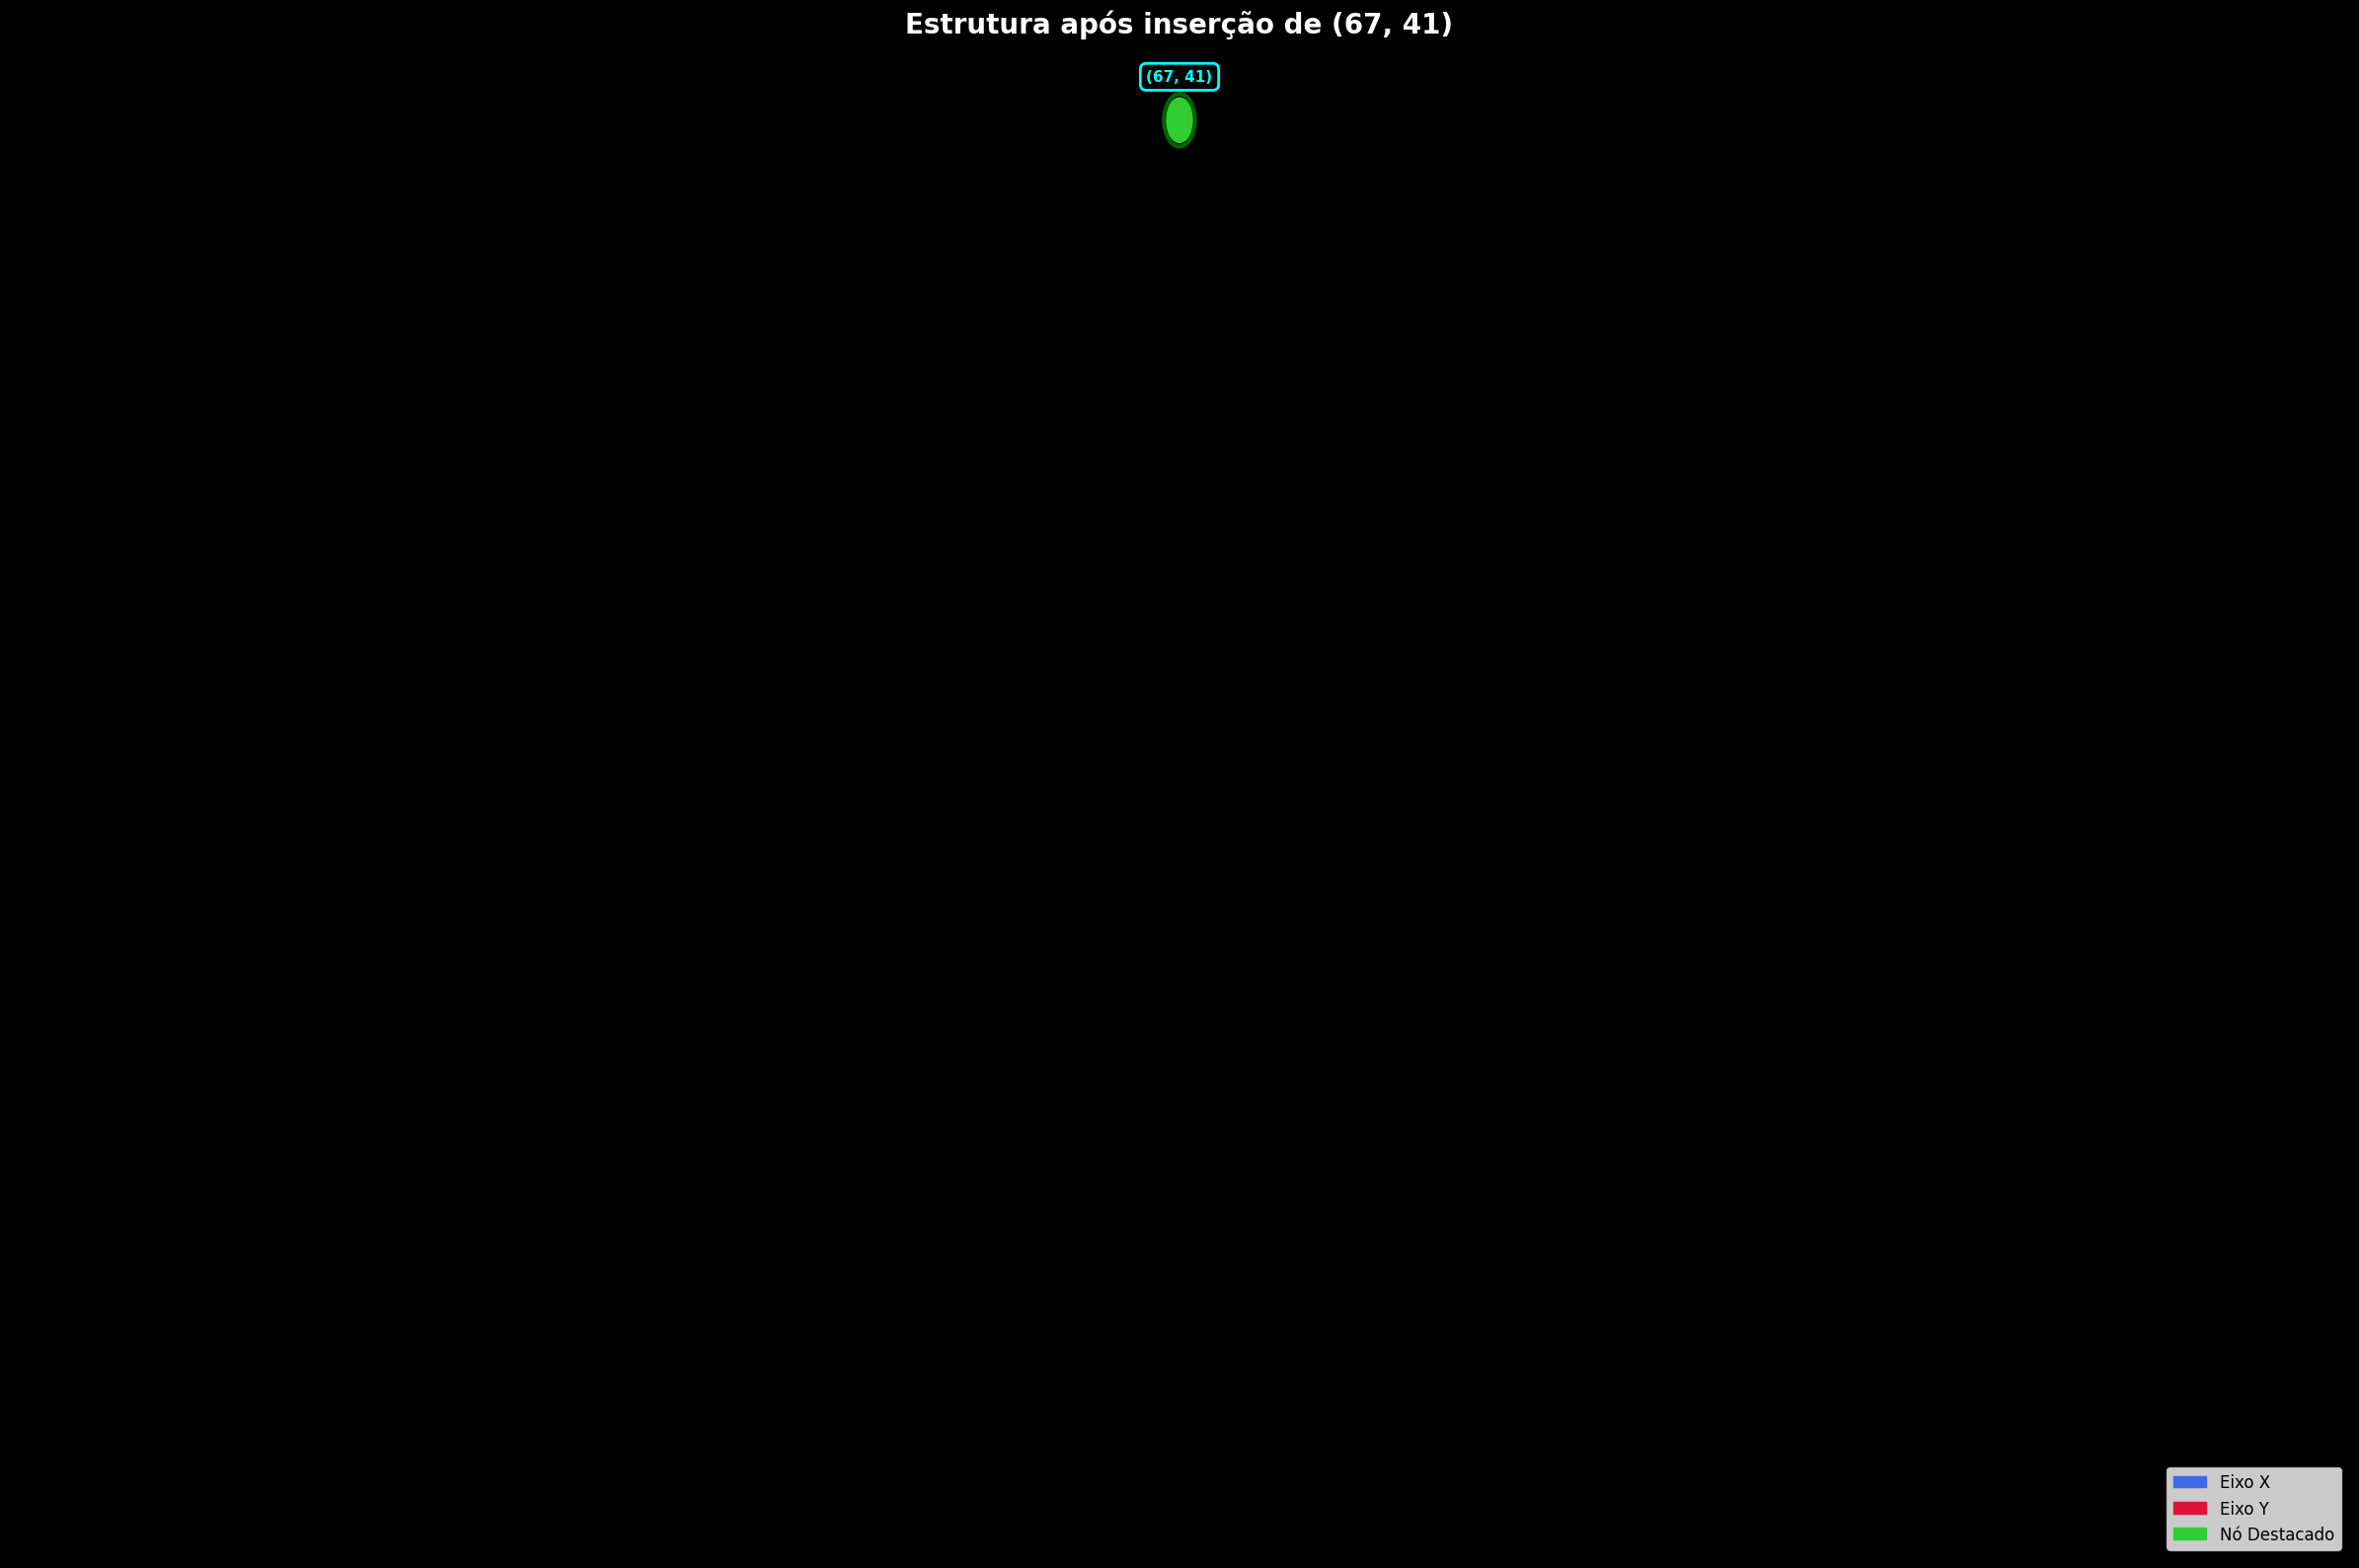

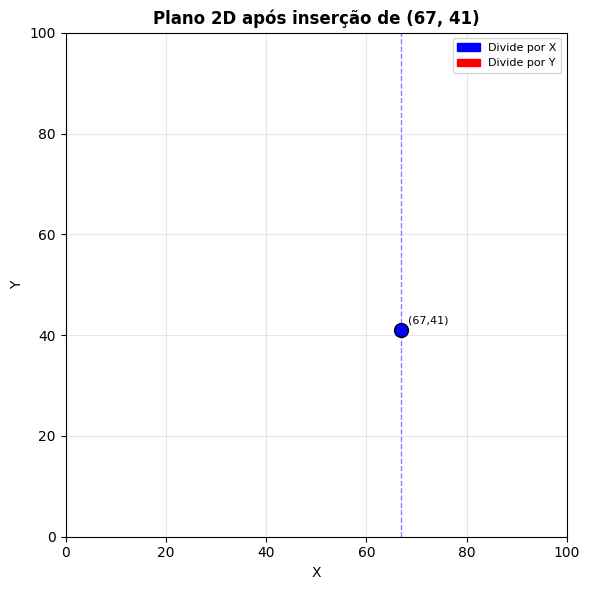


📥 INSERINDO: (66, 39)
  → Comparando 66 com 67 (eixo X), indo para ESQUERDA
  → Criando nó (66, 39) (divide por Y)


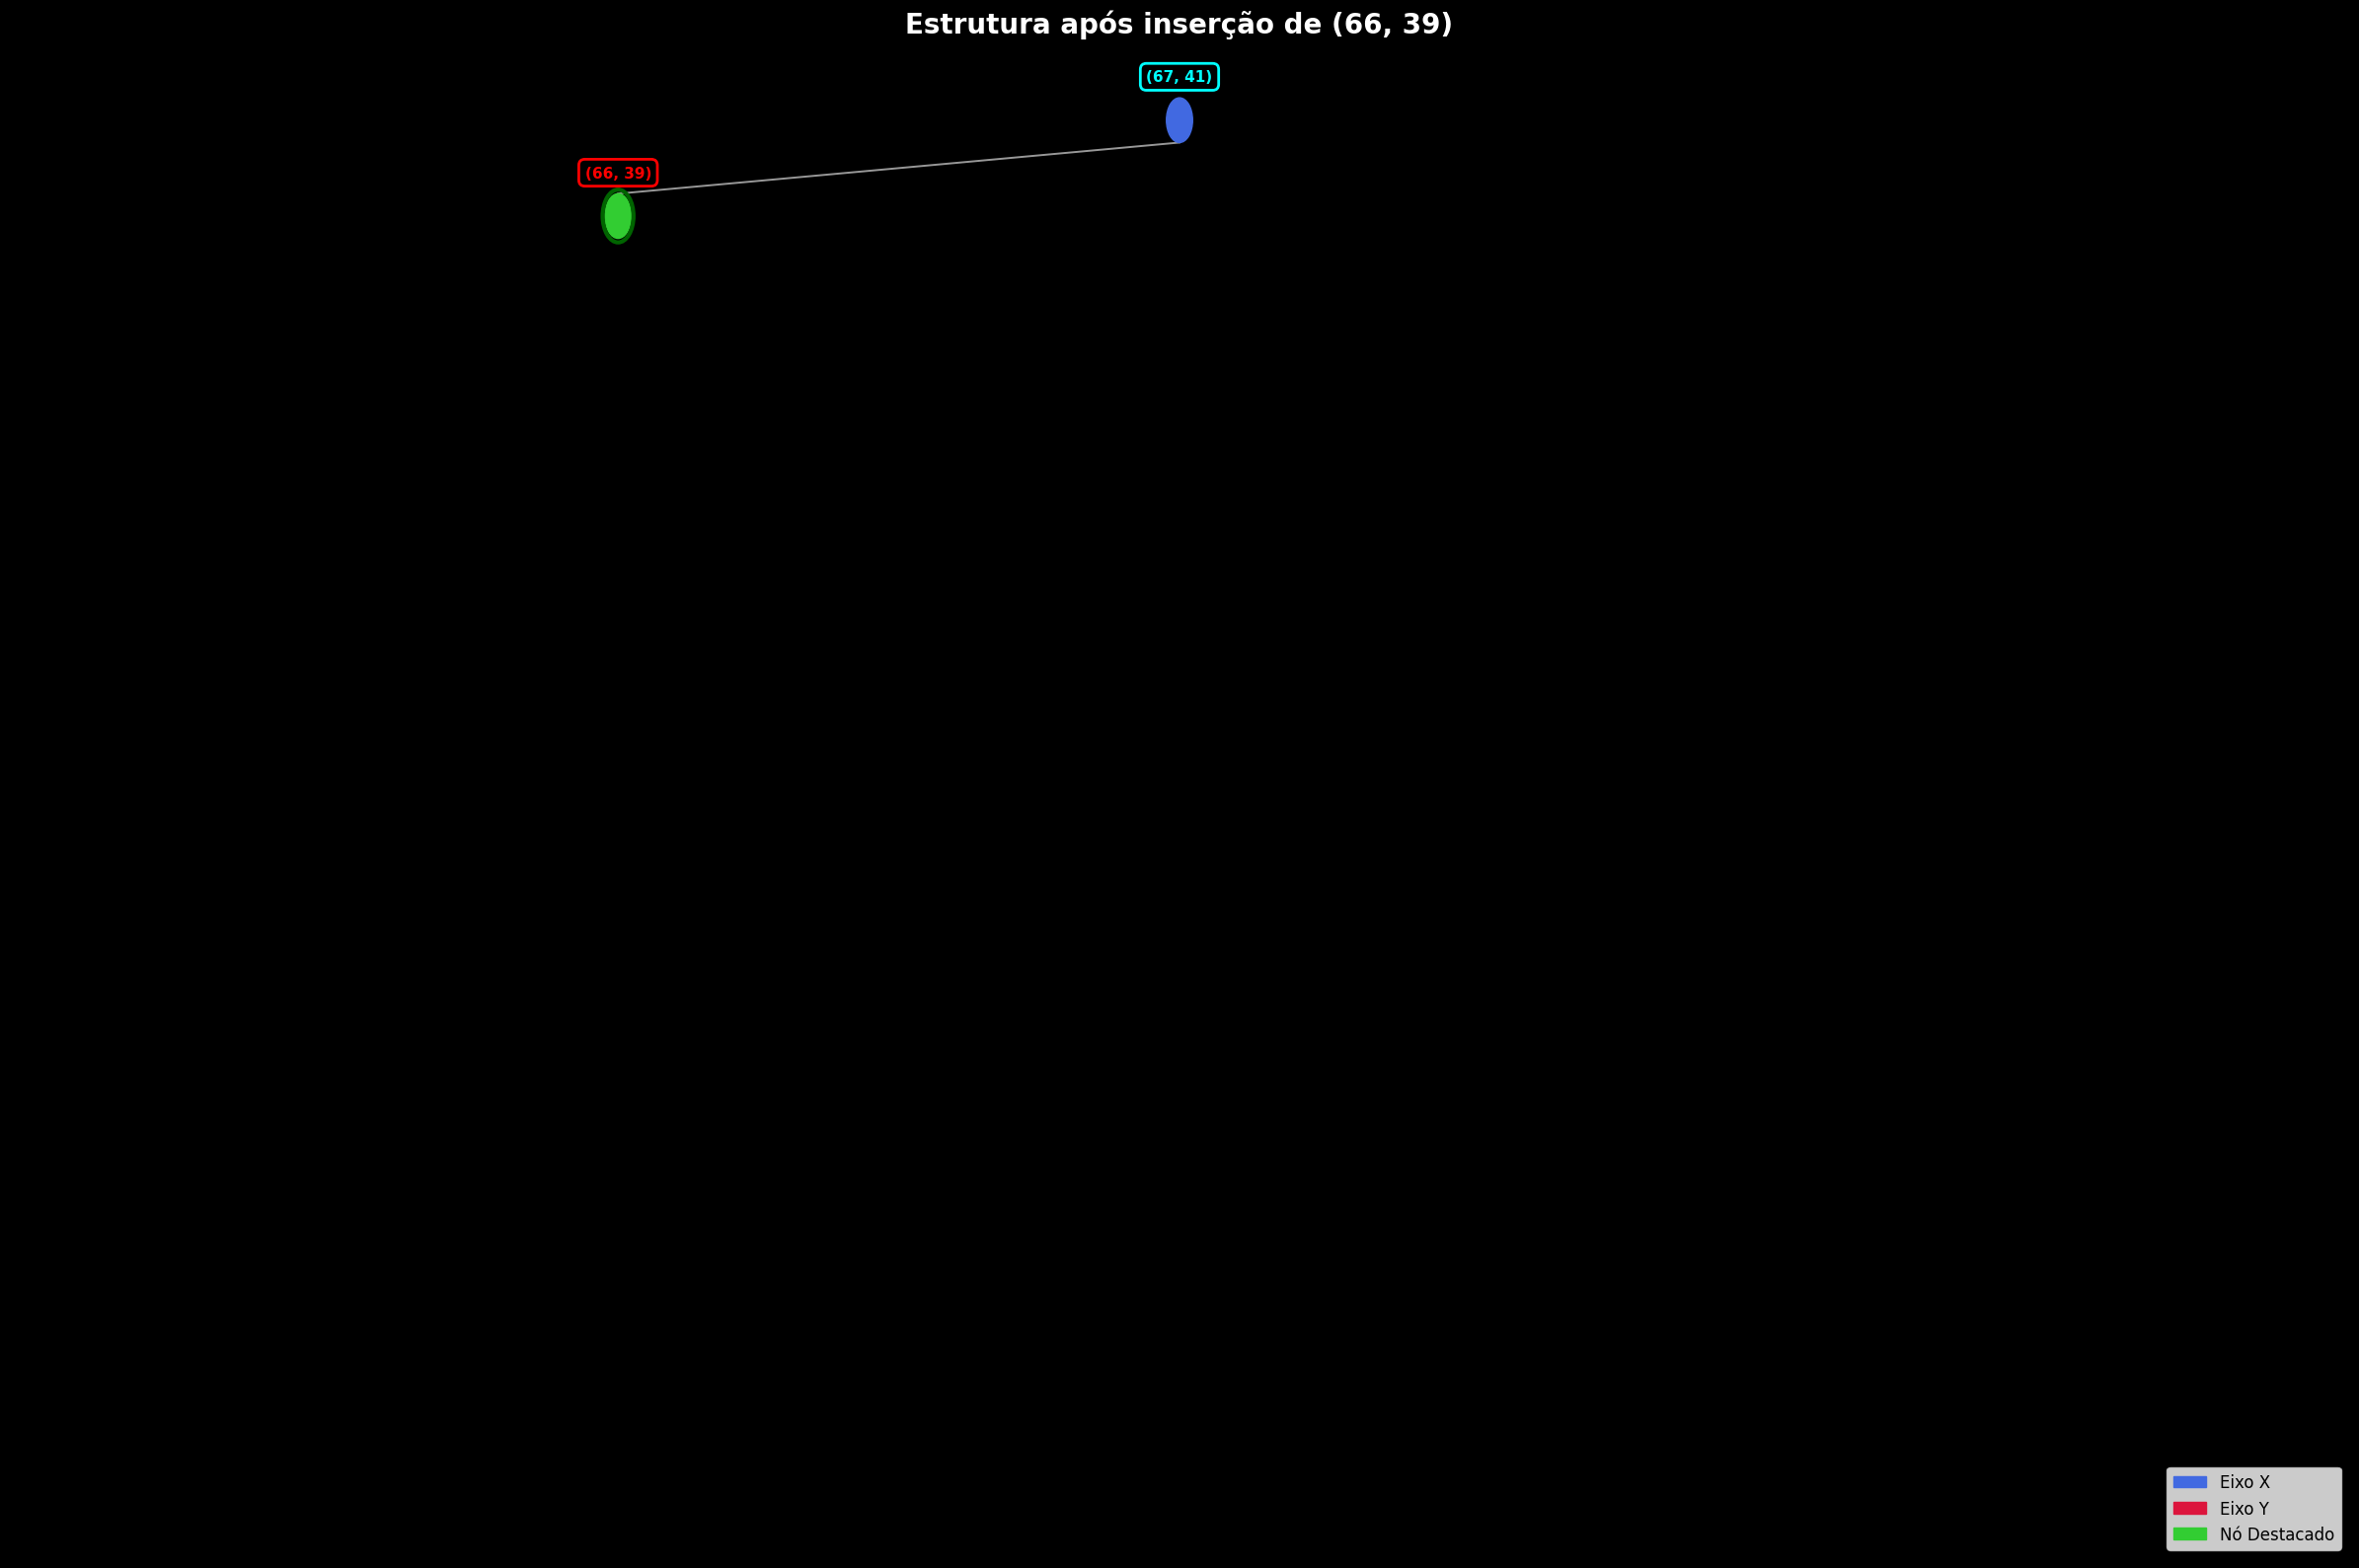

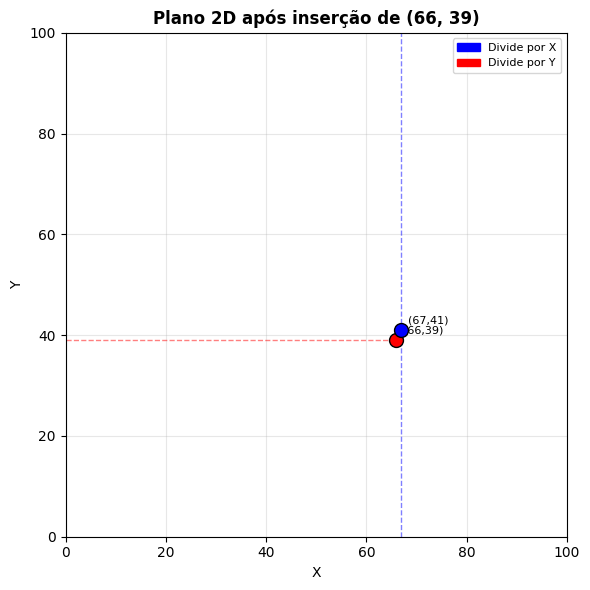


📥 INSERINDO: (26, 47)
  → Comparando 26 com 67 (eixo X), indo para ESQUERDA
  → Comparando 47 com 39 (eixo Y), indo para DIREITA
  → Criando nó (26, 47) (divide por X)


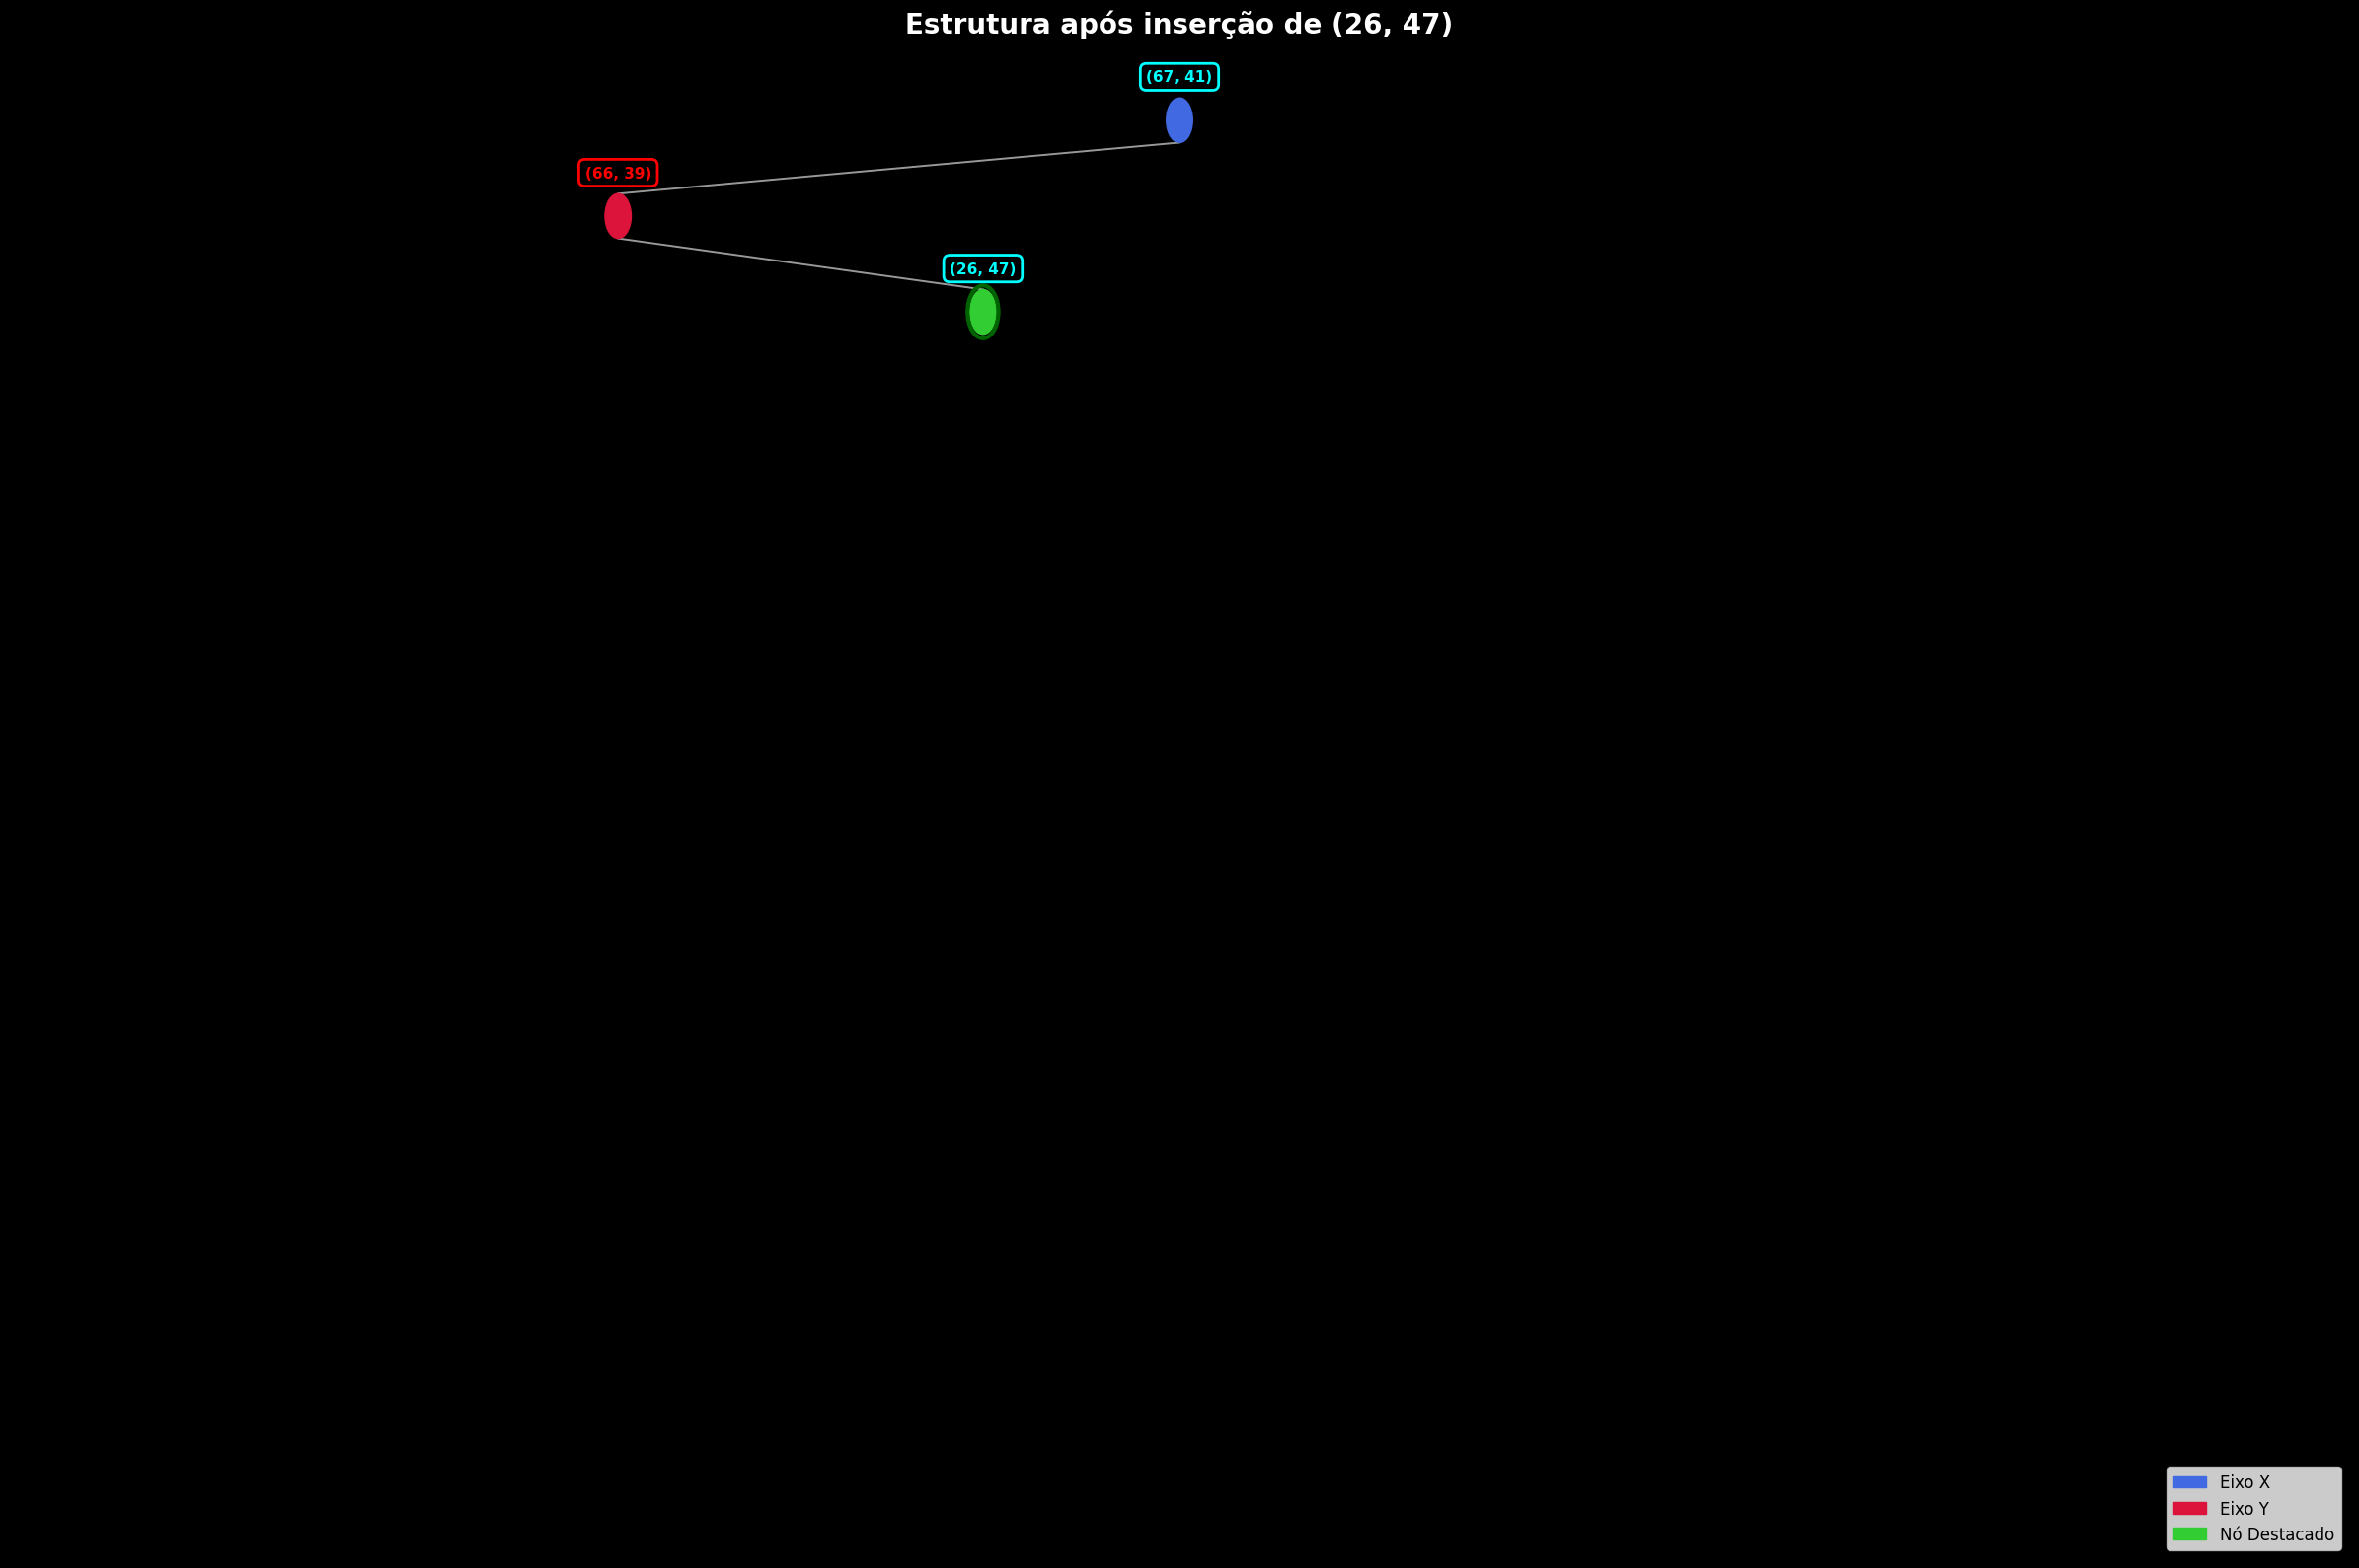

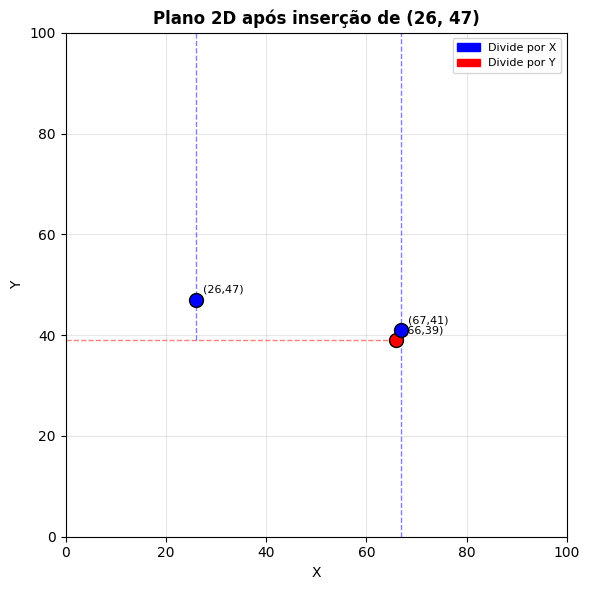


📥 INSERINDO: (26, 58)
  → Comparando 26 com 67 (eixo X), indo para ESQUERDA
  → Comparando 58 com 39 (eixo Y), indo para DIREITA
  → Comparando 26 com 26 (eixo X), indo para DIREITA
  → Criando nó (26, 58) (divide por Y)


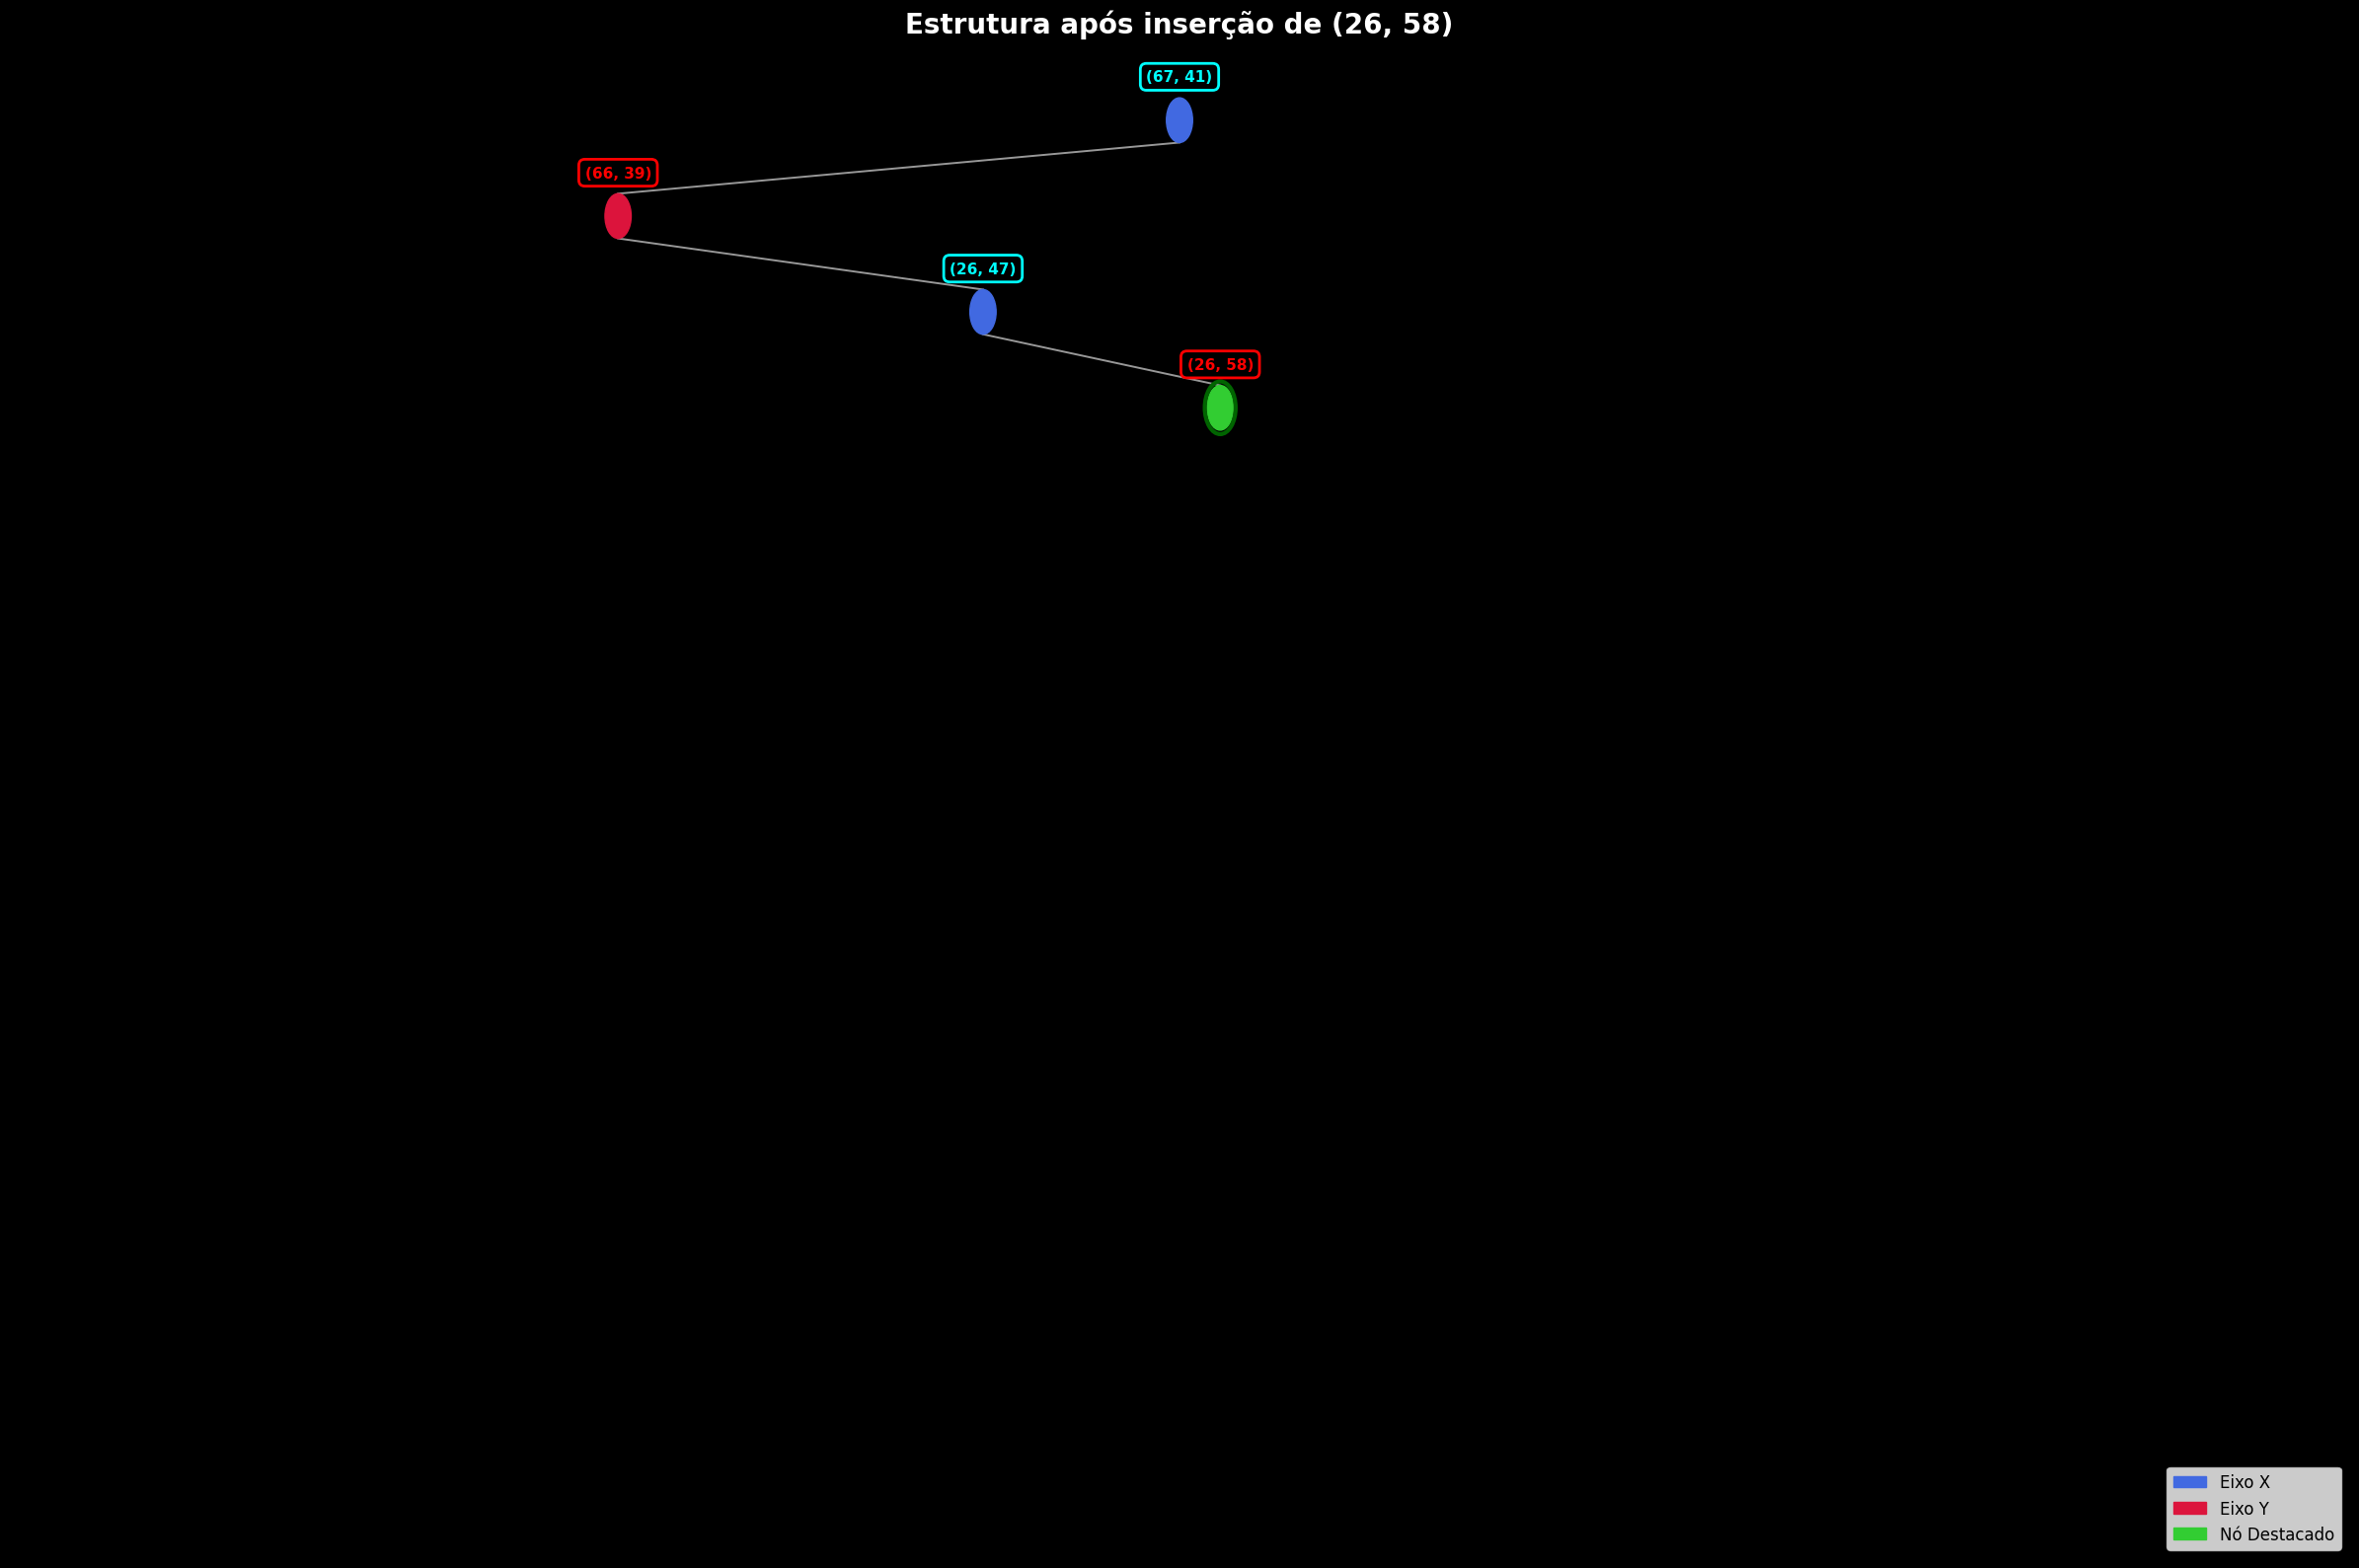

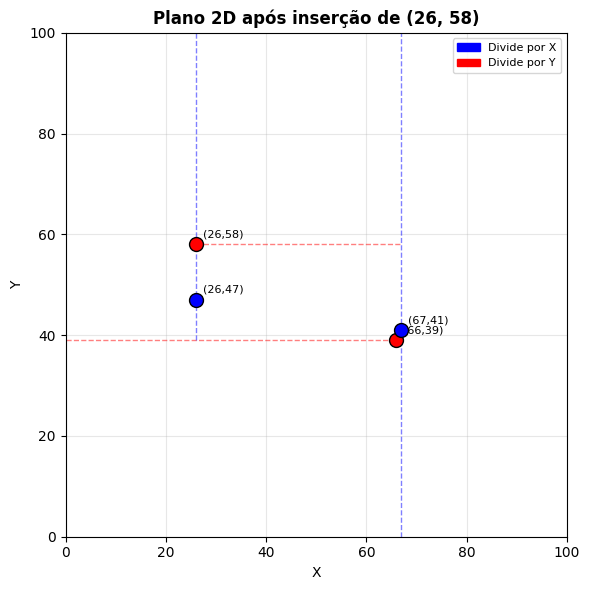


📥 INSERINDO: (24, 72)
  → Comparando 24 com 67 (eixo X), indo para ESQUERDA
  → Comparando 72 com 39 (eixo Y), indo para DIREITA
  → Comparando 24 com 26 (eixo X), indo para ESQUERDA
  → Criando nó (24, 72) (divide por Y)


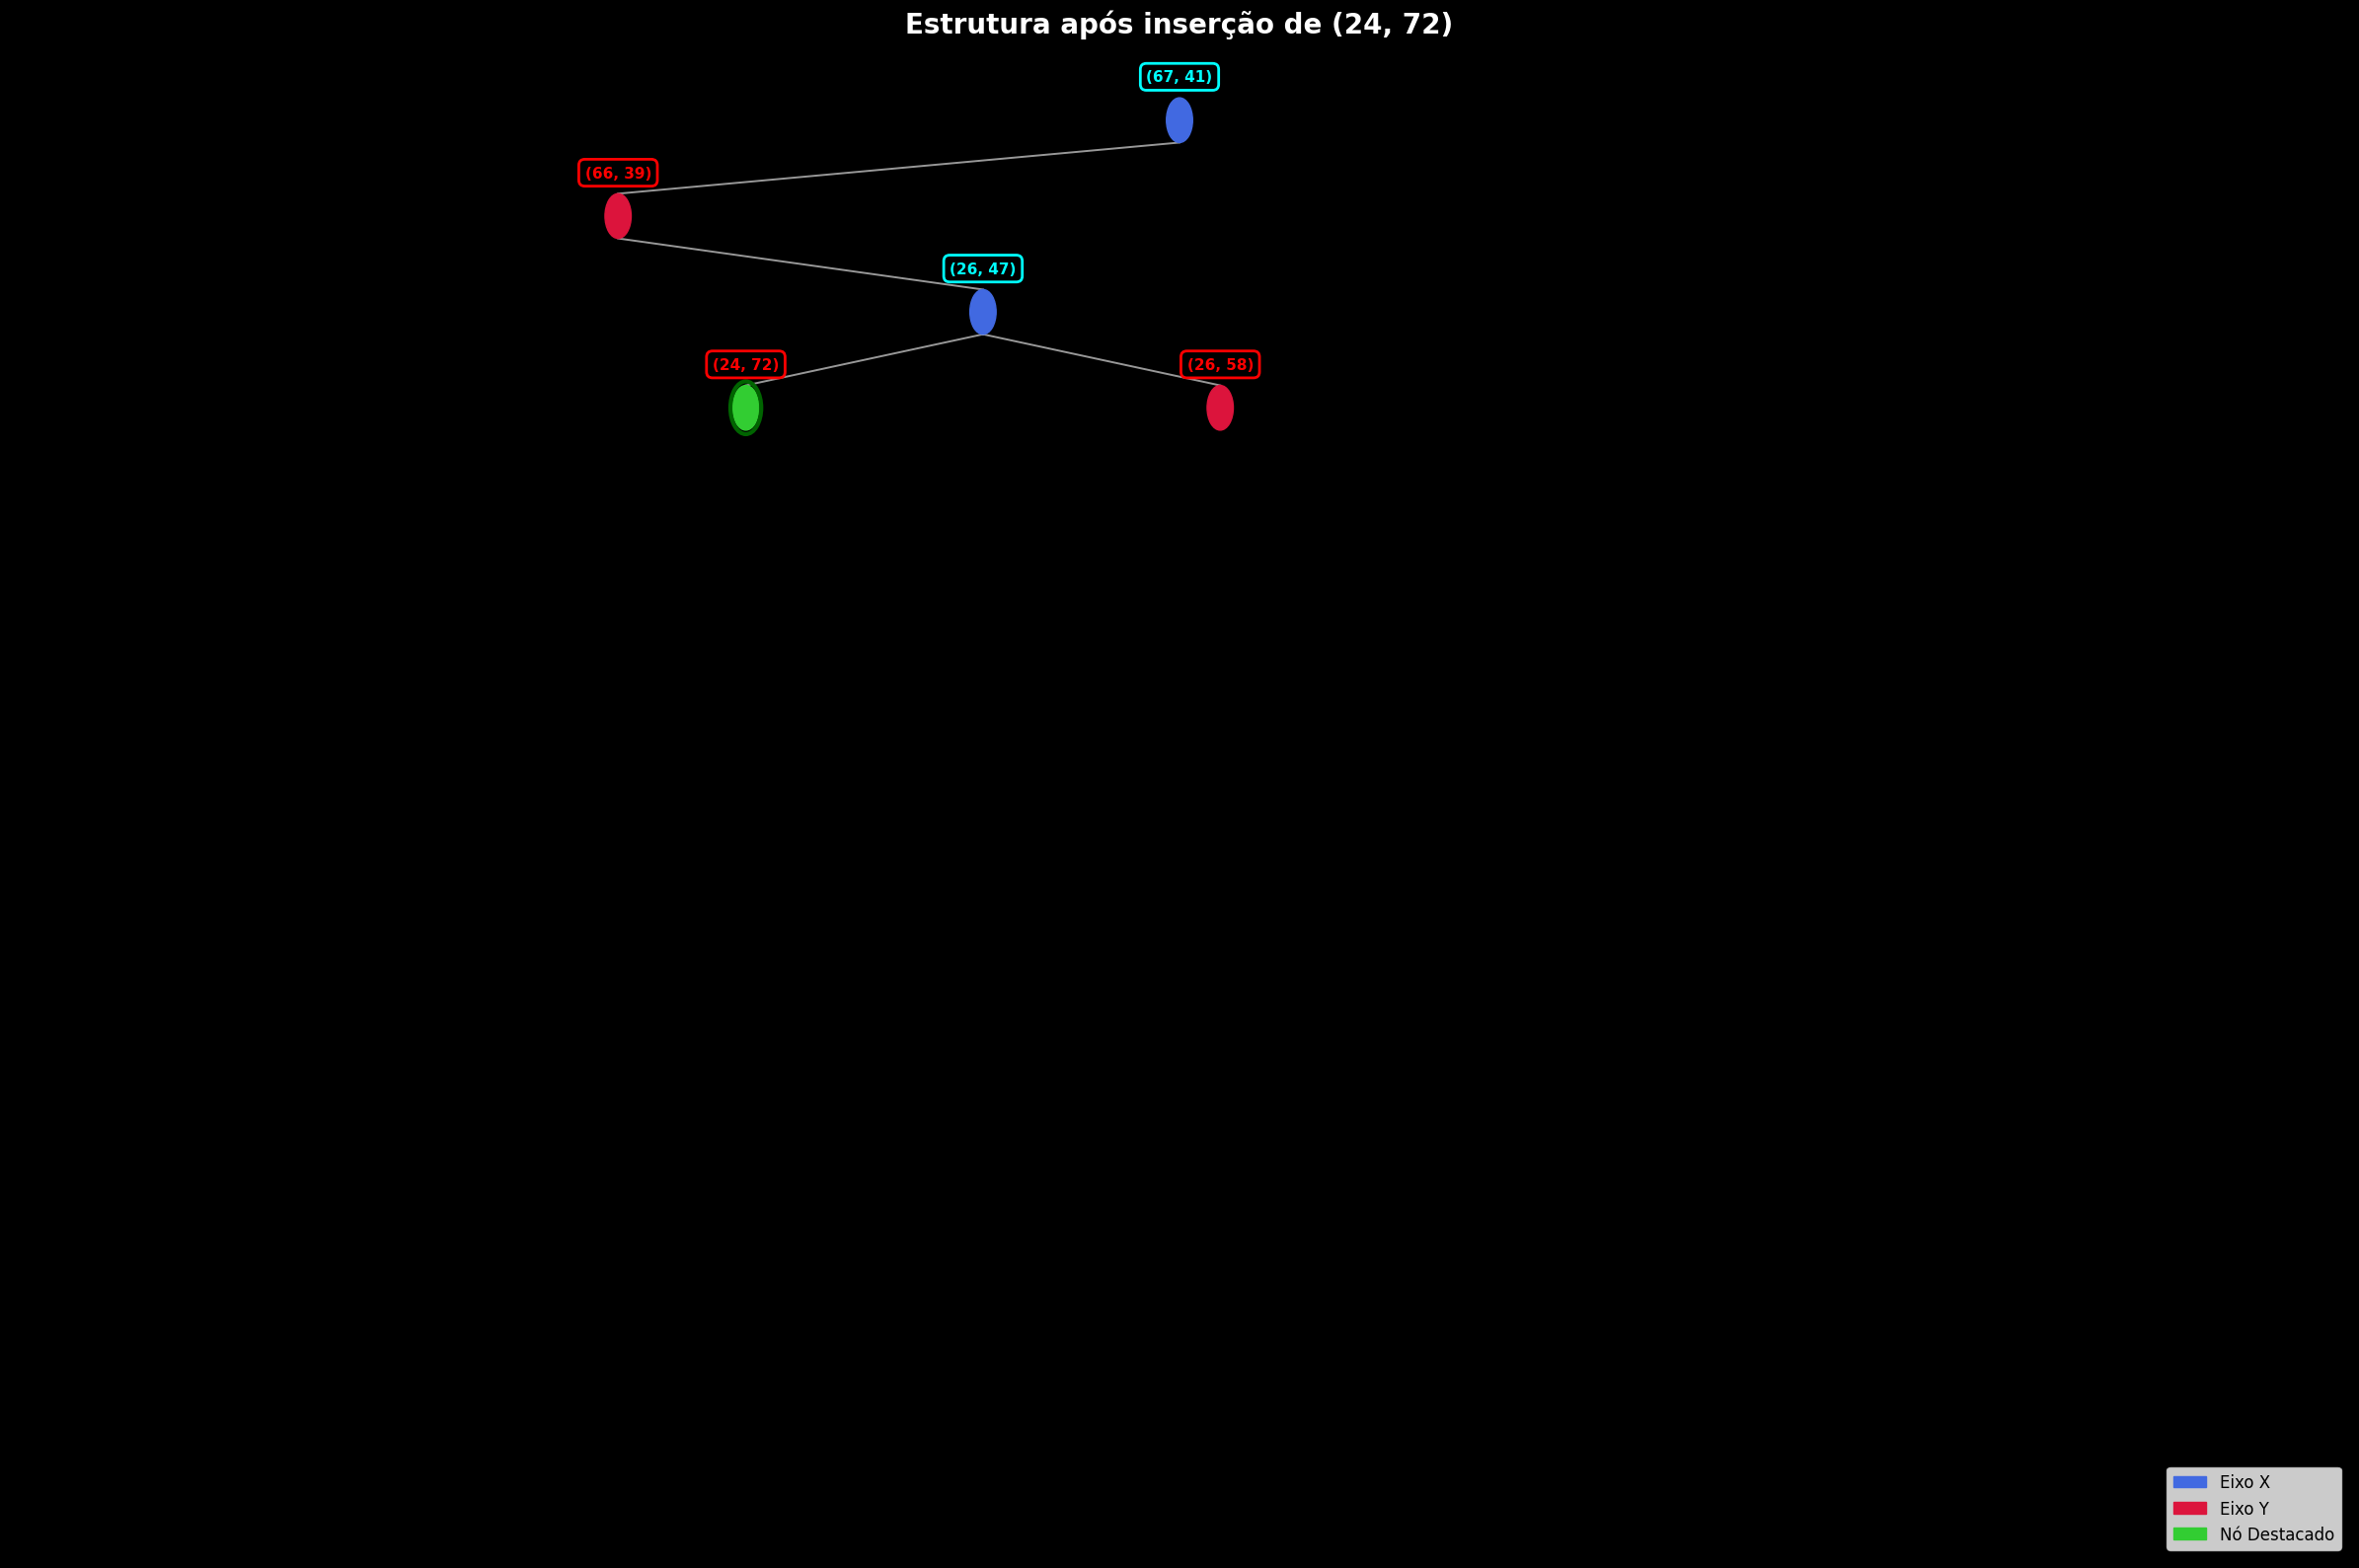

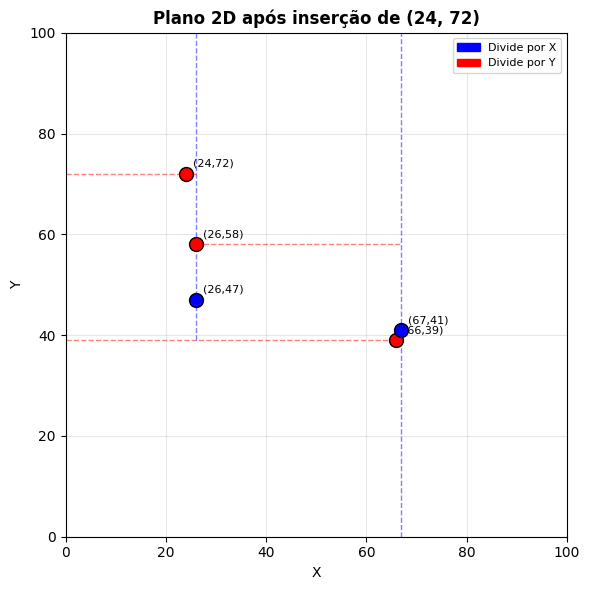


📥 INSERINDO: (82, 19)
  → Comparando 82 com 67 (eixo X), indo para DIREITA
  → Criando nó (82, 19) (divide por Y)


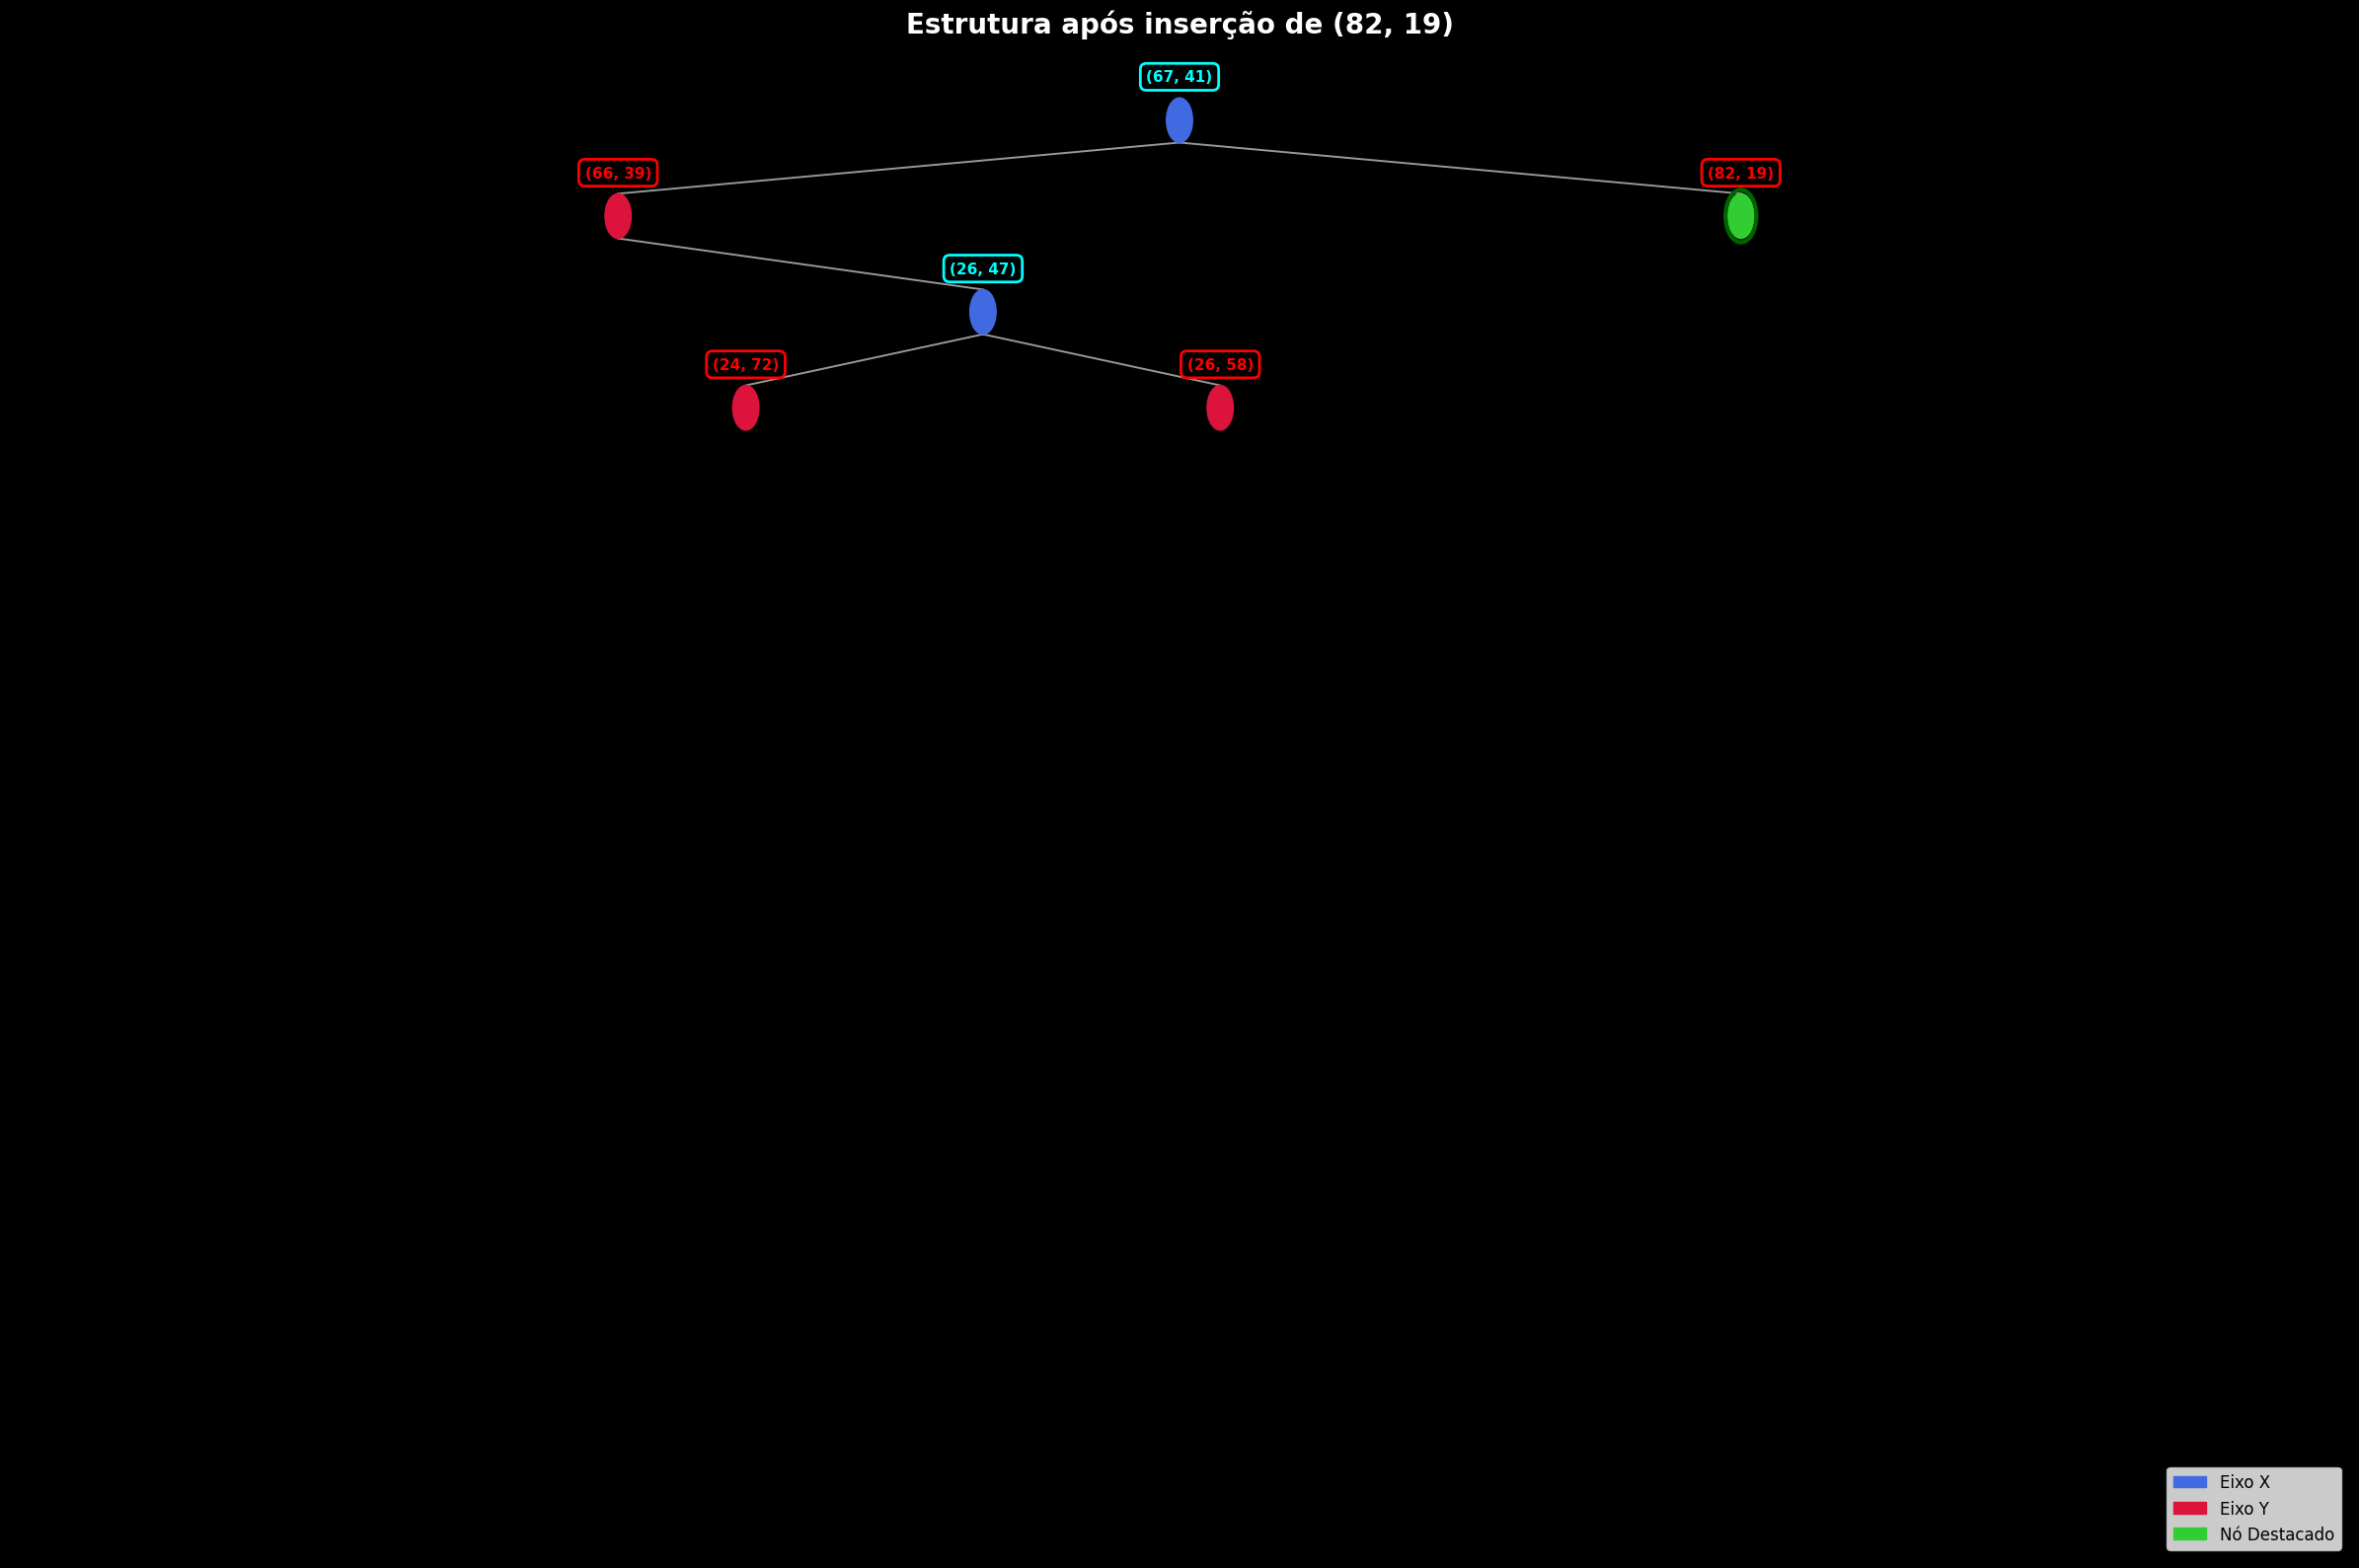

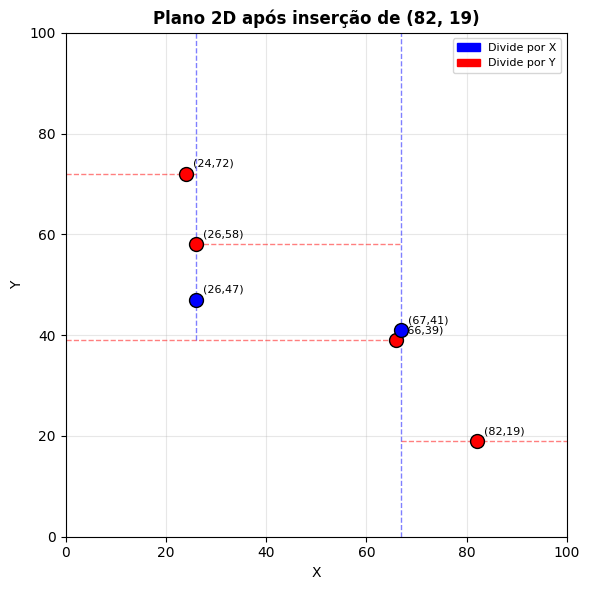


📥 INSERINDO: (27, 20)
  → Comparando 27 com 67 (eixo X), indo para ESQUERDA
  → Comparando 20 com 39 (eixo Y), indo para ESQUERDA
  → Criando nó (27, 20) (divide por X)


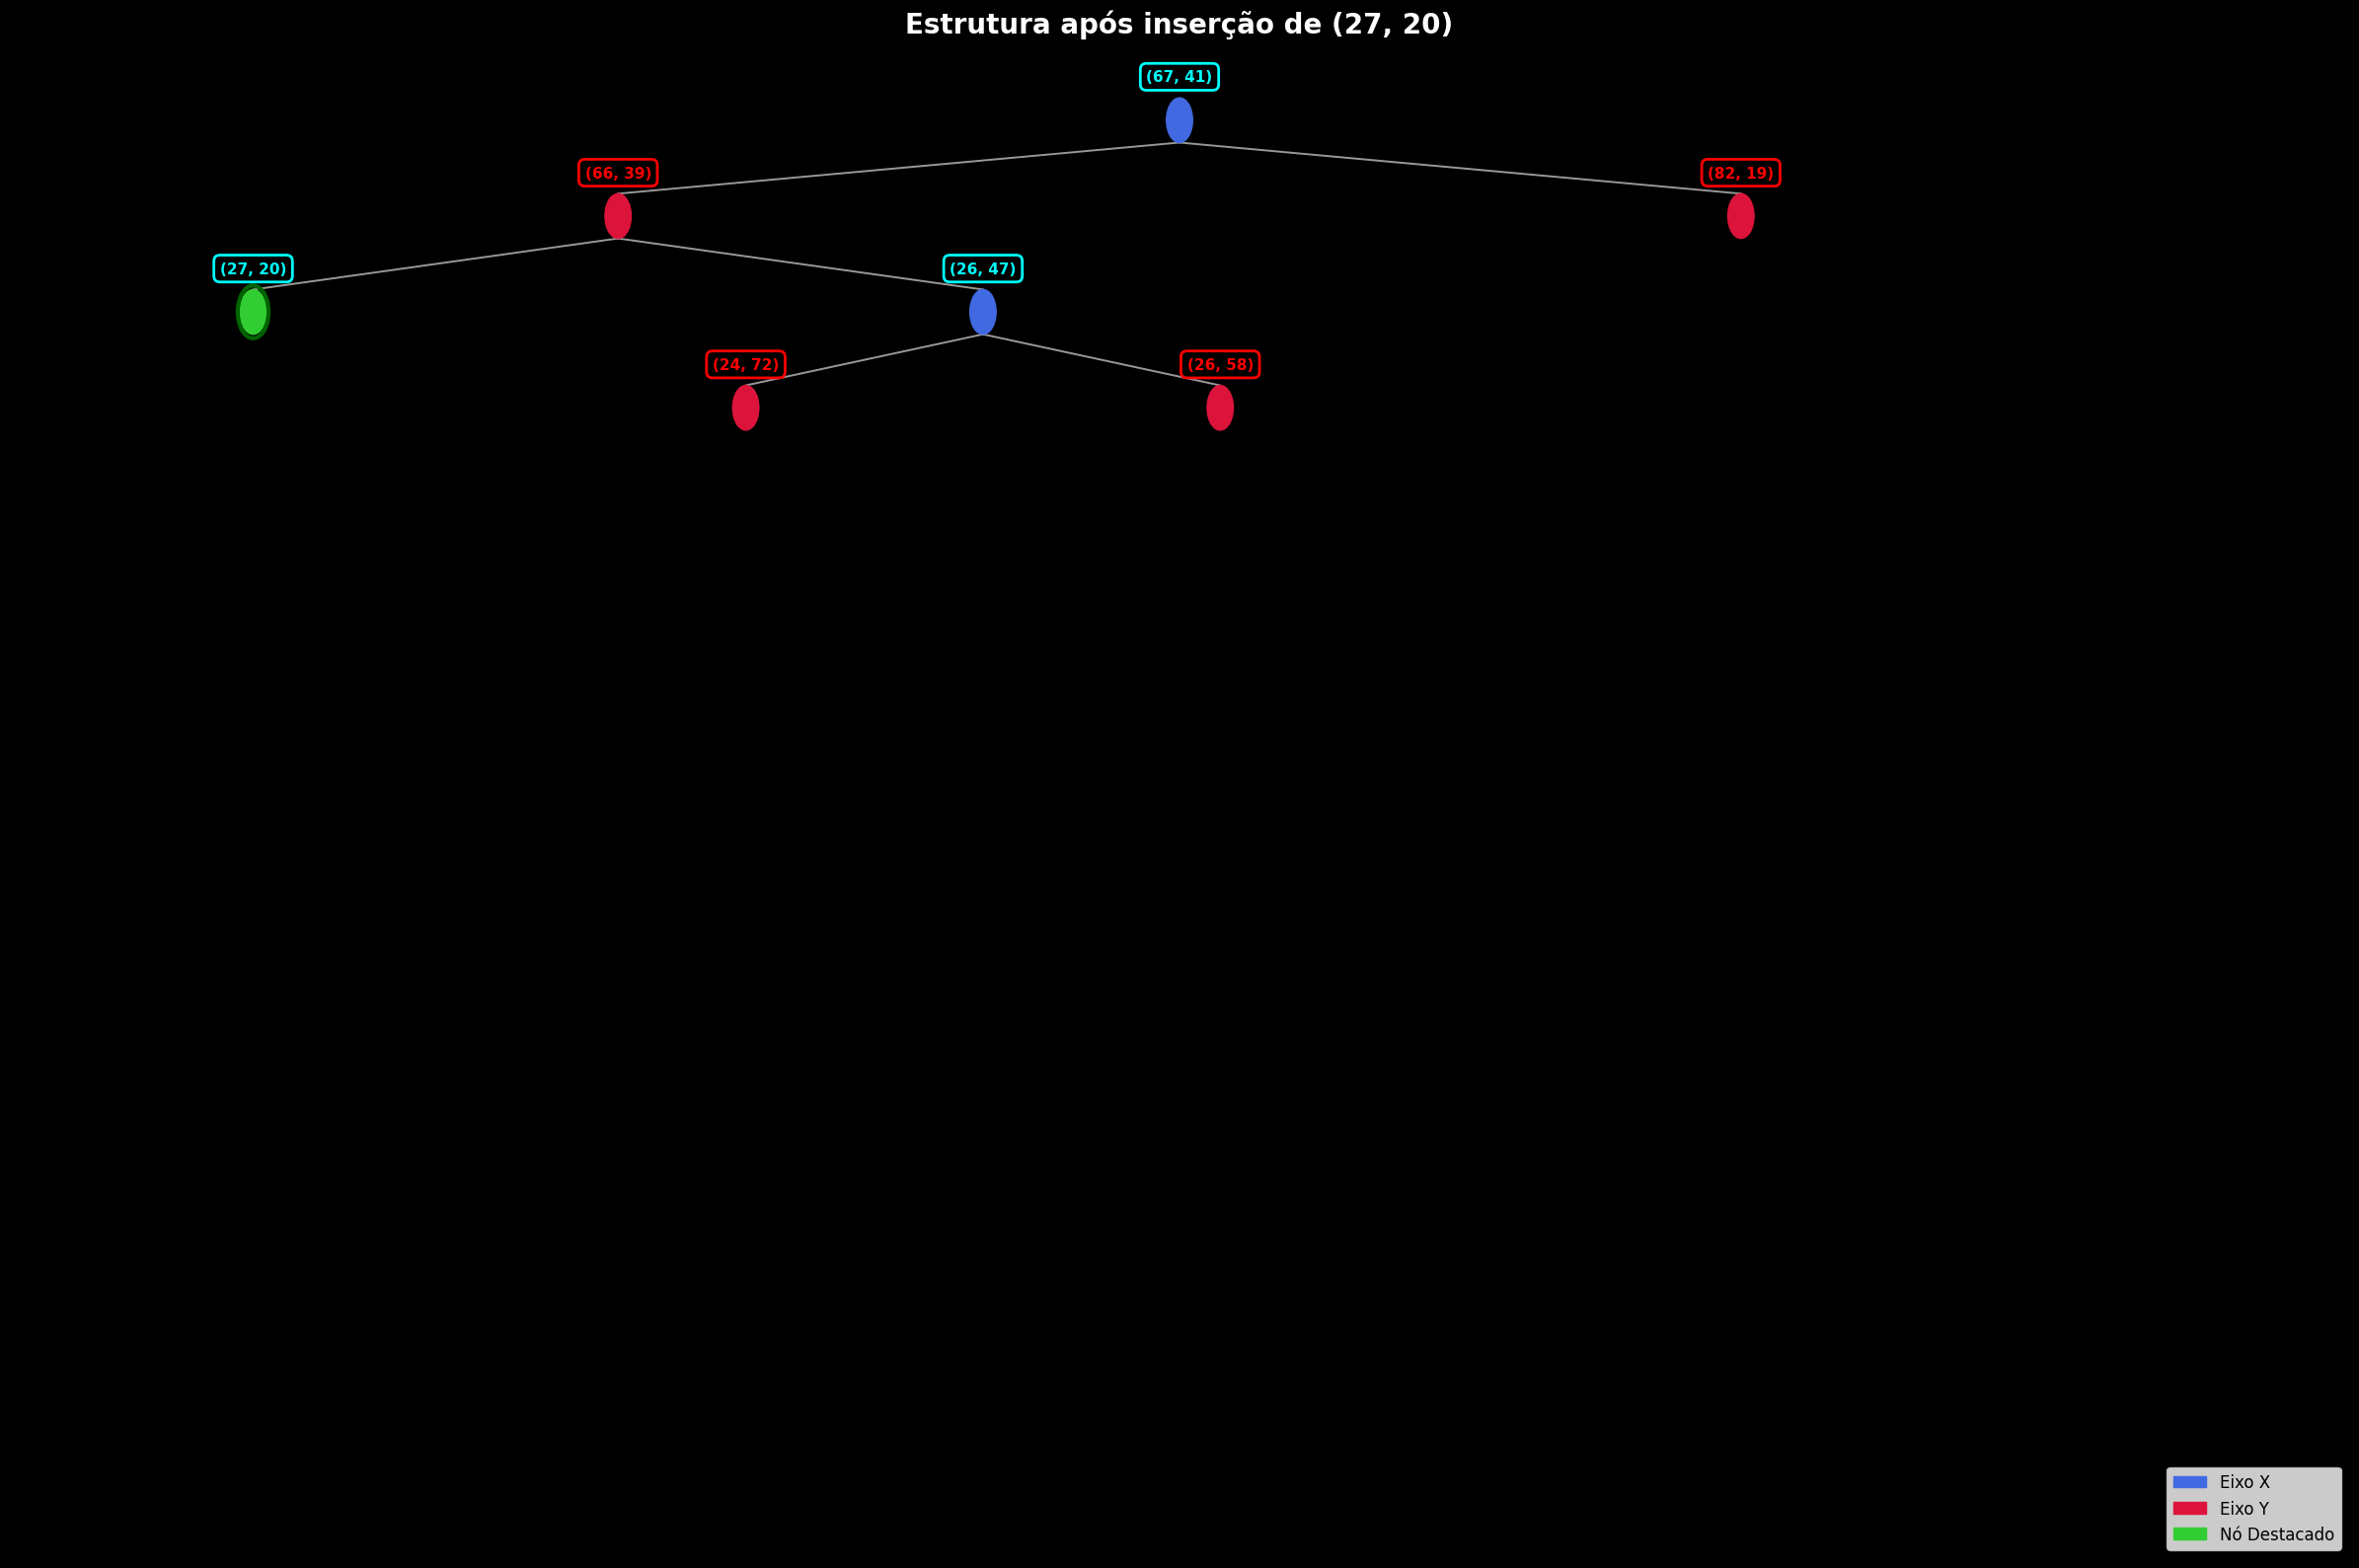

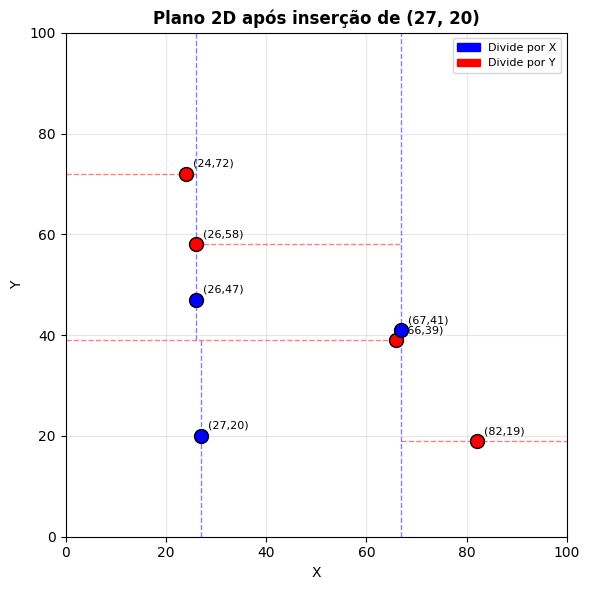


📥 INSERINDO: (31, 85)
  → Comparando 31 com 67 (eixo X), indo para ESQUERDA
  → Comparando 85 com 39 (eixo Y), indo para DIREITA
  → Comparando 31 com 26 (eixo X), indo para DIREITA
  → Comparando 85 com 58 (eixo Y), indo para DIREITA
  → Criando nó (31, 85) (divide por X)


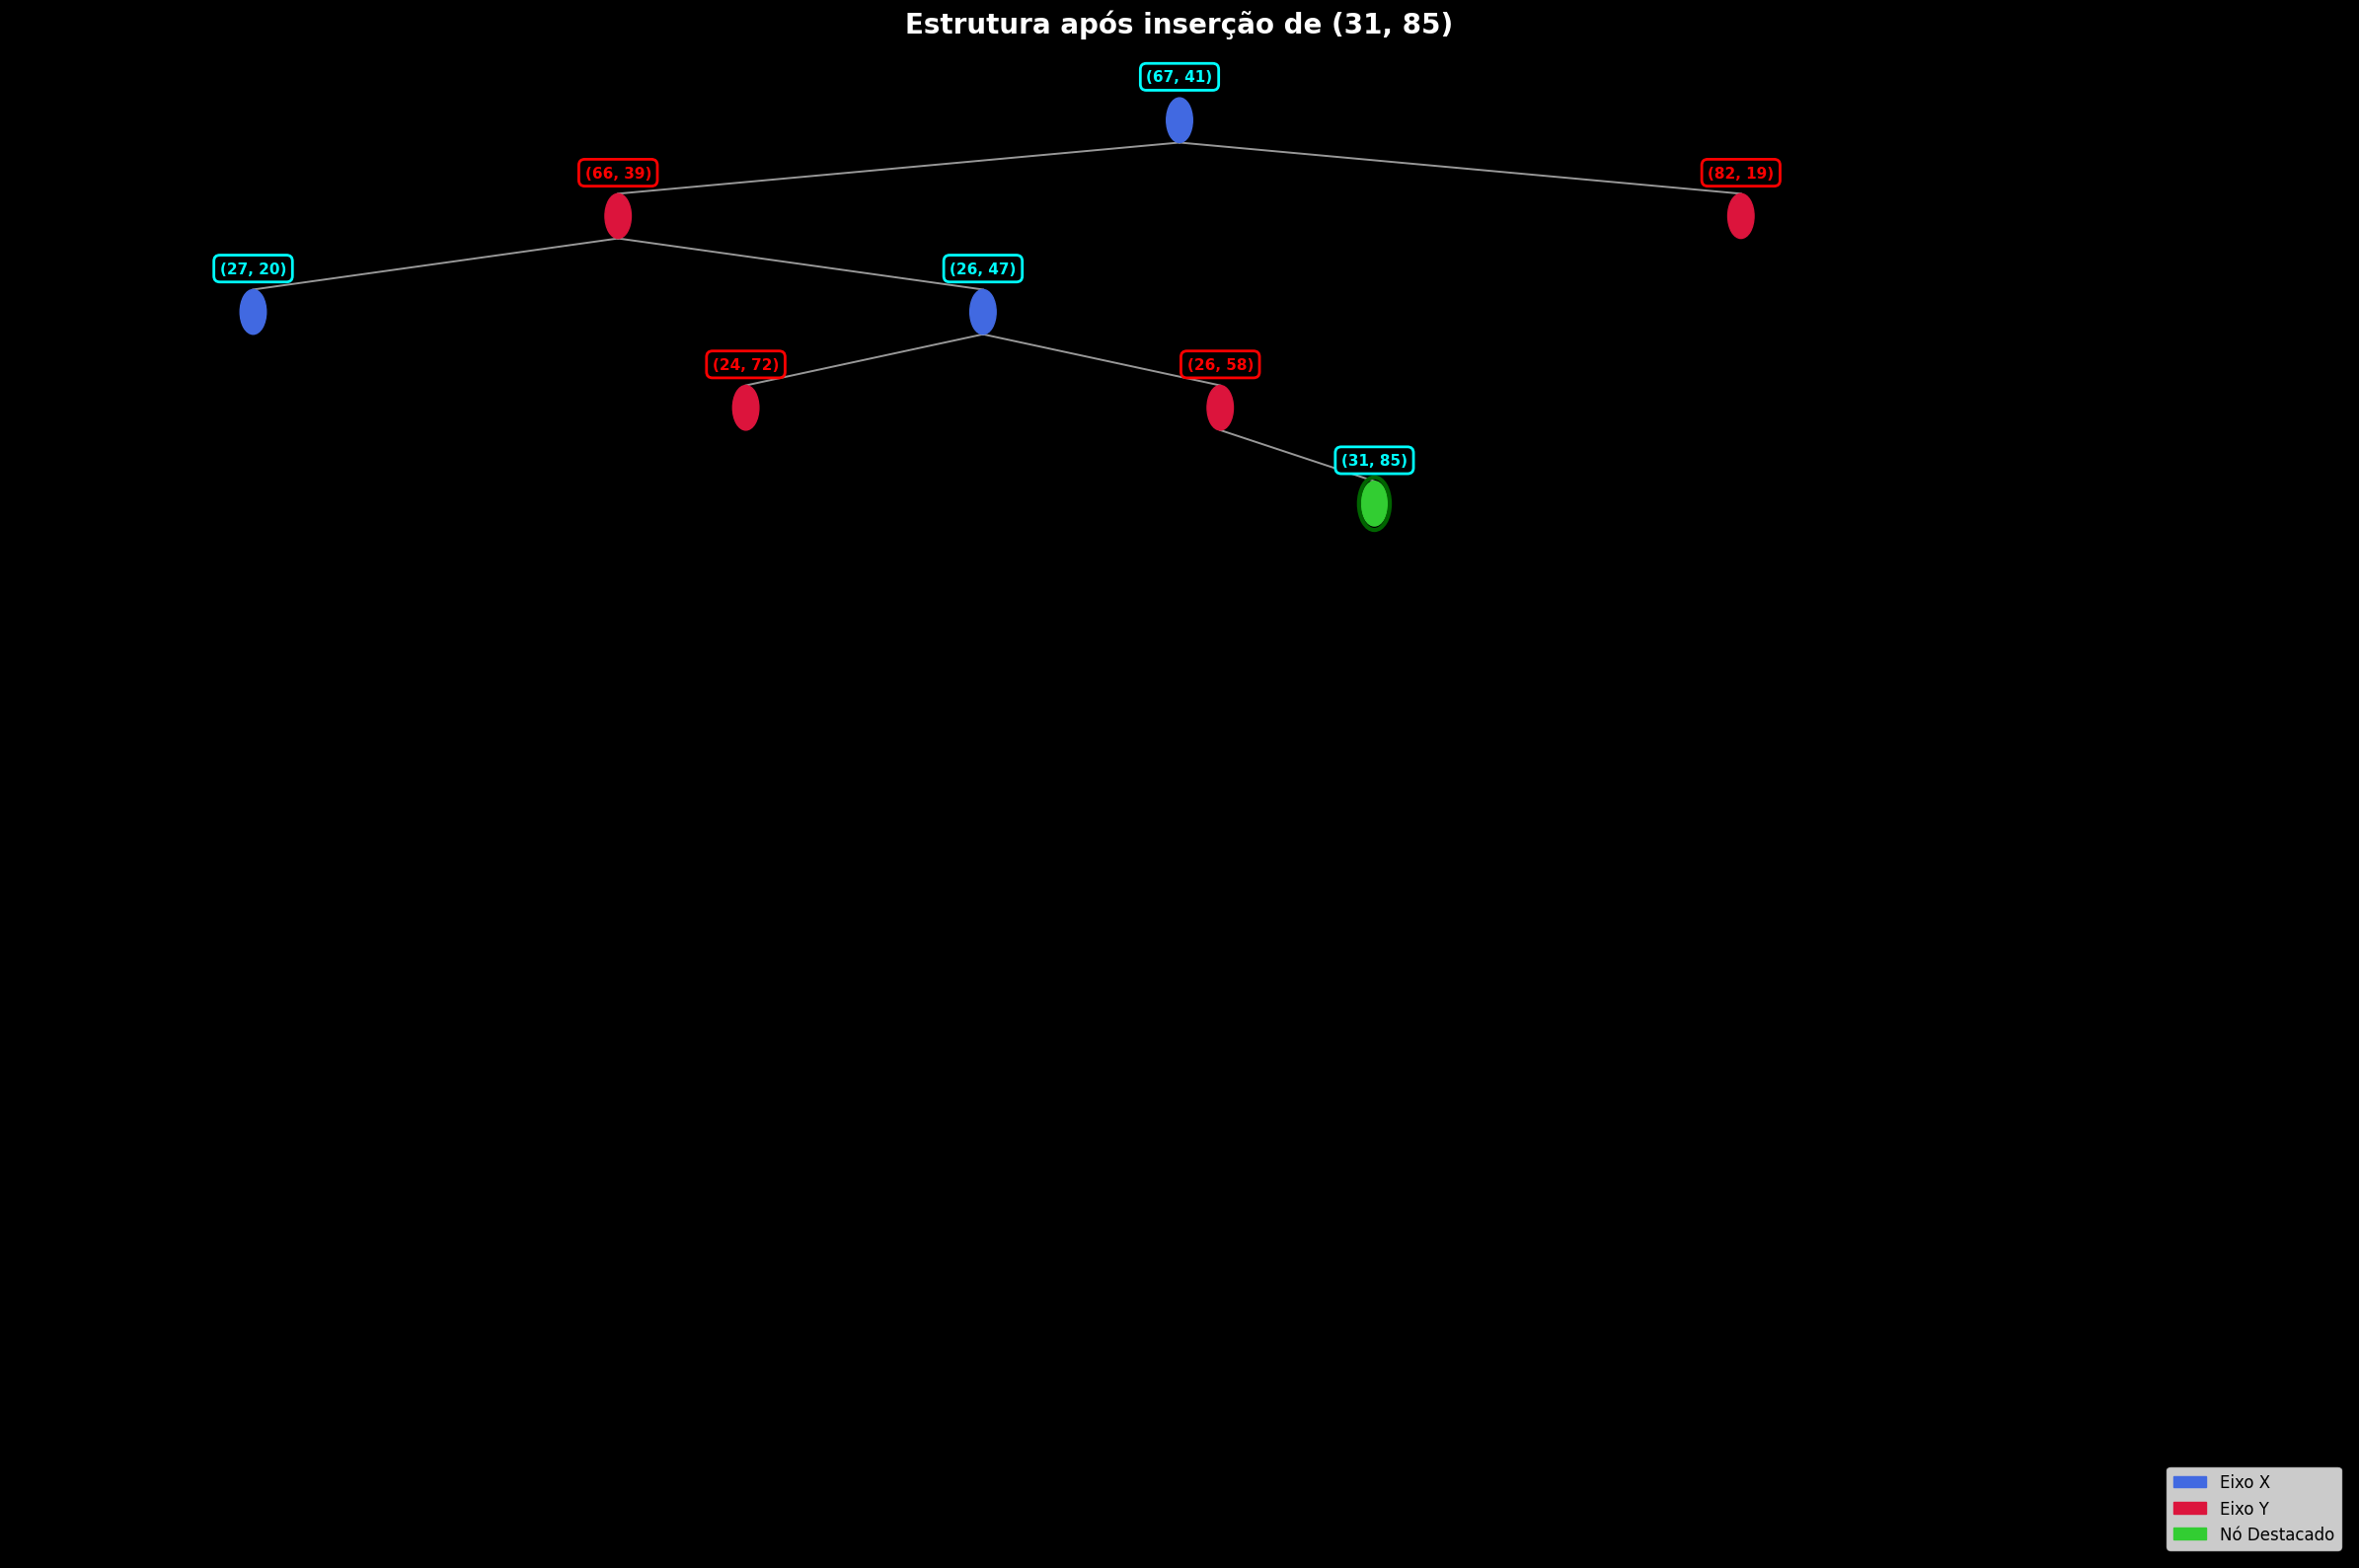

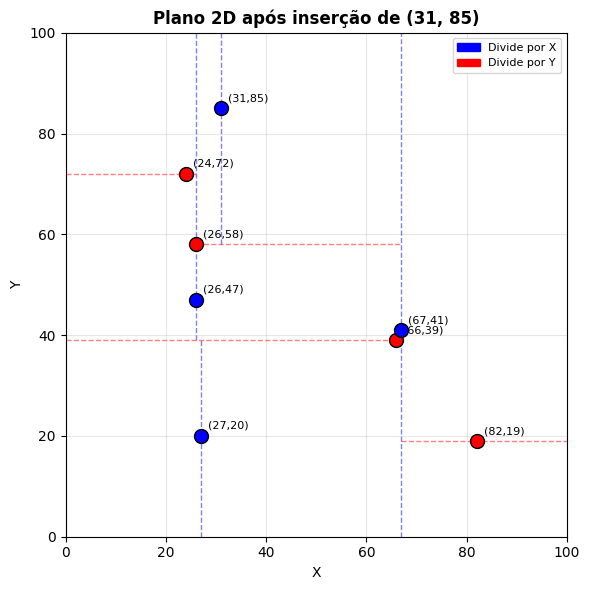


📥 INSERINDO: (65, 75)
  → Comparando 65 com 67 (eixo X), indo para ESQUERDA
  → Comparando 75 com 39 (eixo Y), indo para DIREITA
  → Comparando 65 com 26 (eixo X), indo para DIREITA
  → Comparando 75 com 58 (eixo Y), indo para DIREITA
  → Comparando 65 com 31 (eixo X), indo para DIREITA
  → Criando nó (65, 75) (divide por Y)


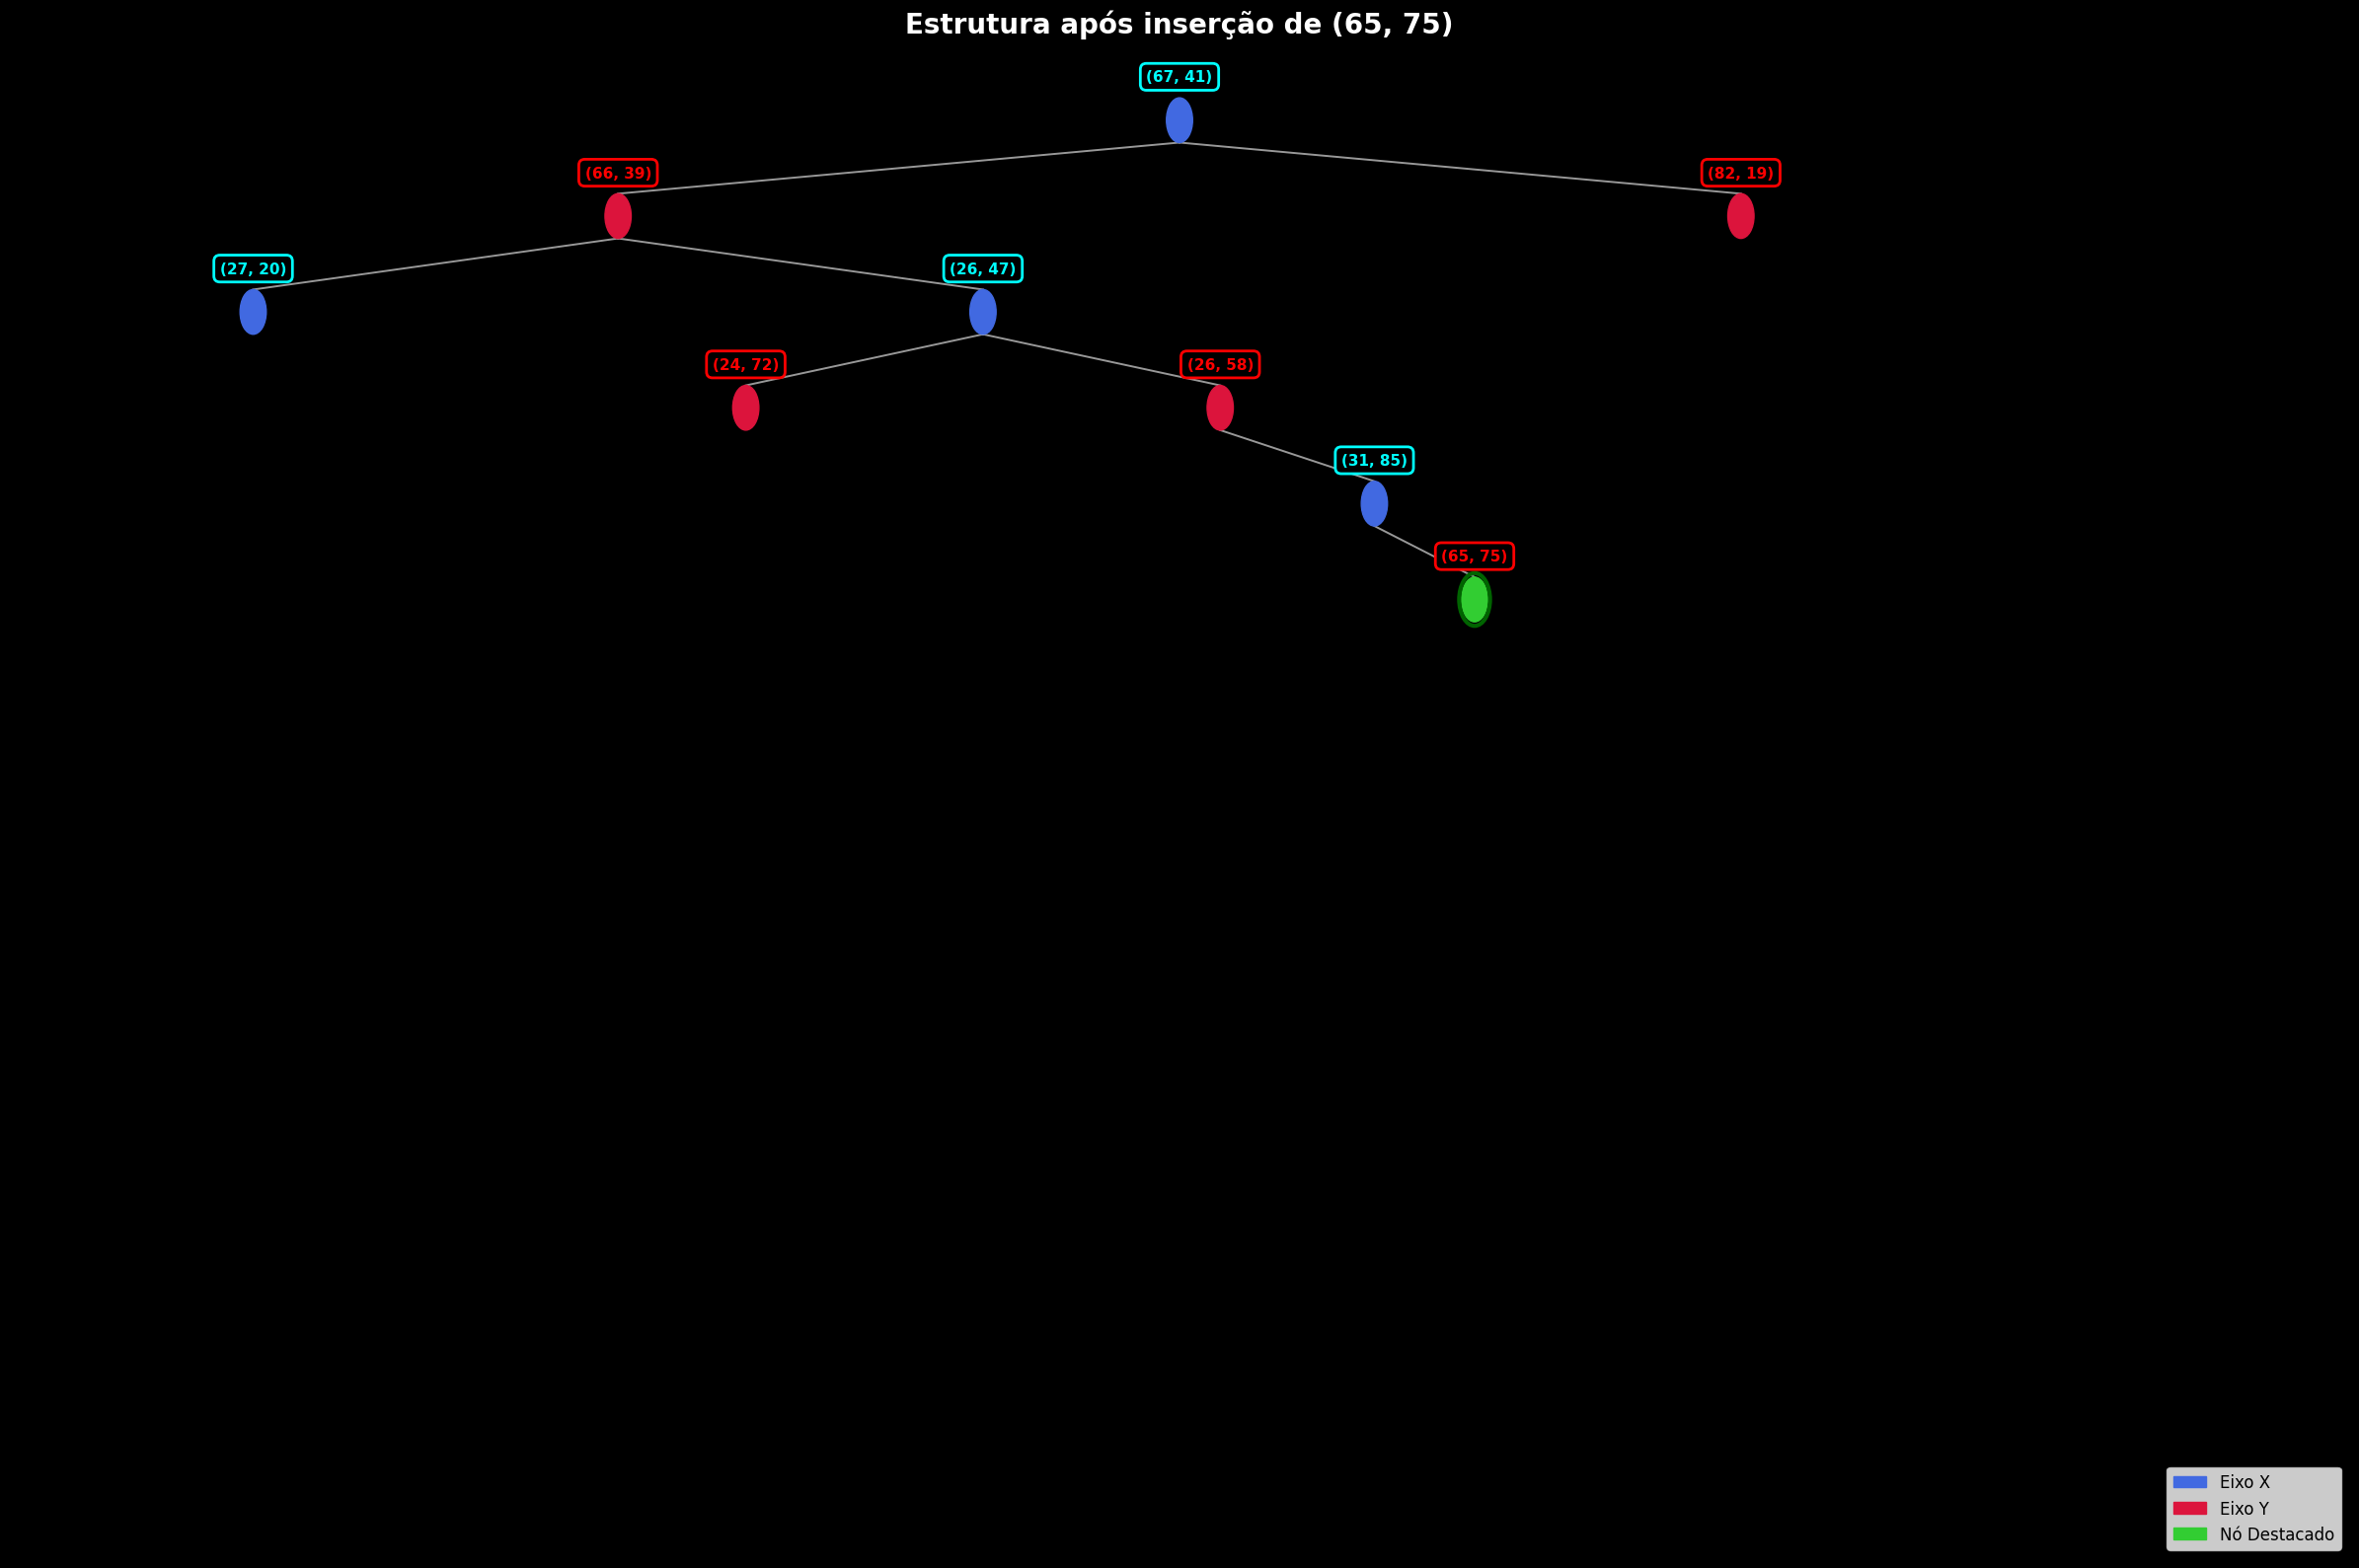

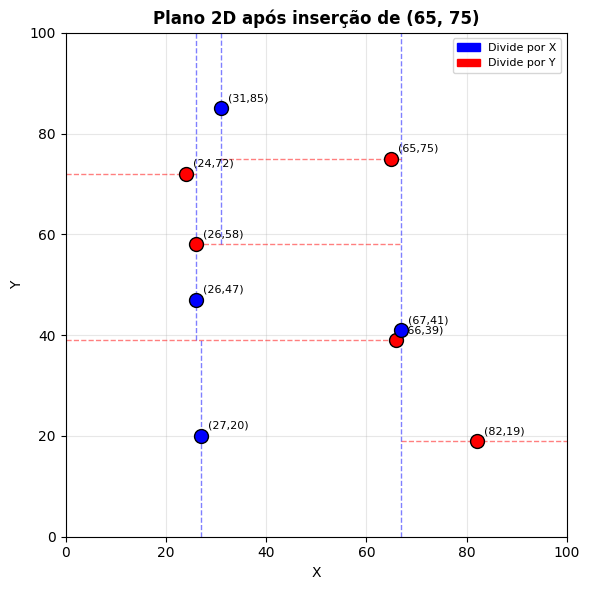


📥 INSERINDO: (64, 25)
  → Comparando 64 com 67 (eixo X), indo para ESQUERDA
  → Comparando 25 com 39 (eixo Y), indo para ESQUERDA
  → Comparando 64 com 27 (eixo X), indo para DIREITA
  → Criando nó (64, 25) (divide por Y)


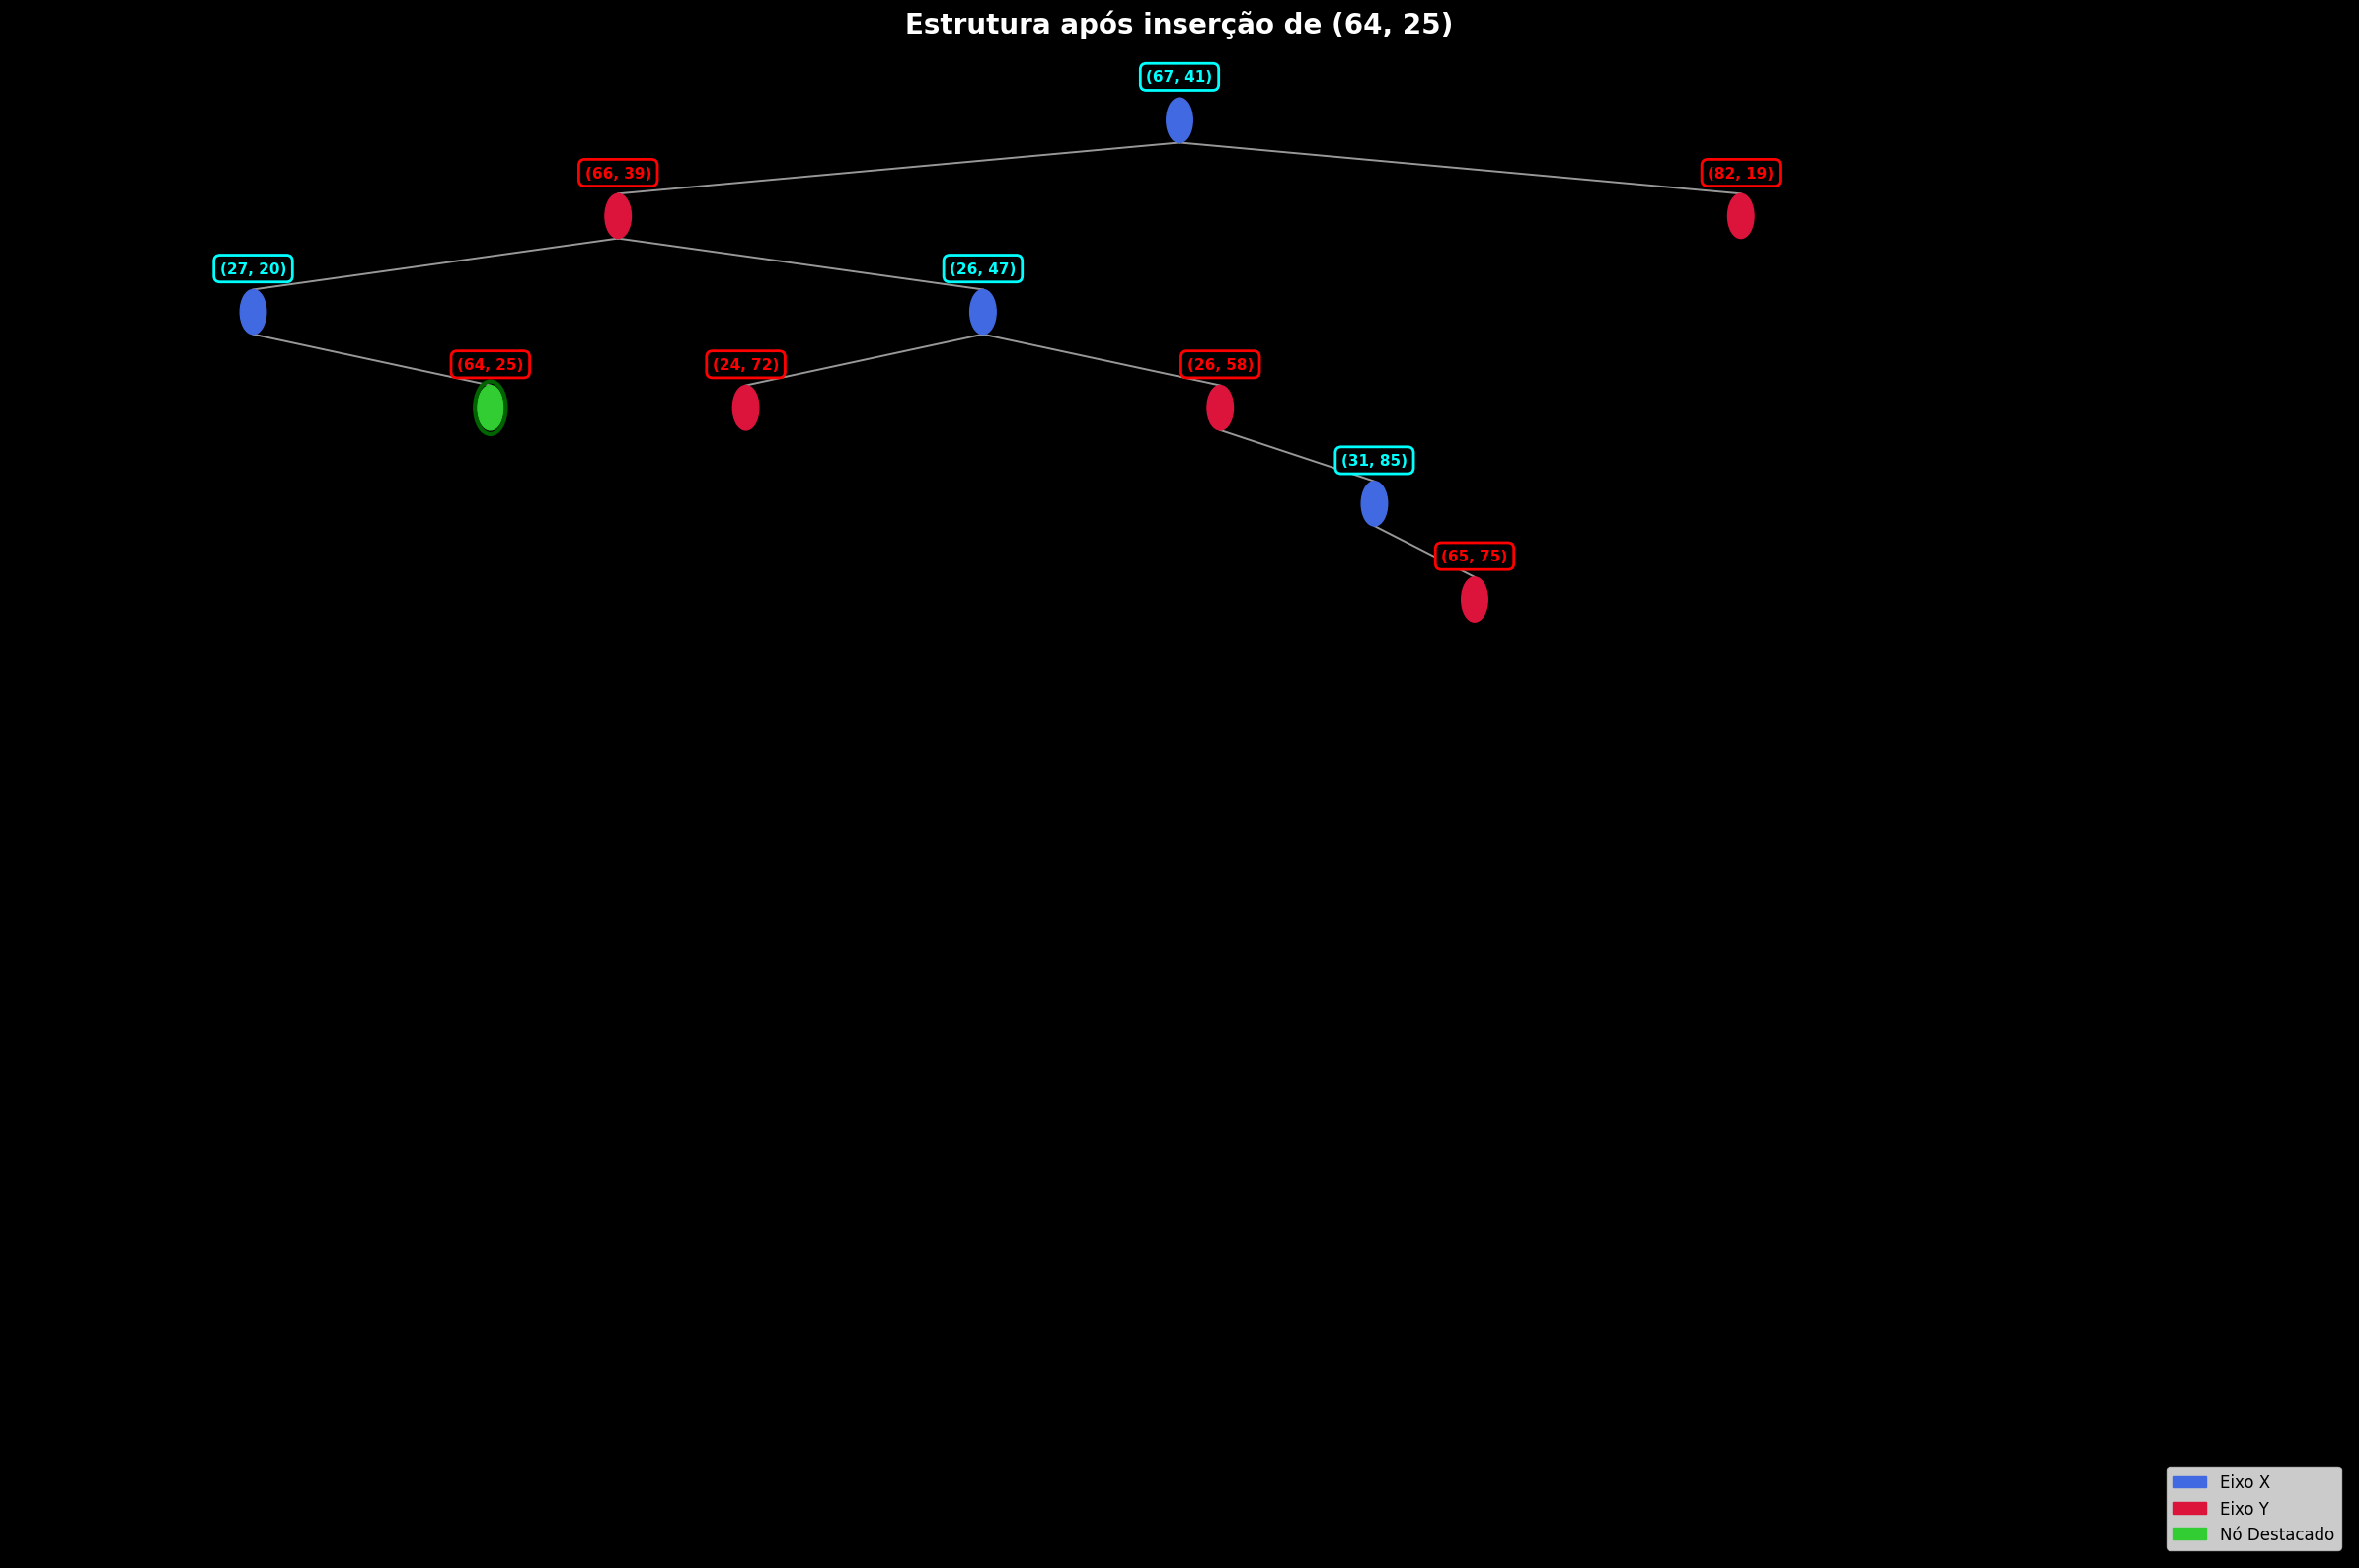

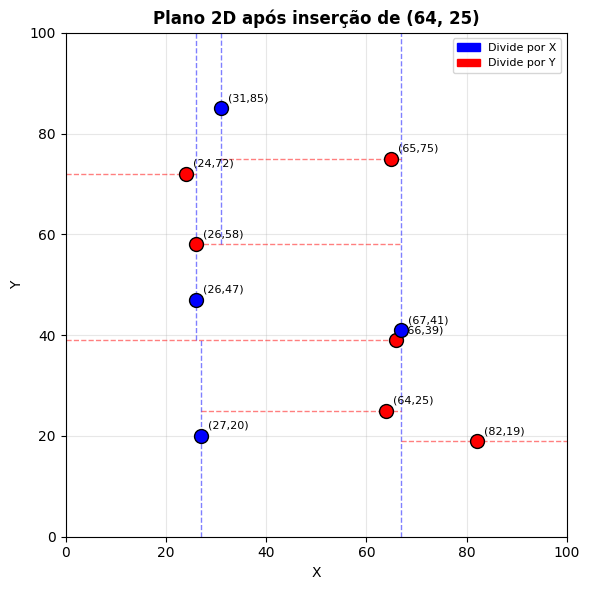


📥 INSERINDO: (71, 87)
  → Comparando 71 com 67 (eixo X), indo para DIREITA
  → Comparando 87 com 19 (eixo Y), indo para DIREITA
  → Criando nó (71, 87) (divide por X)


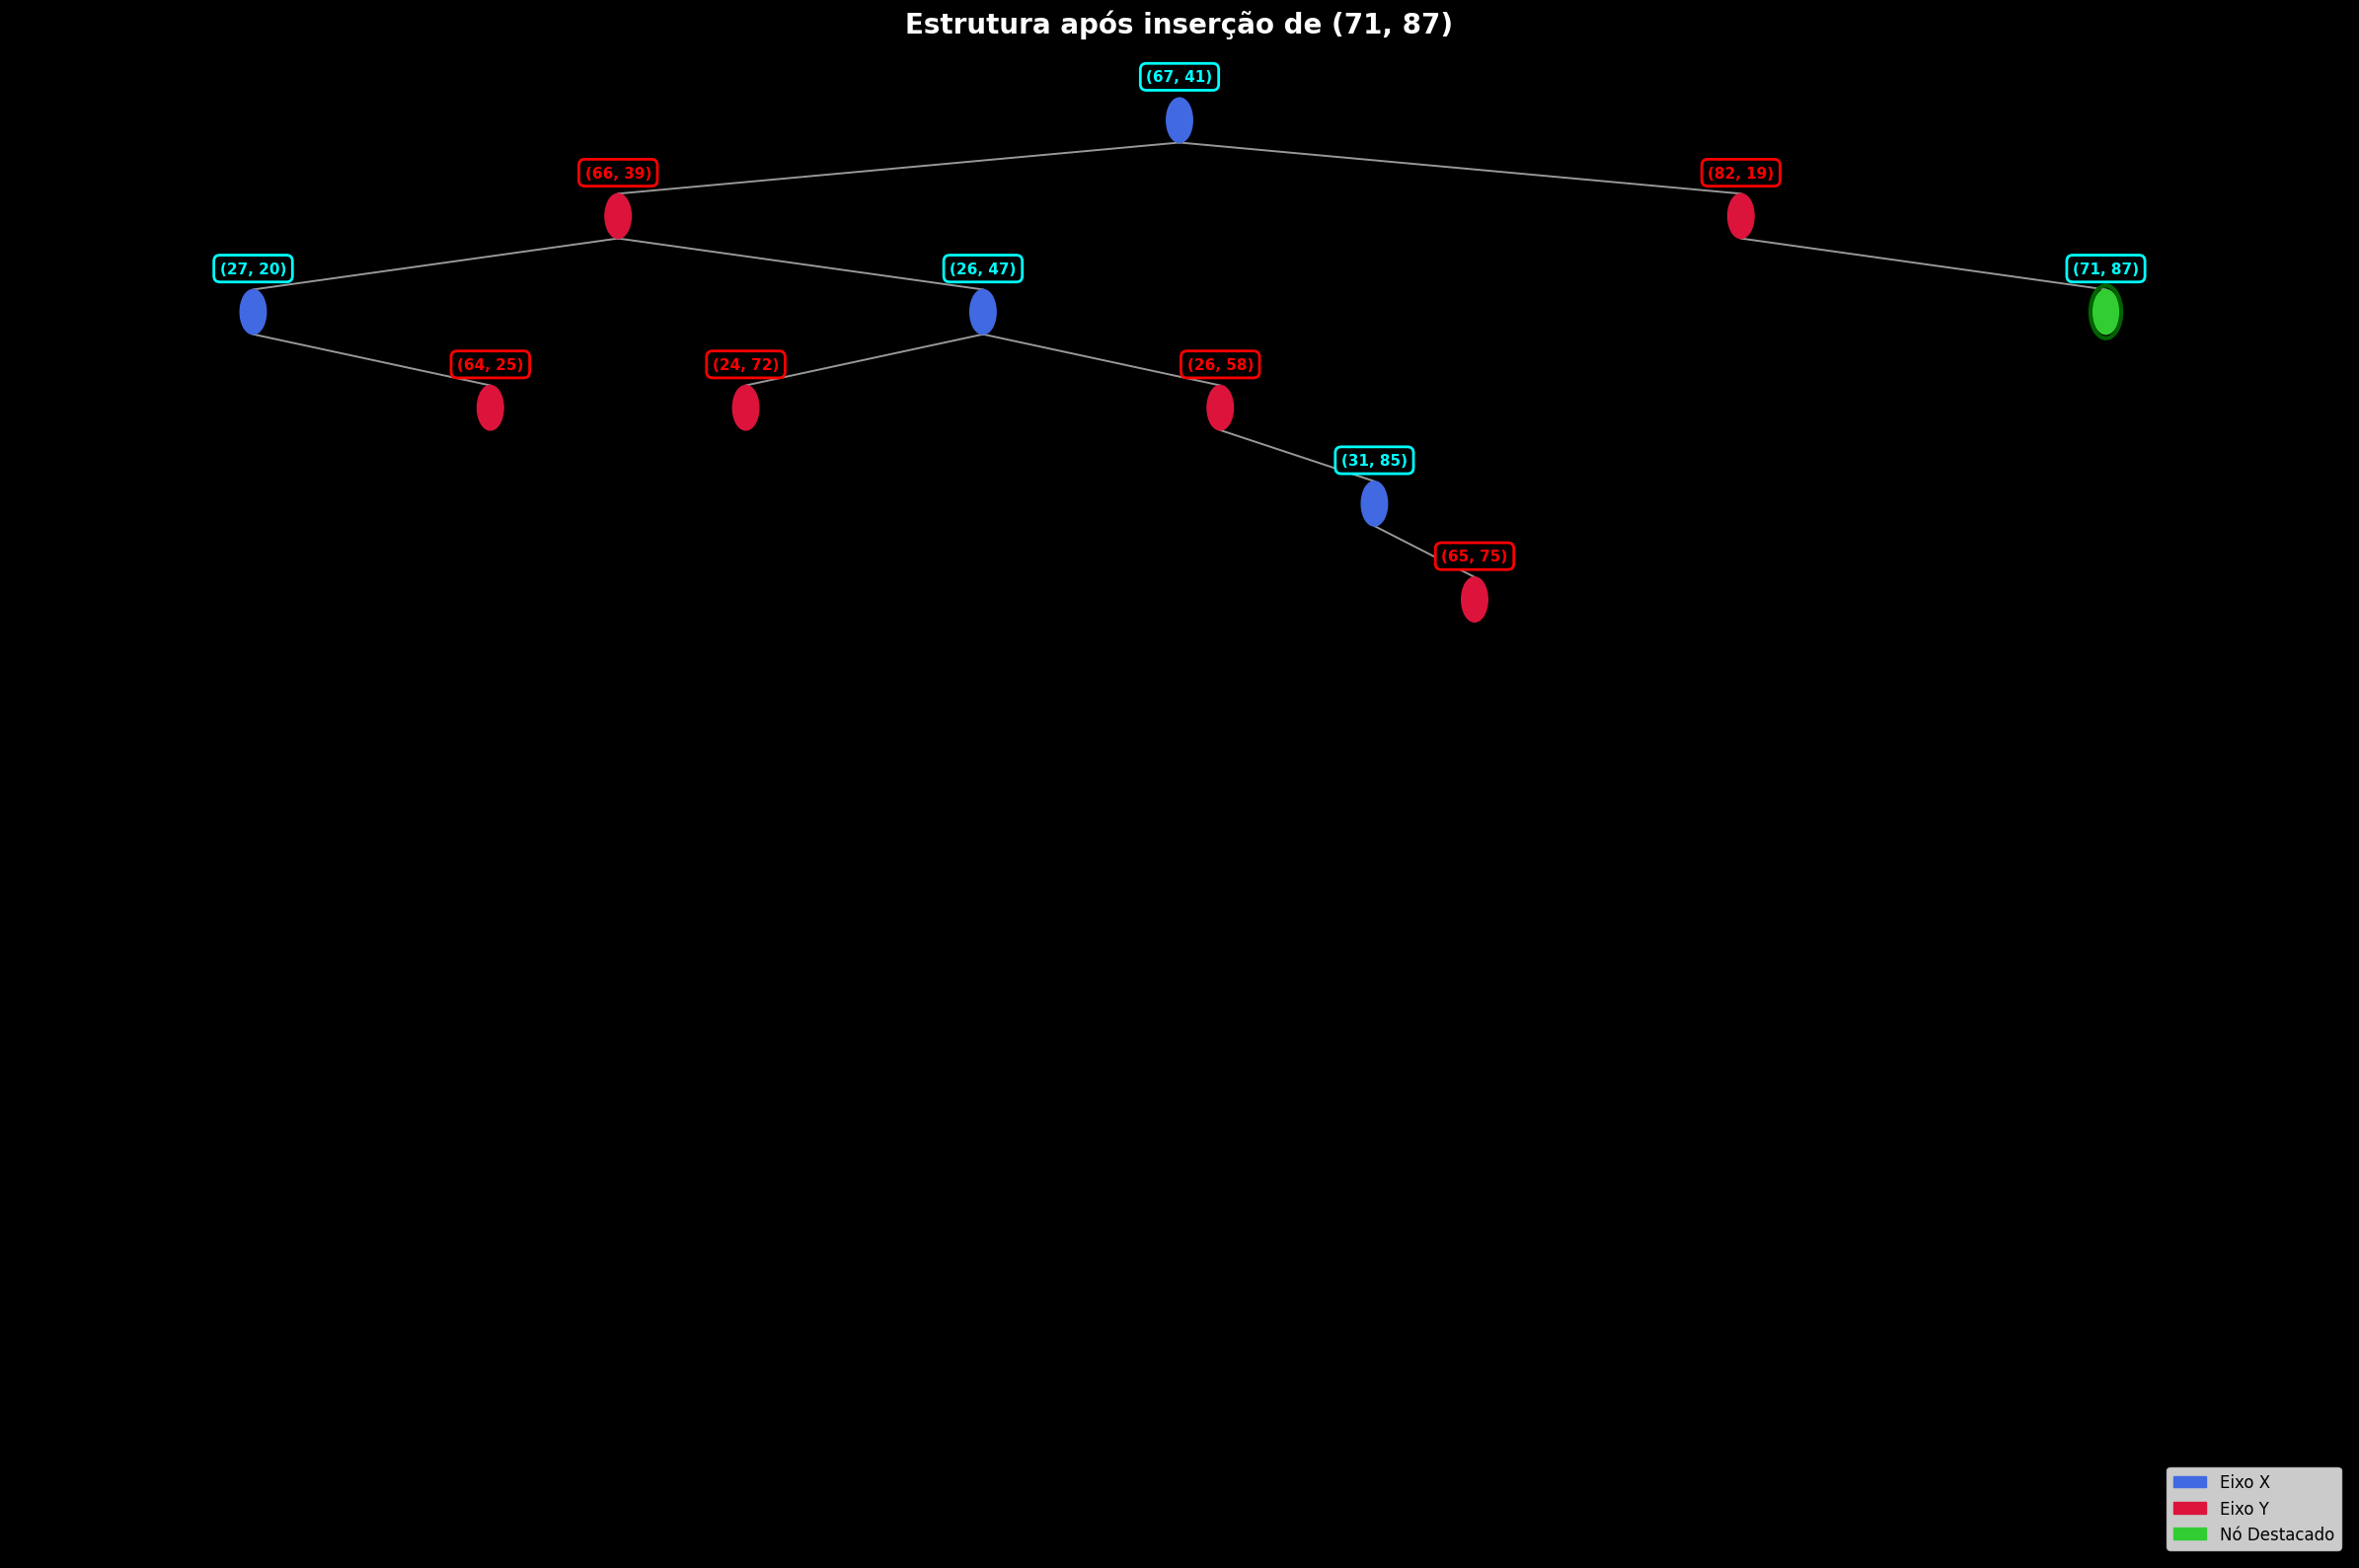

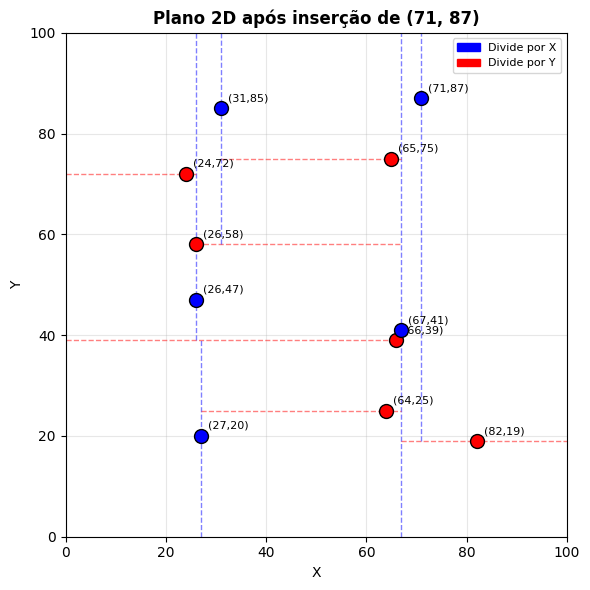


📥 INSERINDO: (75, 58)
  → Comparando 75 com 67 (eixo X), indo para DIREITA
  → Comparando 58 com 19 (eixo Y), indo para DIREITA
  → Comparando 75 com 71 (eixo X), indo para DIREITA
  → Criando nó (75, 58) (divide por Y)


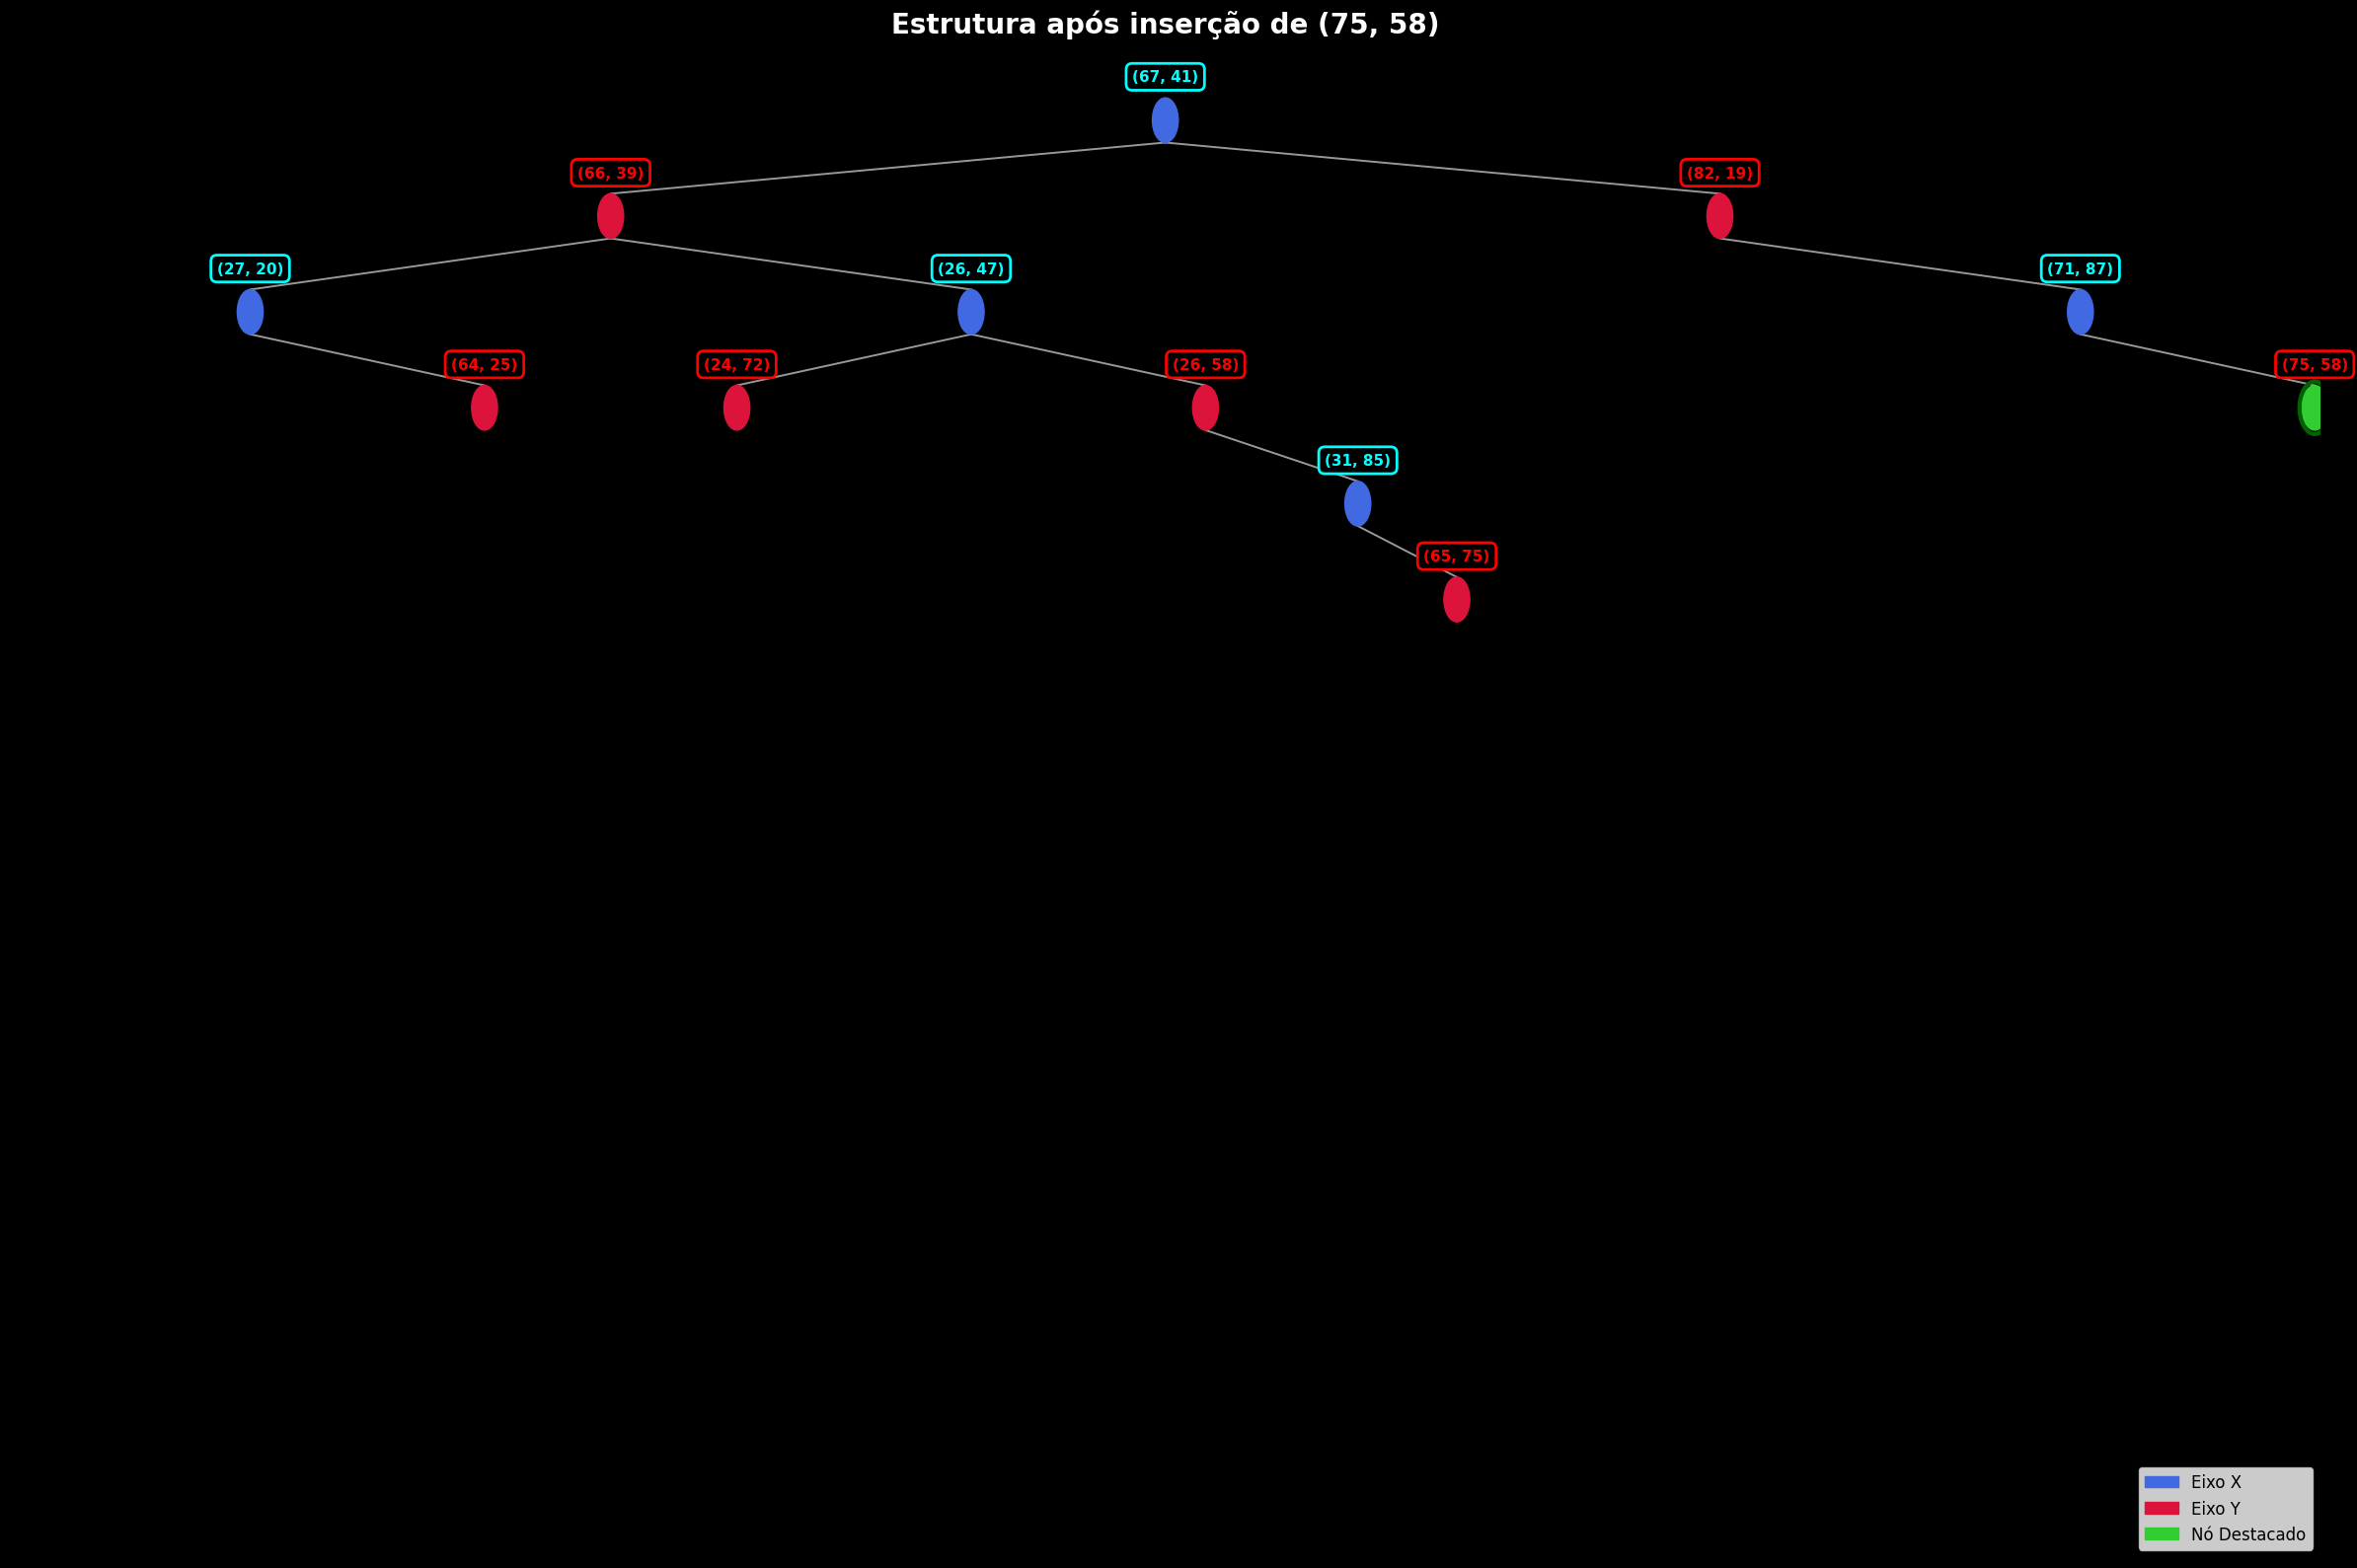

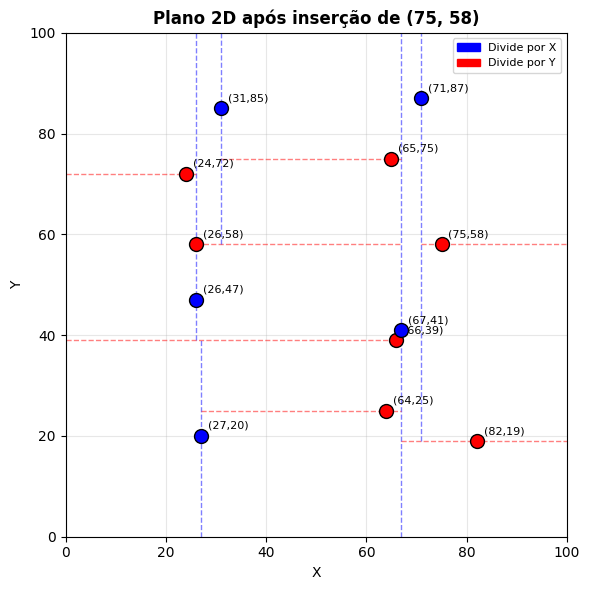


📥 INSERINDO: (35, 89)
  → Comparando 35 com 67 (eixo X), indo para ESQUERDA
  → Comparando 89 com 39 (eixo Y), indo para DIREITA
  → Comparando 35 com 26 (eixo X), indo para DIREITA
  → Comparando 89 com 58 (eixo Y), indo para DIREITA
  → Comparando 35 com 31 (eixo X), indo para DIREITA
  → Comparando 89 com 75 (eixo Y), indo para DIREITA
  → Criando nó (35, 89) (divide por X)


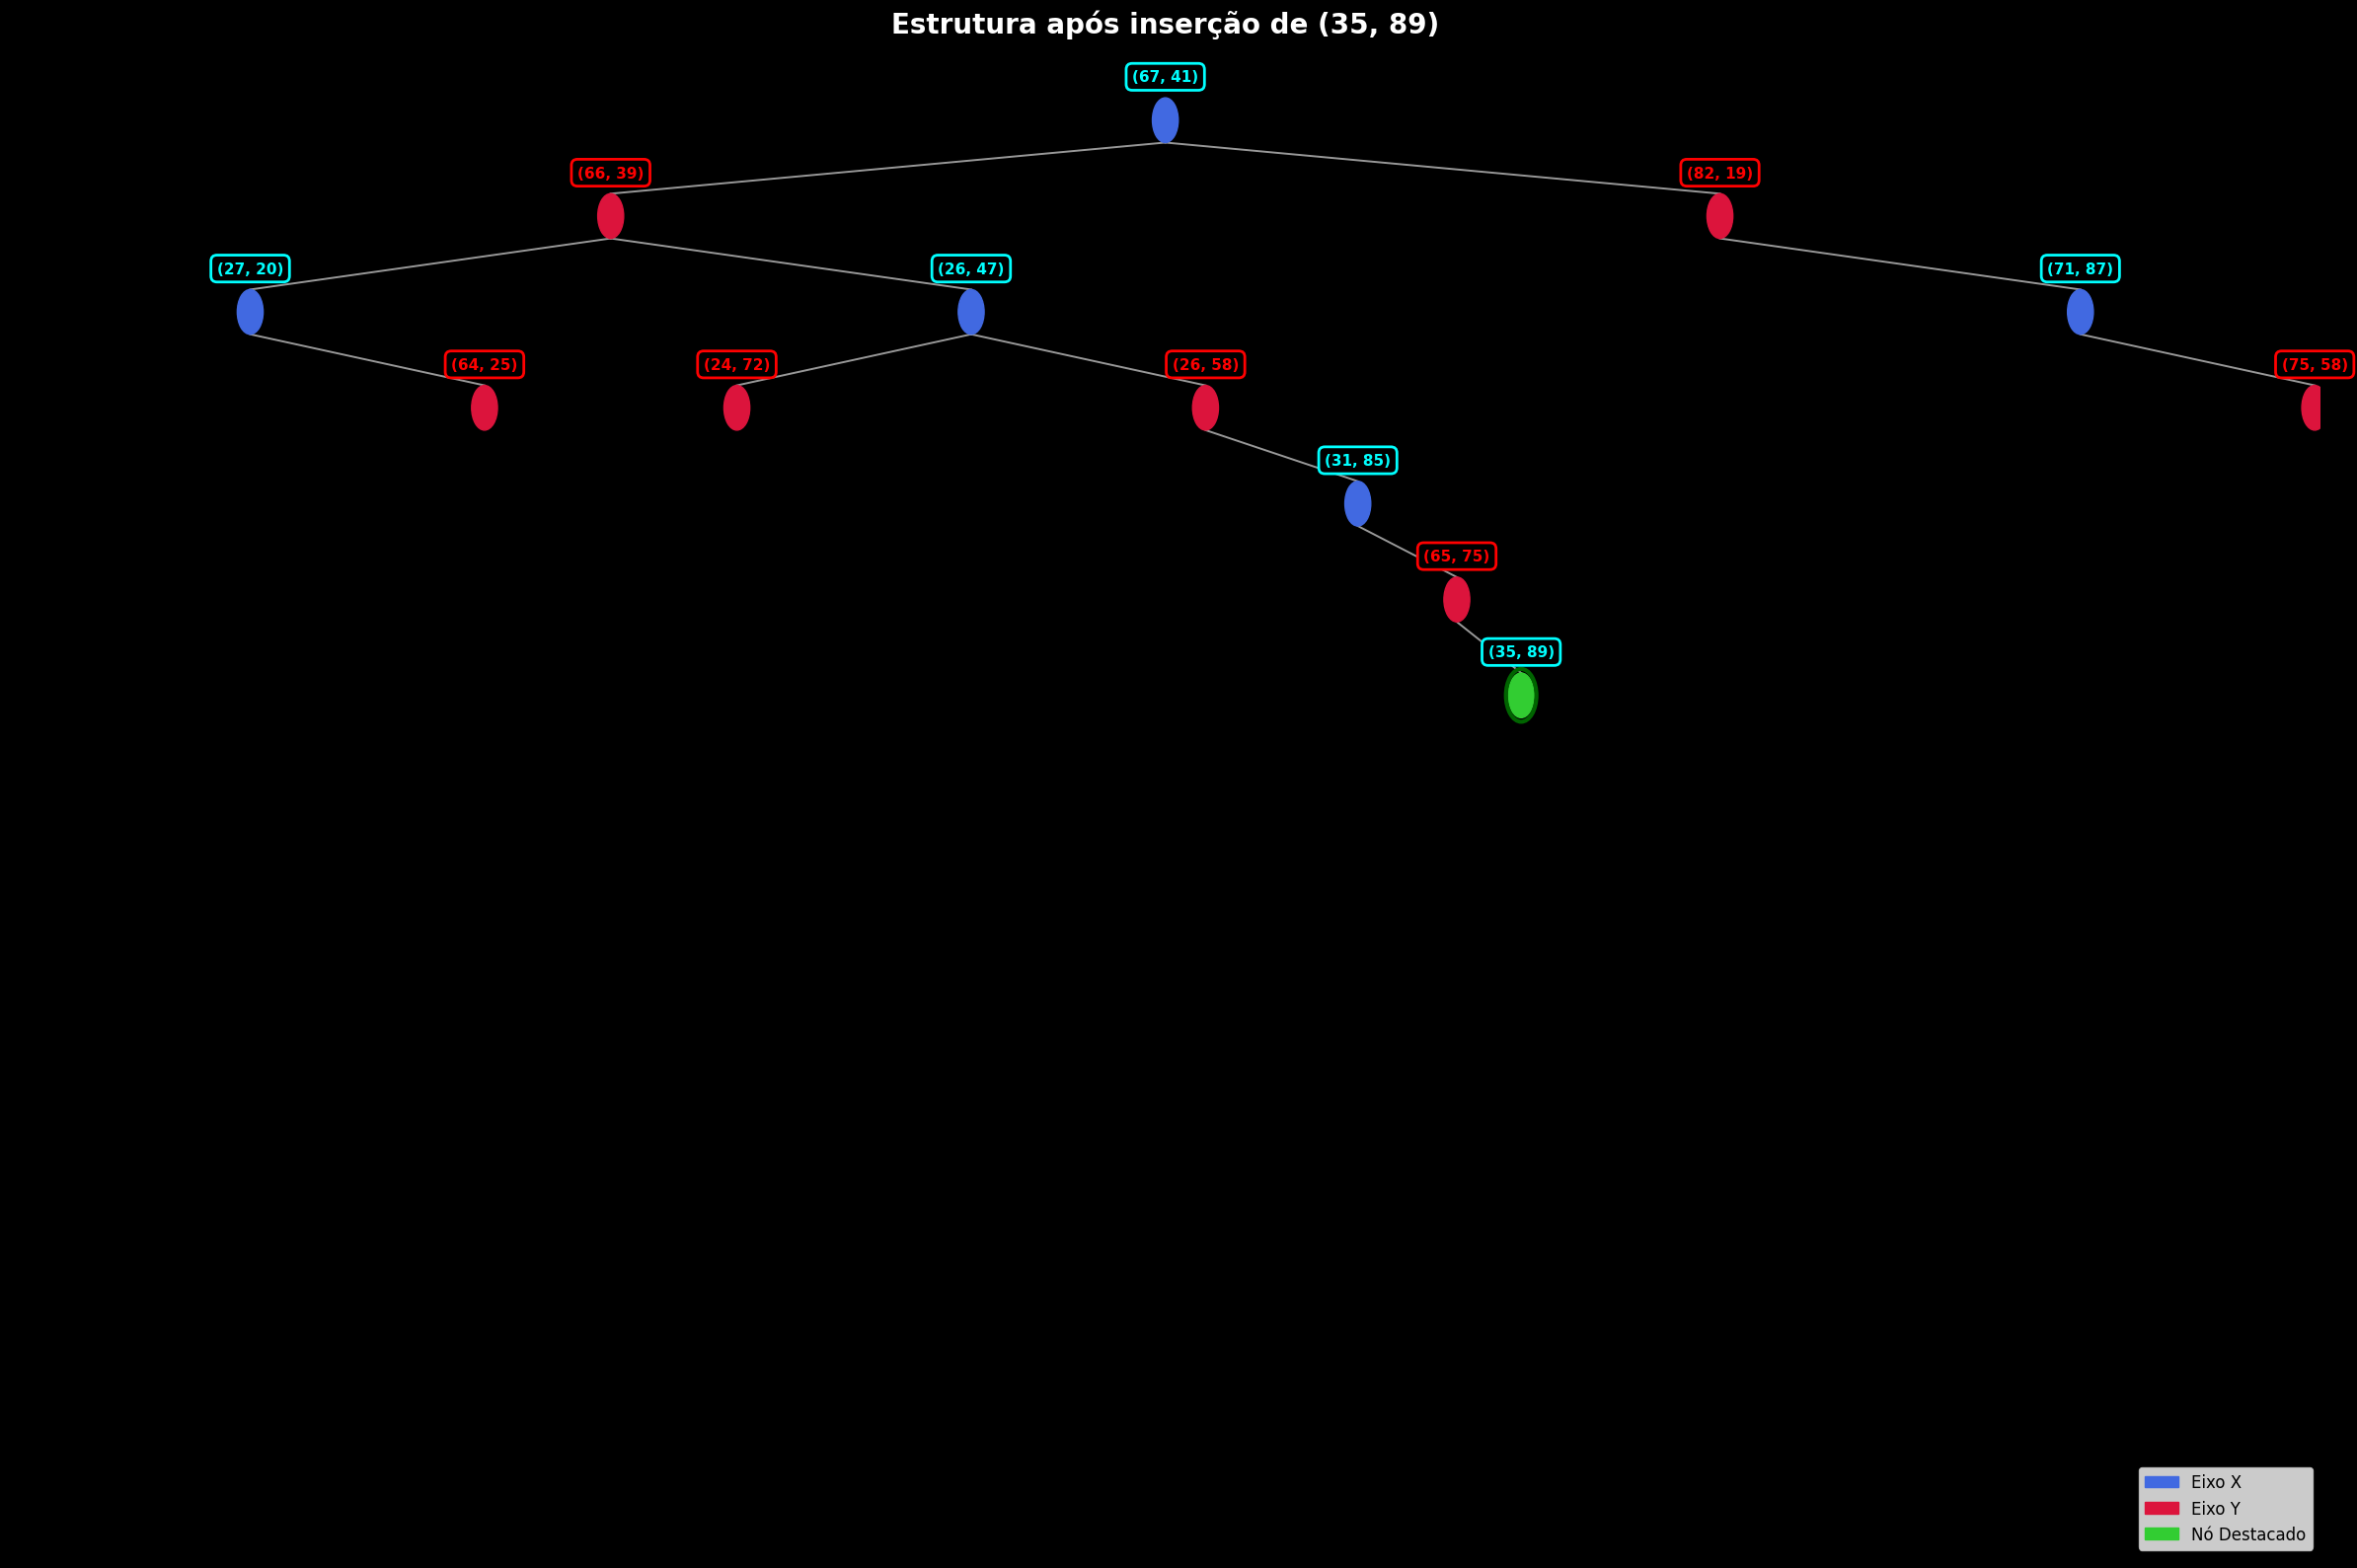

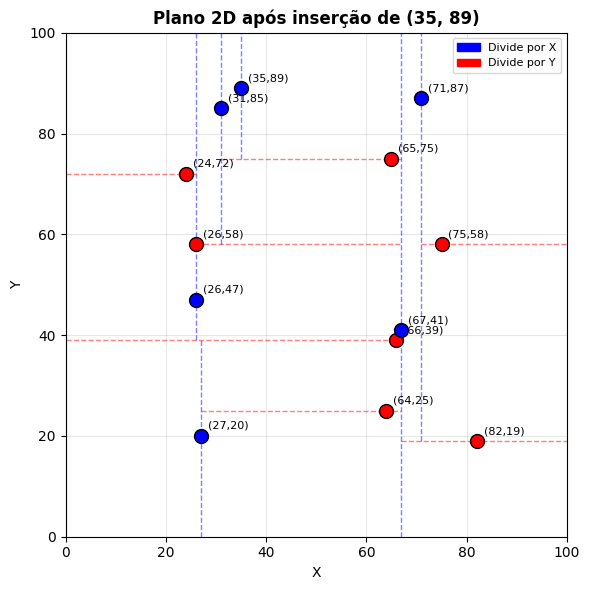


📥 INSERINDO: (86, 15)
  → Comparando 86 com 67 (eixo X), indo para DIREITA
  → Comparando 15 com 19 (eixo Y), indo para ESQUERDA
  → Criando nó (86, 15) (divide por X)


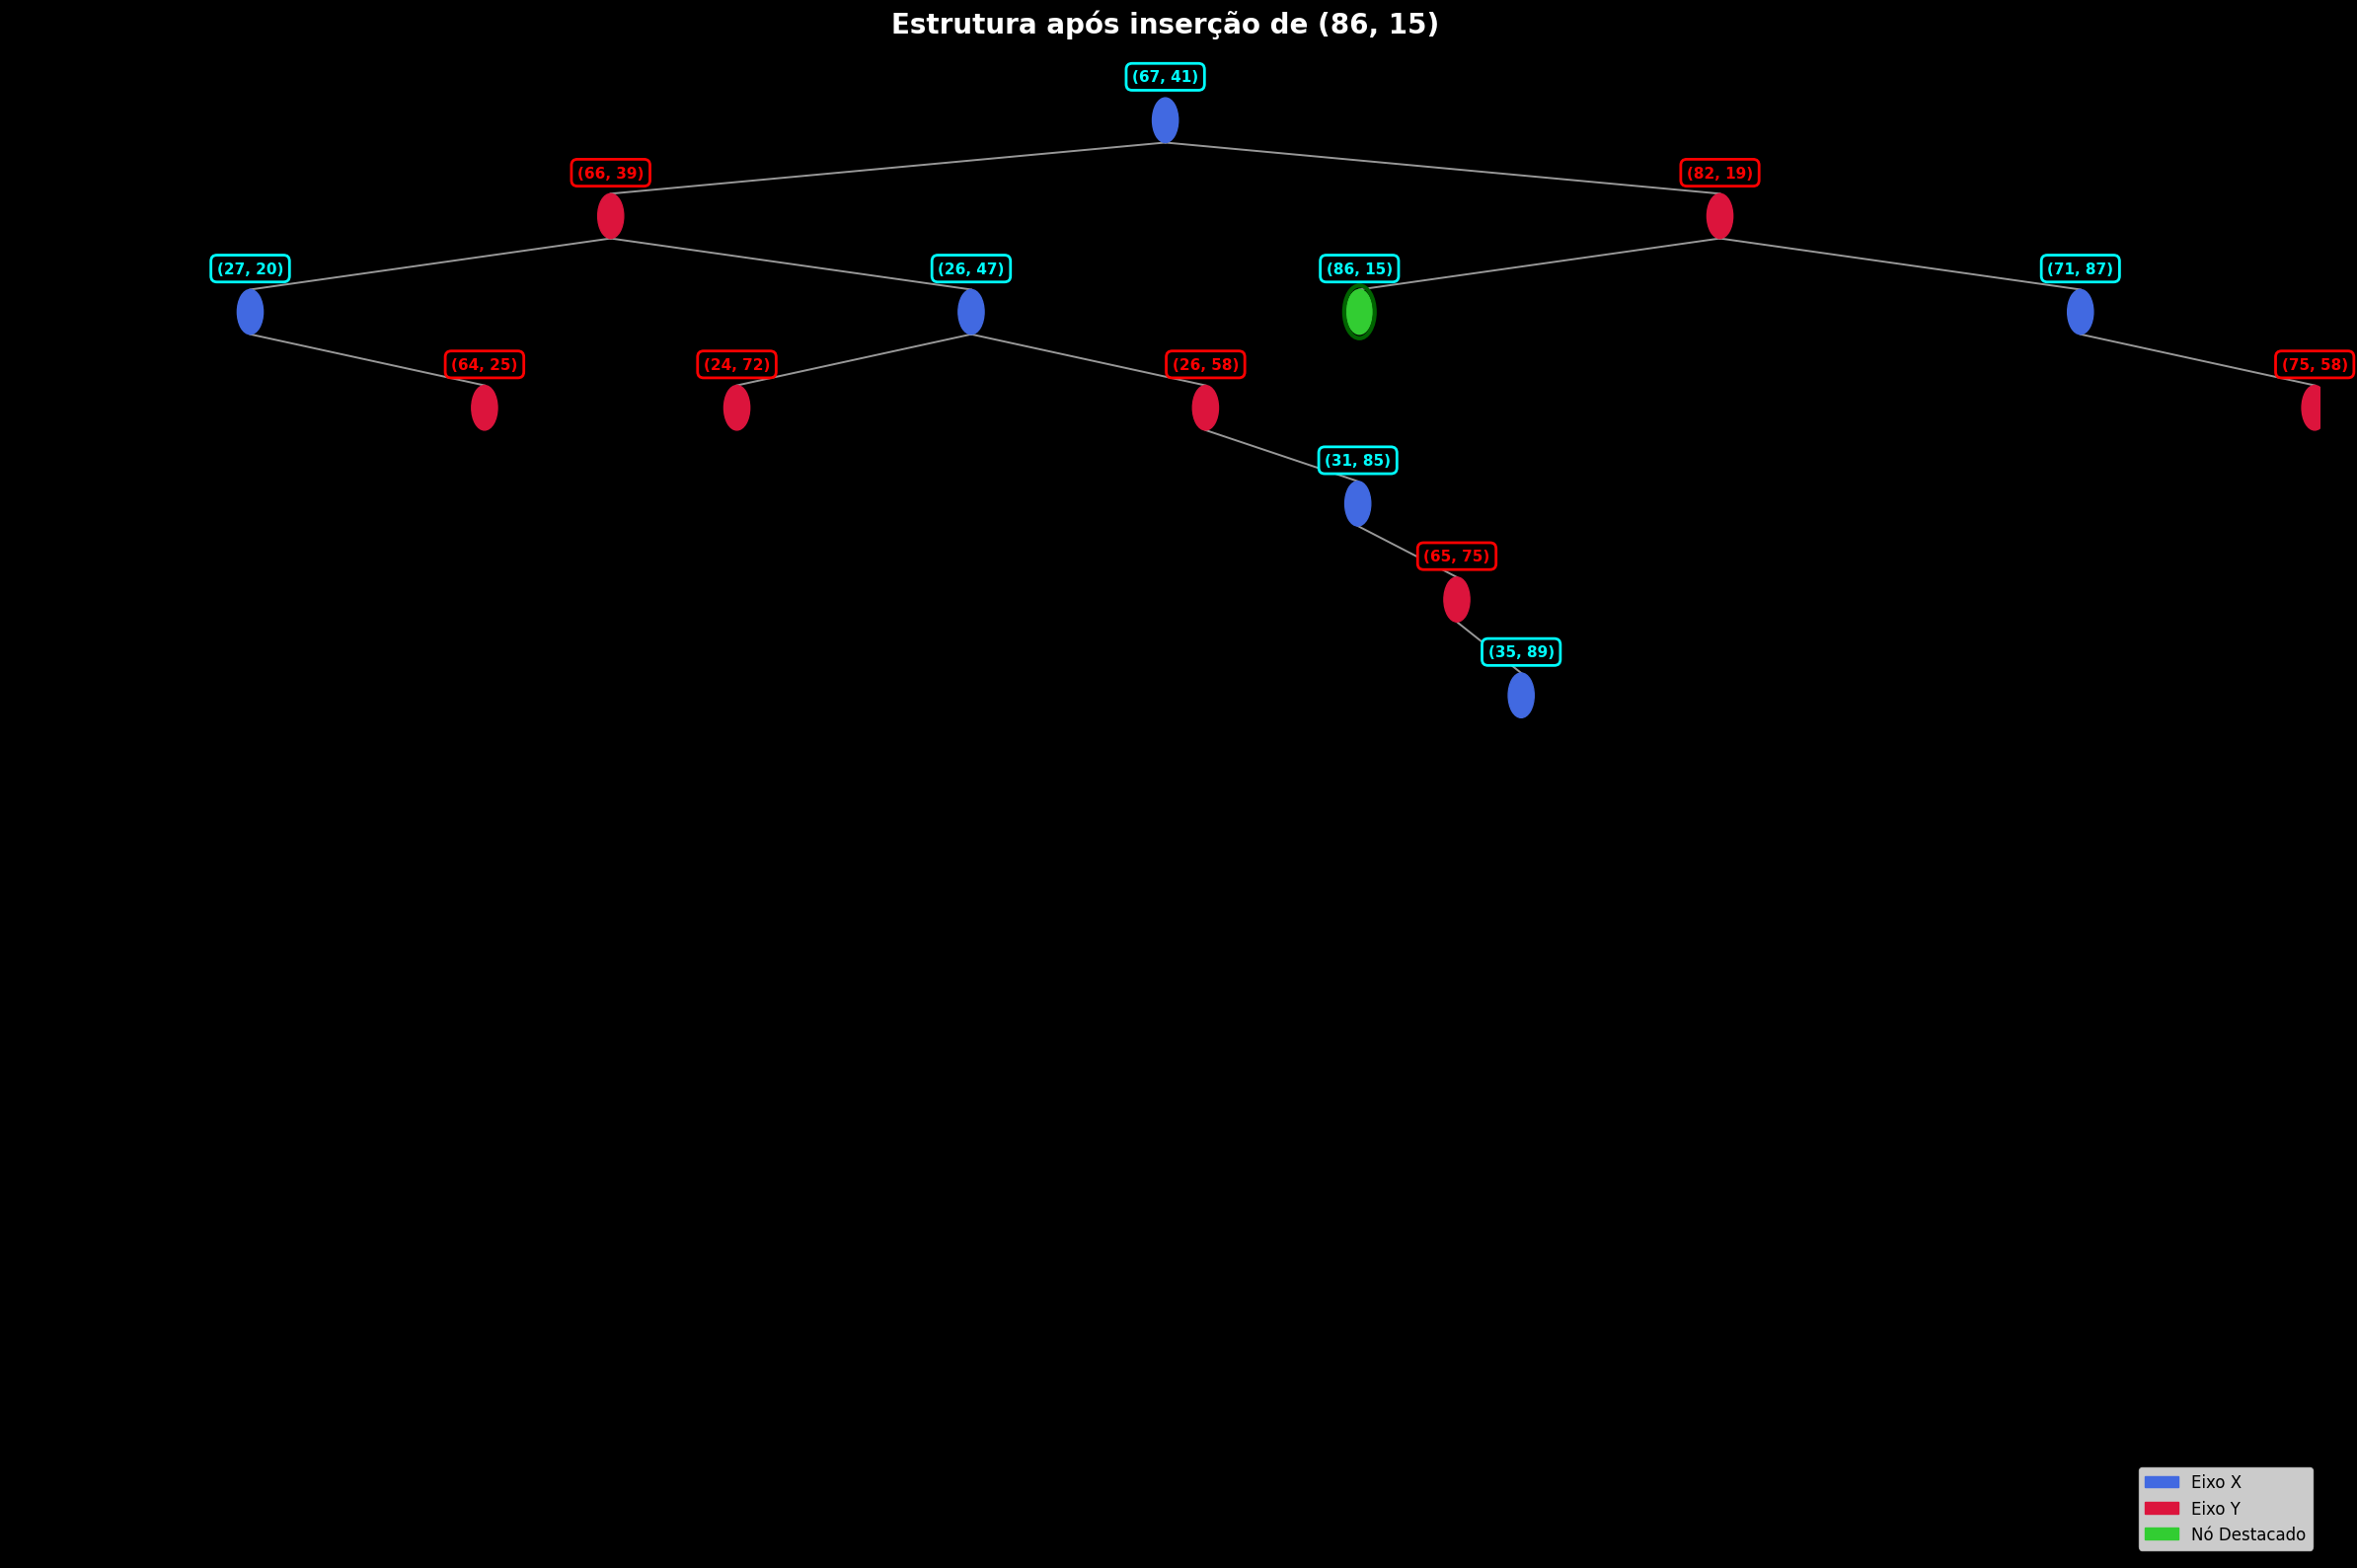

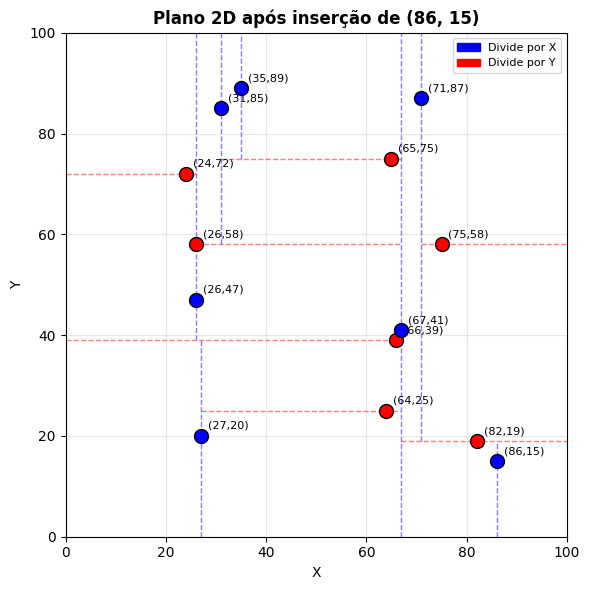


📥 INSERINDO: (15, 58)
  → Comparando 15 com 67 (eixo X), indo para ESQUERDA
  → Comparando 58 com 39 (eixo Y), indo para DIREITA
  → Comparando 15 com 26 (eixo X), indo para ESQUERDA
  → Comparando 58 com 72 (eixo Y), indo para ESQUERDA
  → Criando nó (15, 58) (divide por X)


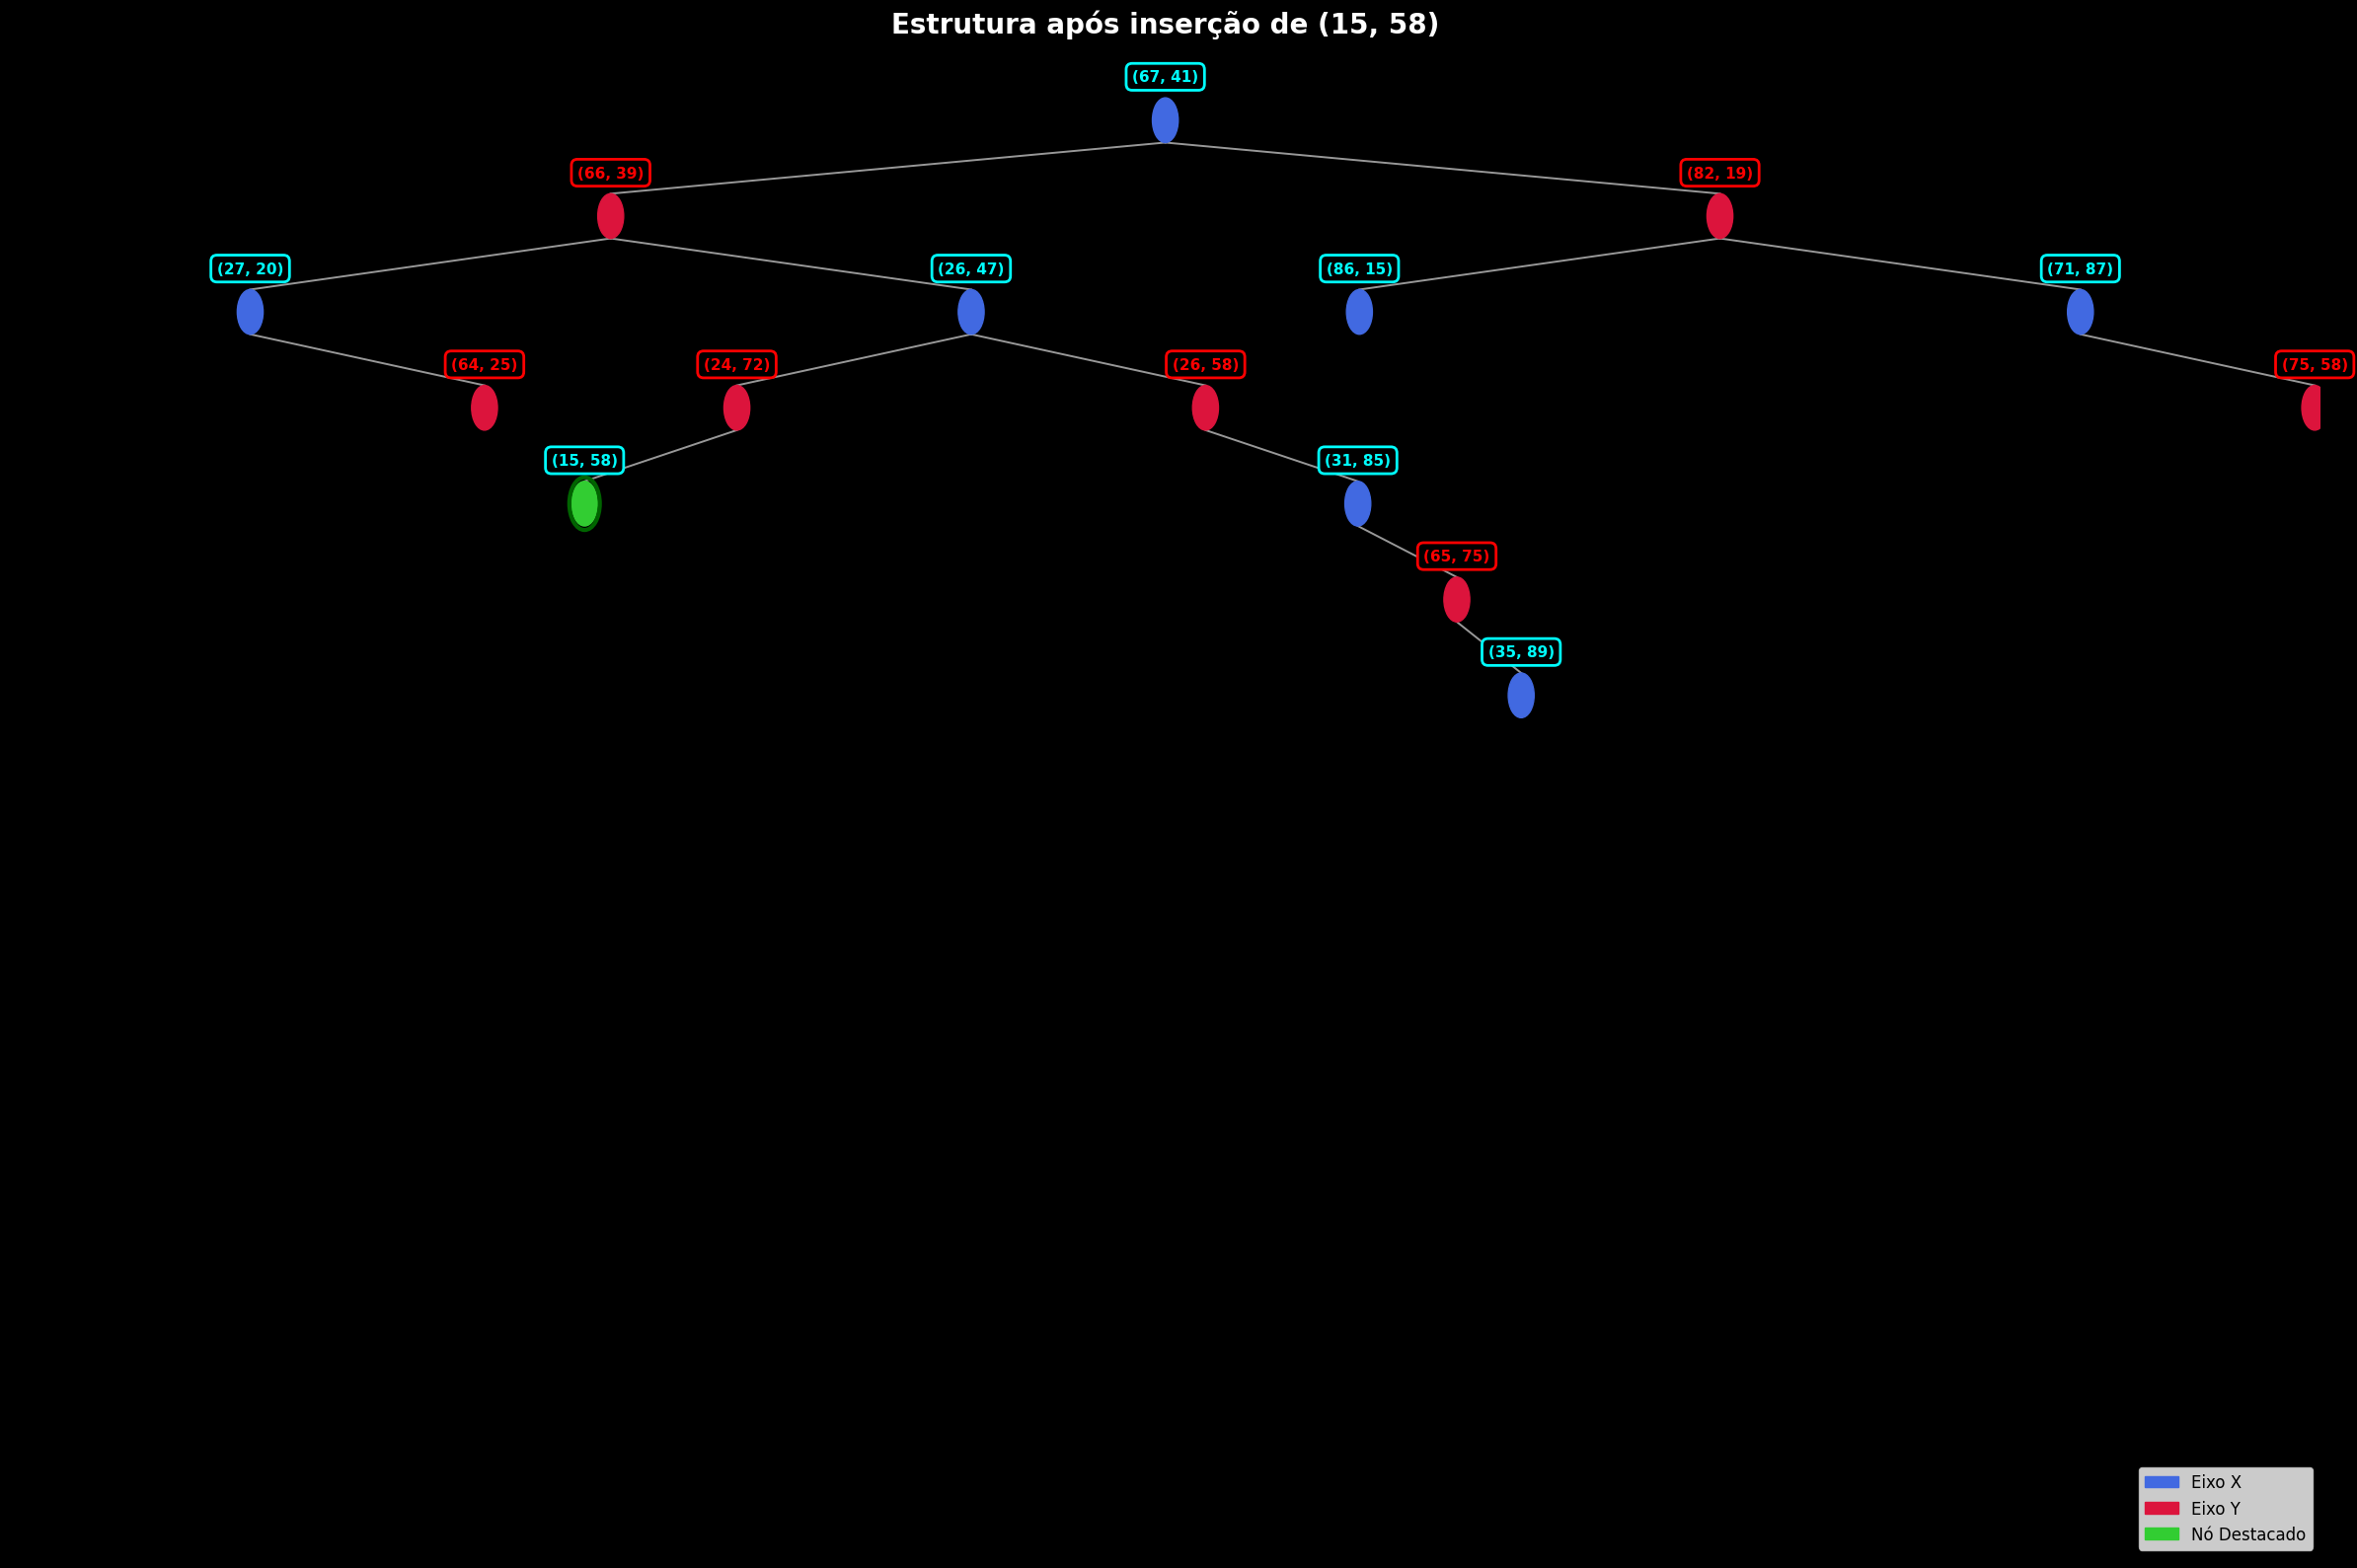

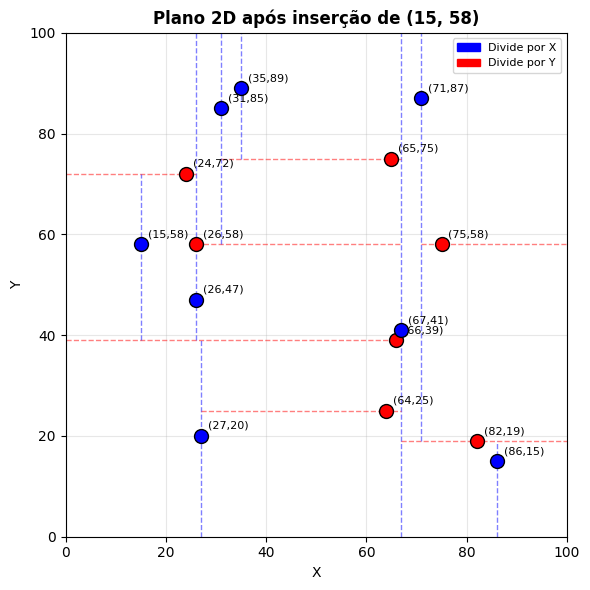


📥 INSERINDO: (12, 60)
  → Comparando 12 com 67 (eixo X), indo para ESQUERDA
  → Comparando 60 com 39 (eixo Y), indo para DIREITA
  → Comparando 12 com 26 (eixo X), indo para ESQUERDA
  → Comparando 60 com 72 (eixo Y), indo para ESQUERDA
  → Comparando 12 com 15 (eixo X), indo para ESQUERDA
  → Criando nó (12, 60) (divide por Y)


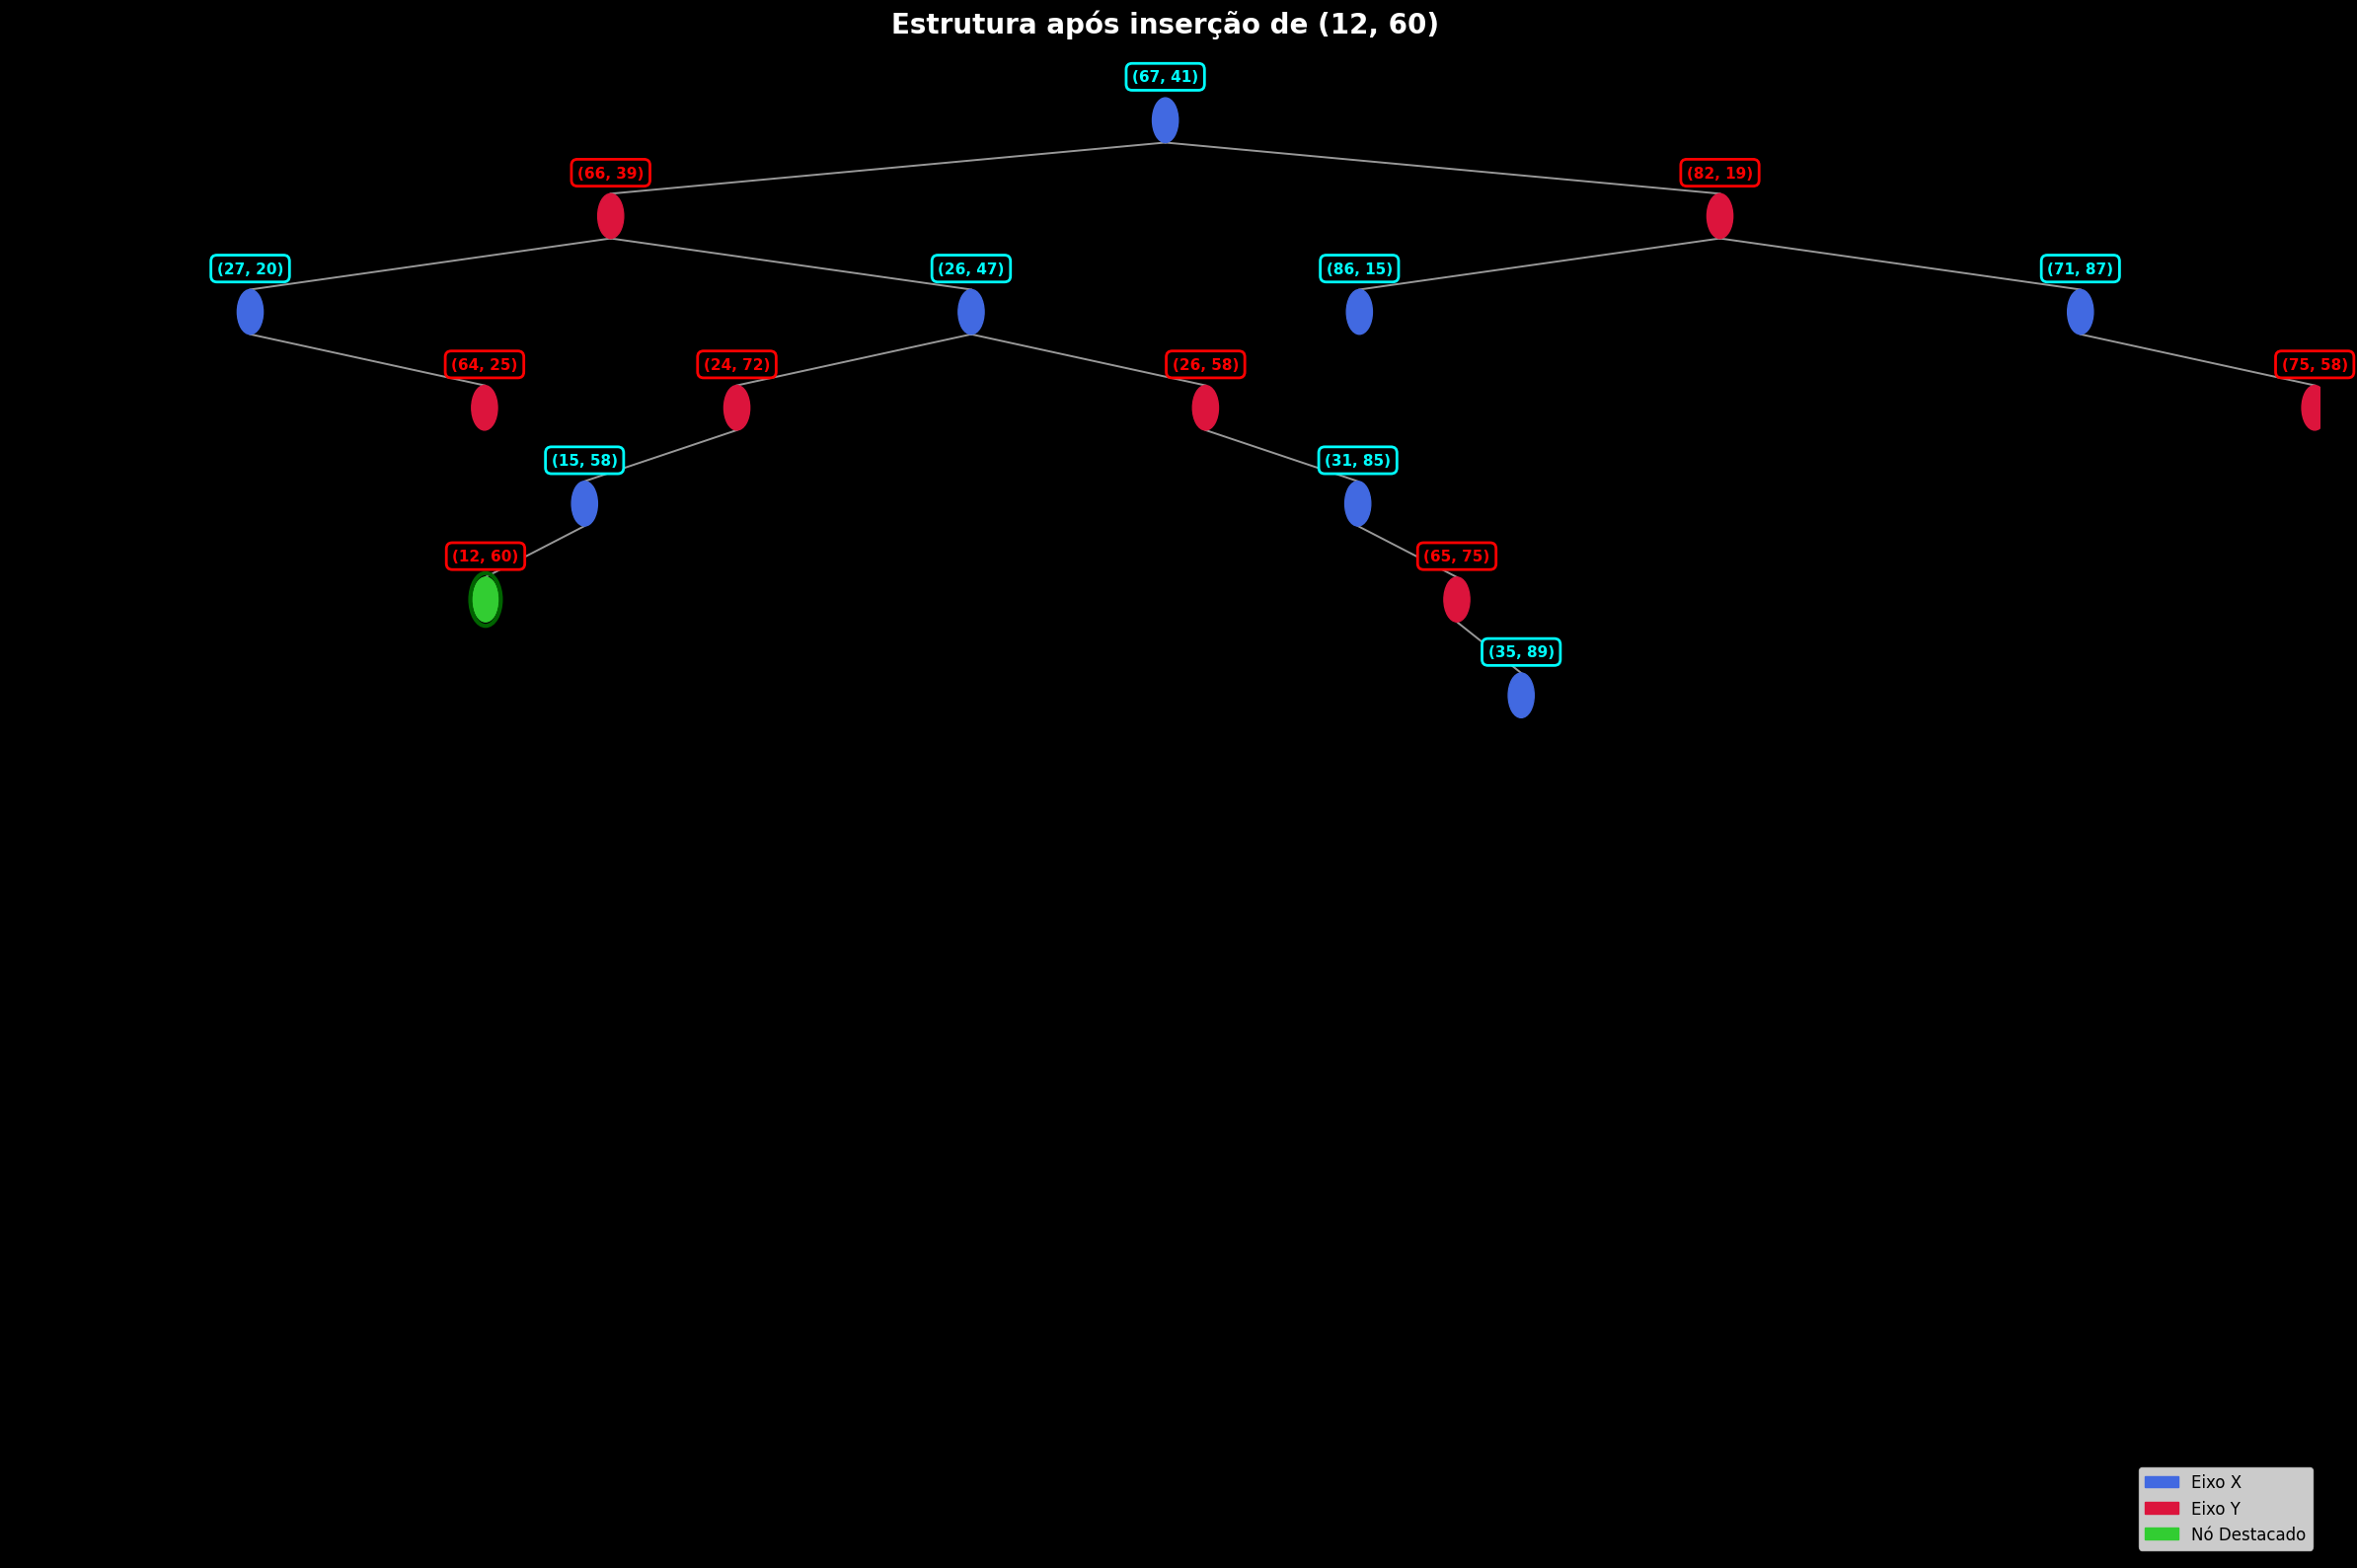

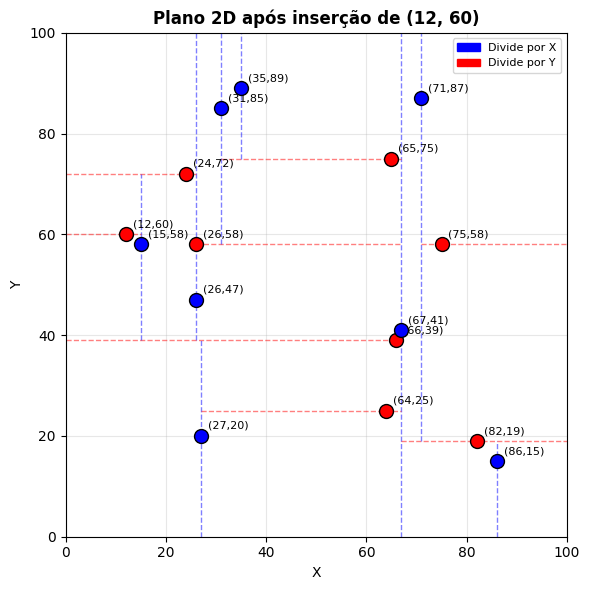


📥 INSERINDO: (33, 69)
  → Comparando 33 com 67 (eixo X), indo para ESQUERDA
  → Comparando 69 com 39 (eixo Y), indo para DIREITA
  → Comparando 33 com 26 (eixo X), indo para DIREITA
  → Comparando 69 com 58 (eixo Y), indo para DIREITA
  → Comparando 33 com 31 (eixo X), indo para DIREITA
  → Comparando 69 com 75 (eixo Y), indo para ESQUERDA
  → Criando nó (33, 69) (divide por X)


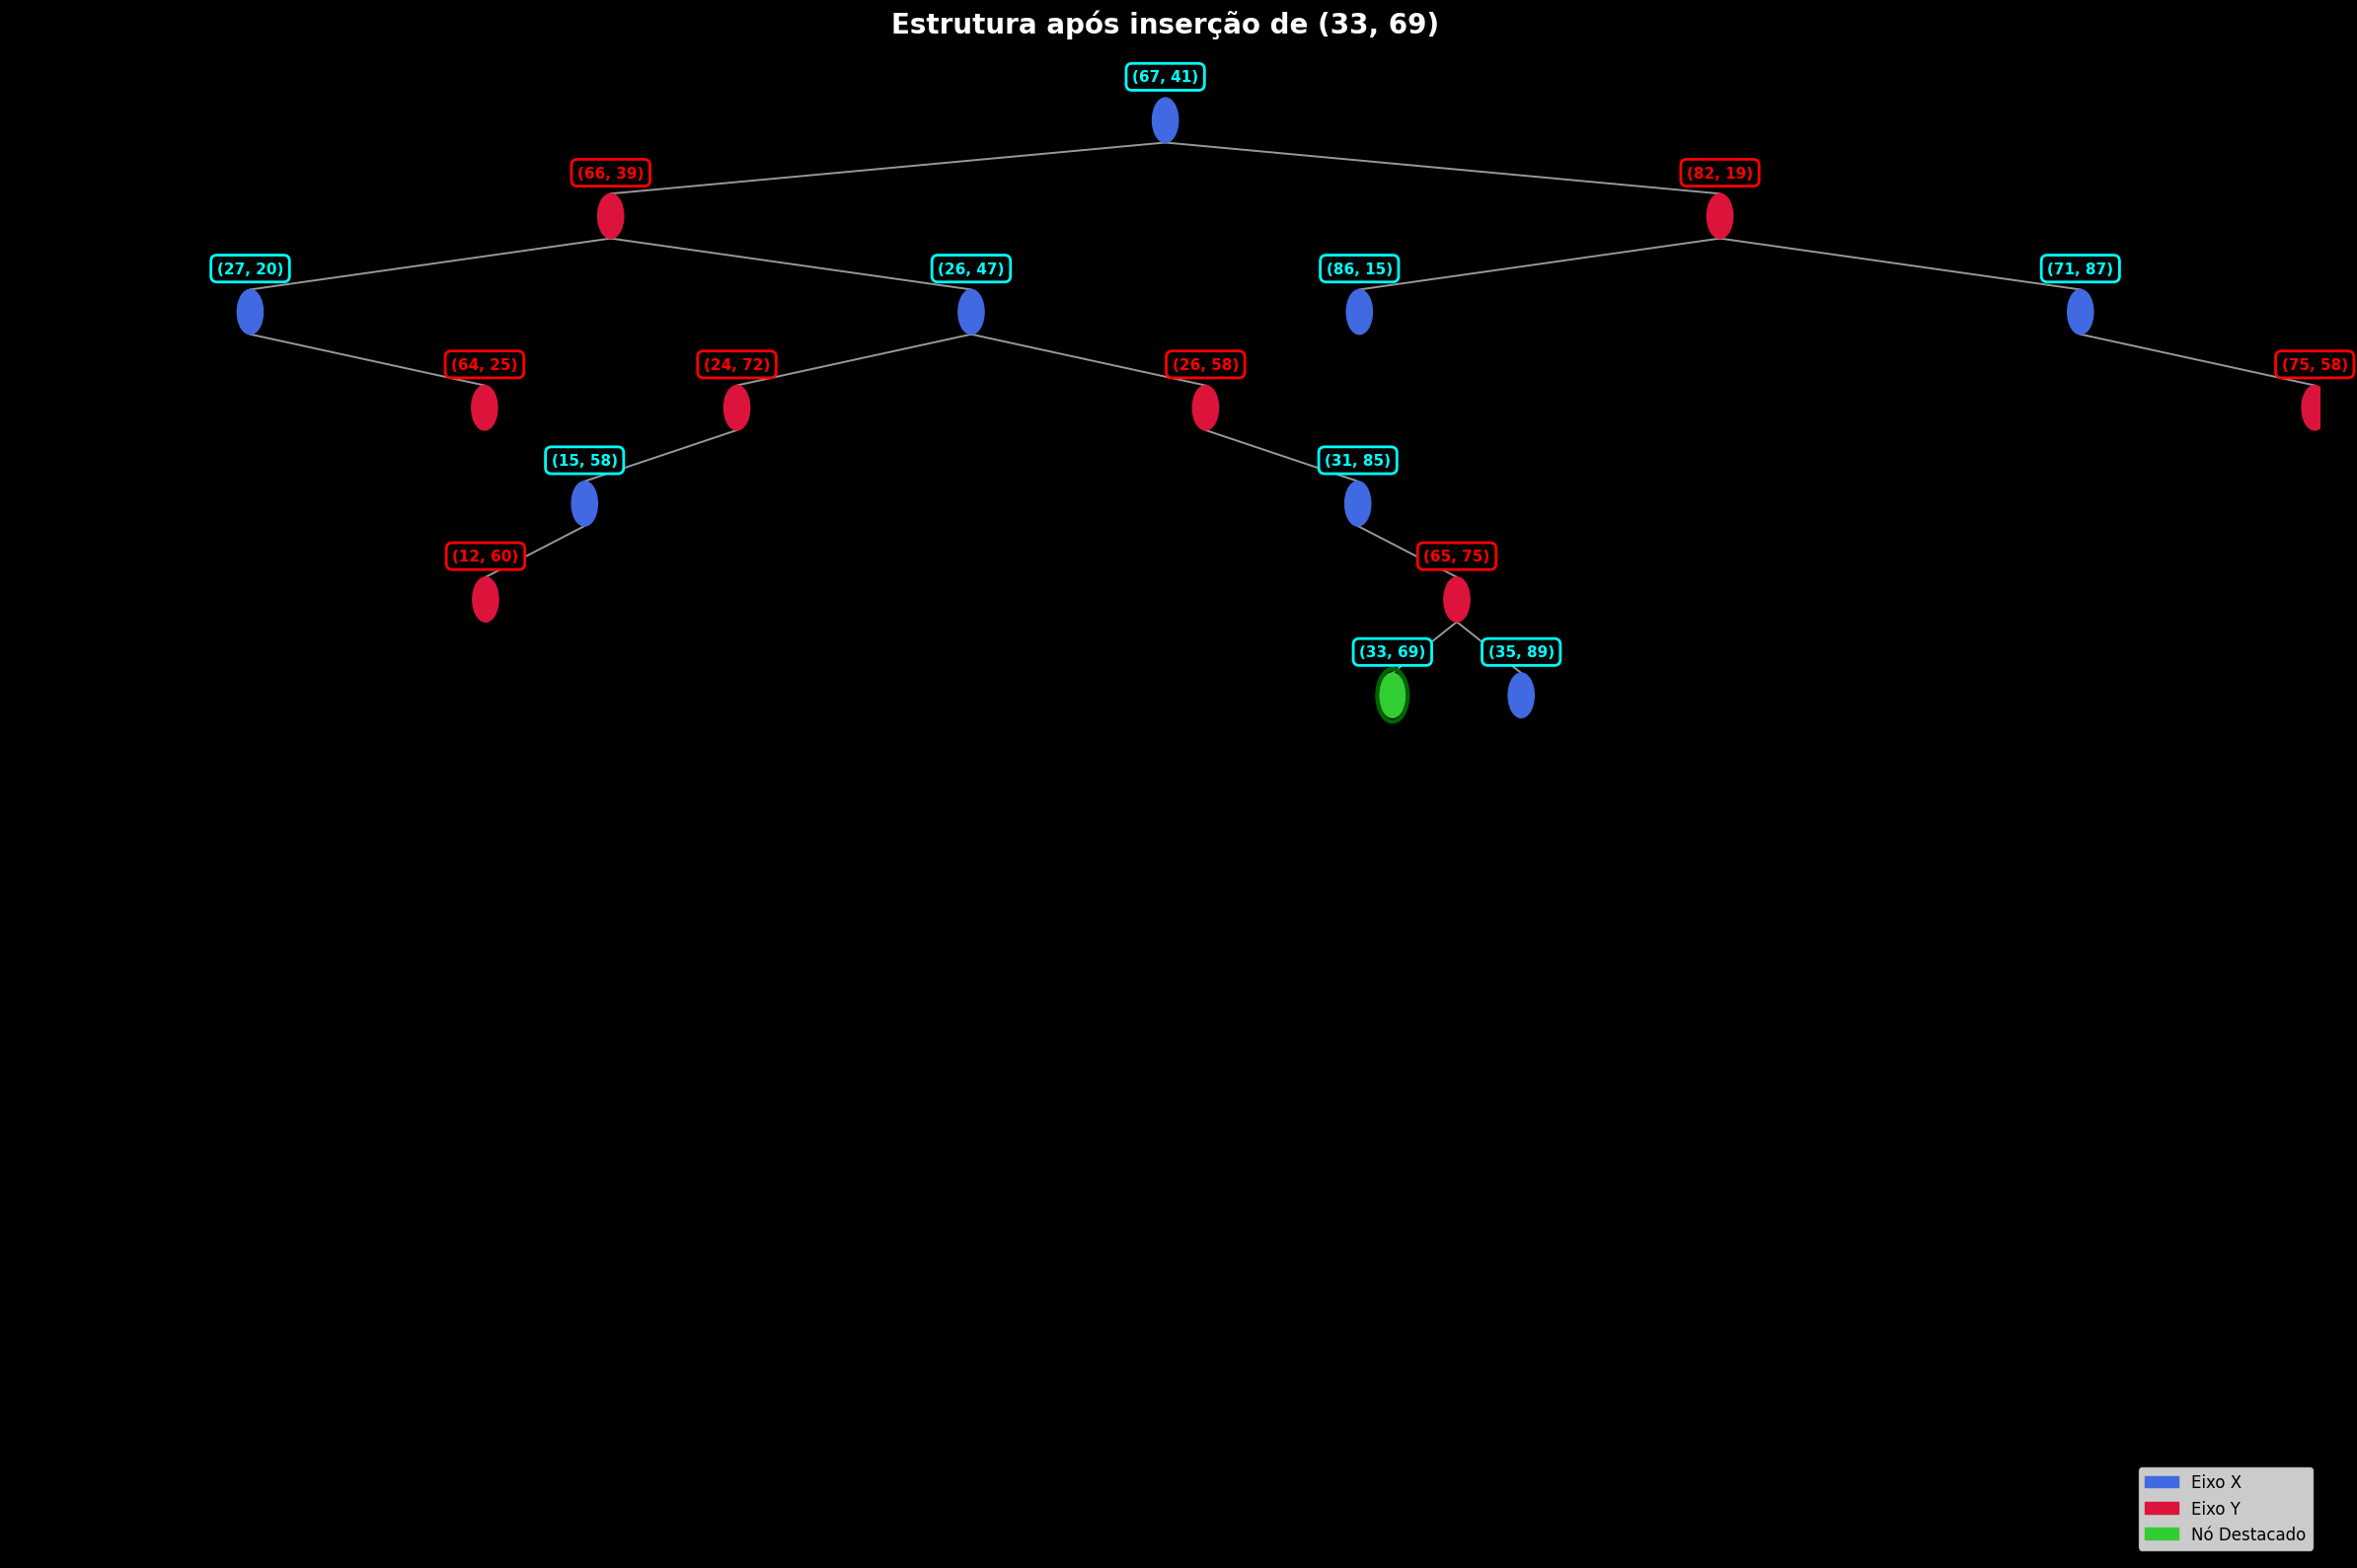

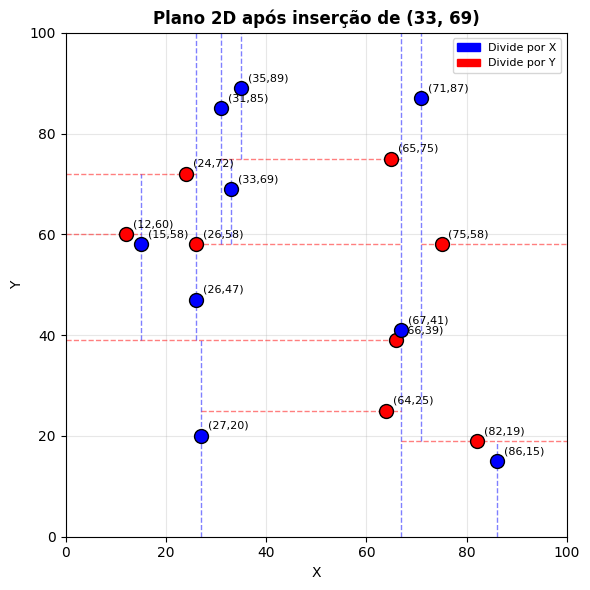


📥 INSERINDO: (65, 84)
  → Comparando 65 com 67 (eixo X), indo para ESQUERDA
  → Comparando 84 com 39 (eixo Y), indo para DIREITA
  → Comparando 65 com 26 (eixo X), indo para DIREITA
  → Comparando 84 com 58 (eixo Y), indo para DIREITA
  → Comparando 65 com 31 (eixo X), indo para DIREITA
  → Comparando 84 com 75 (eixo Y), indo para DIREITA
  → Comparando 65 com 35 (eixo X), indo para DIREITA
  → Criando nó (65, 84) (divide por Y)


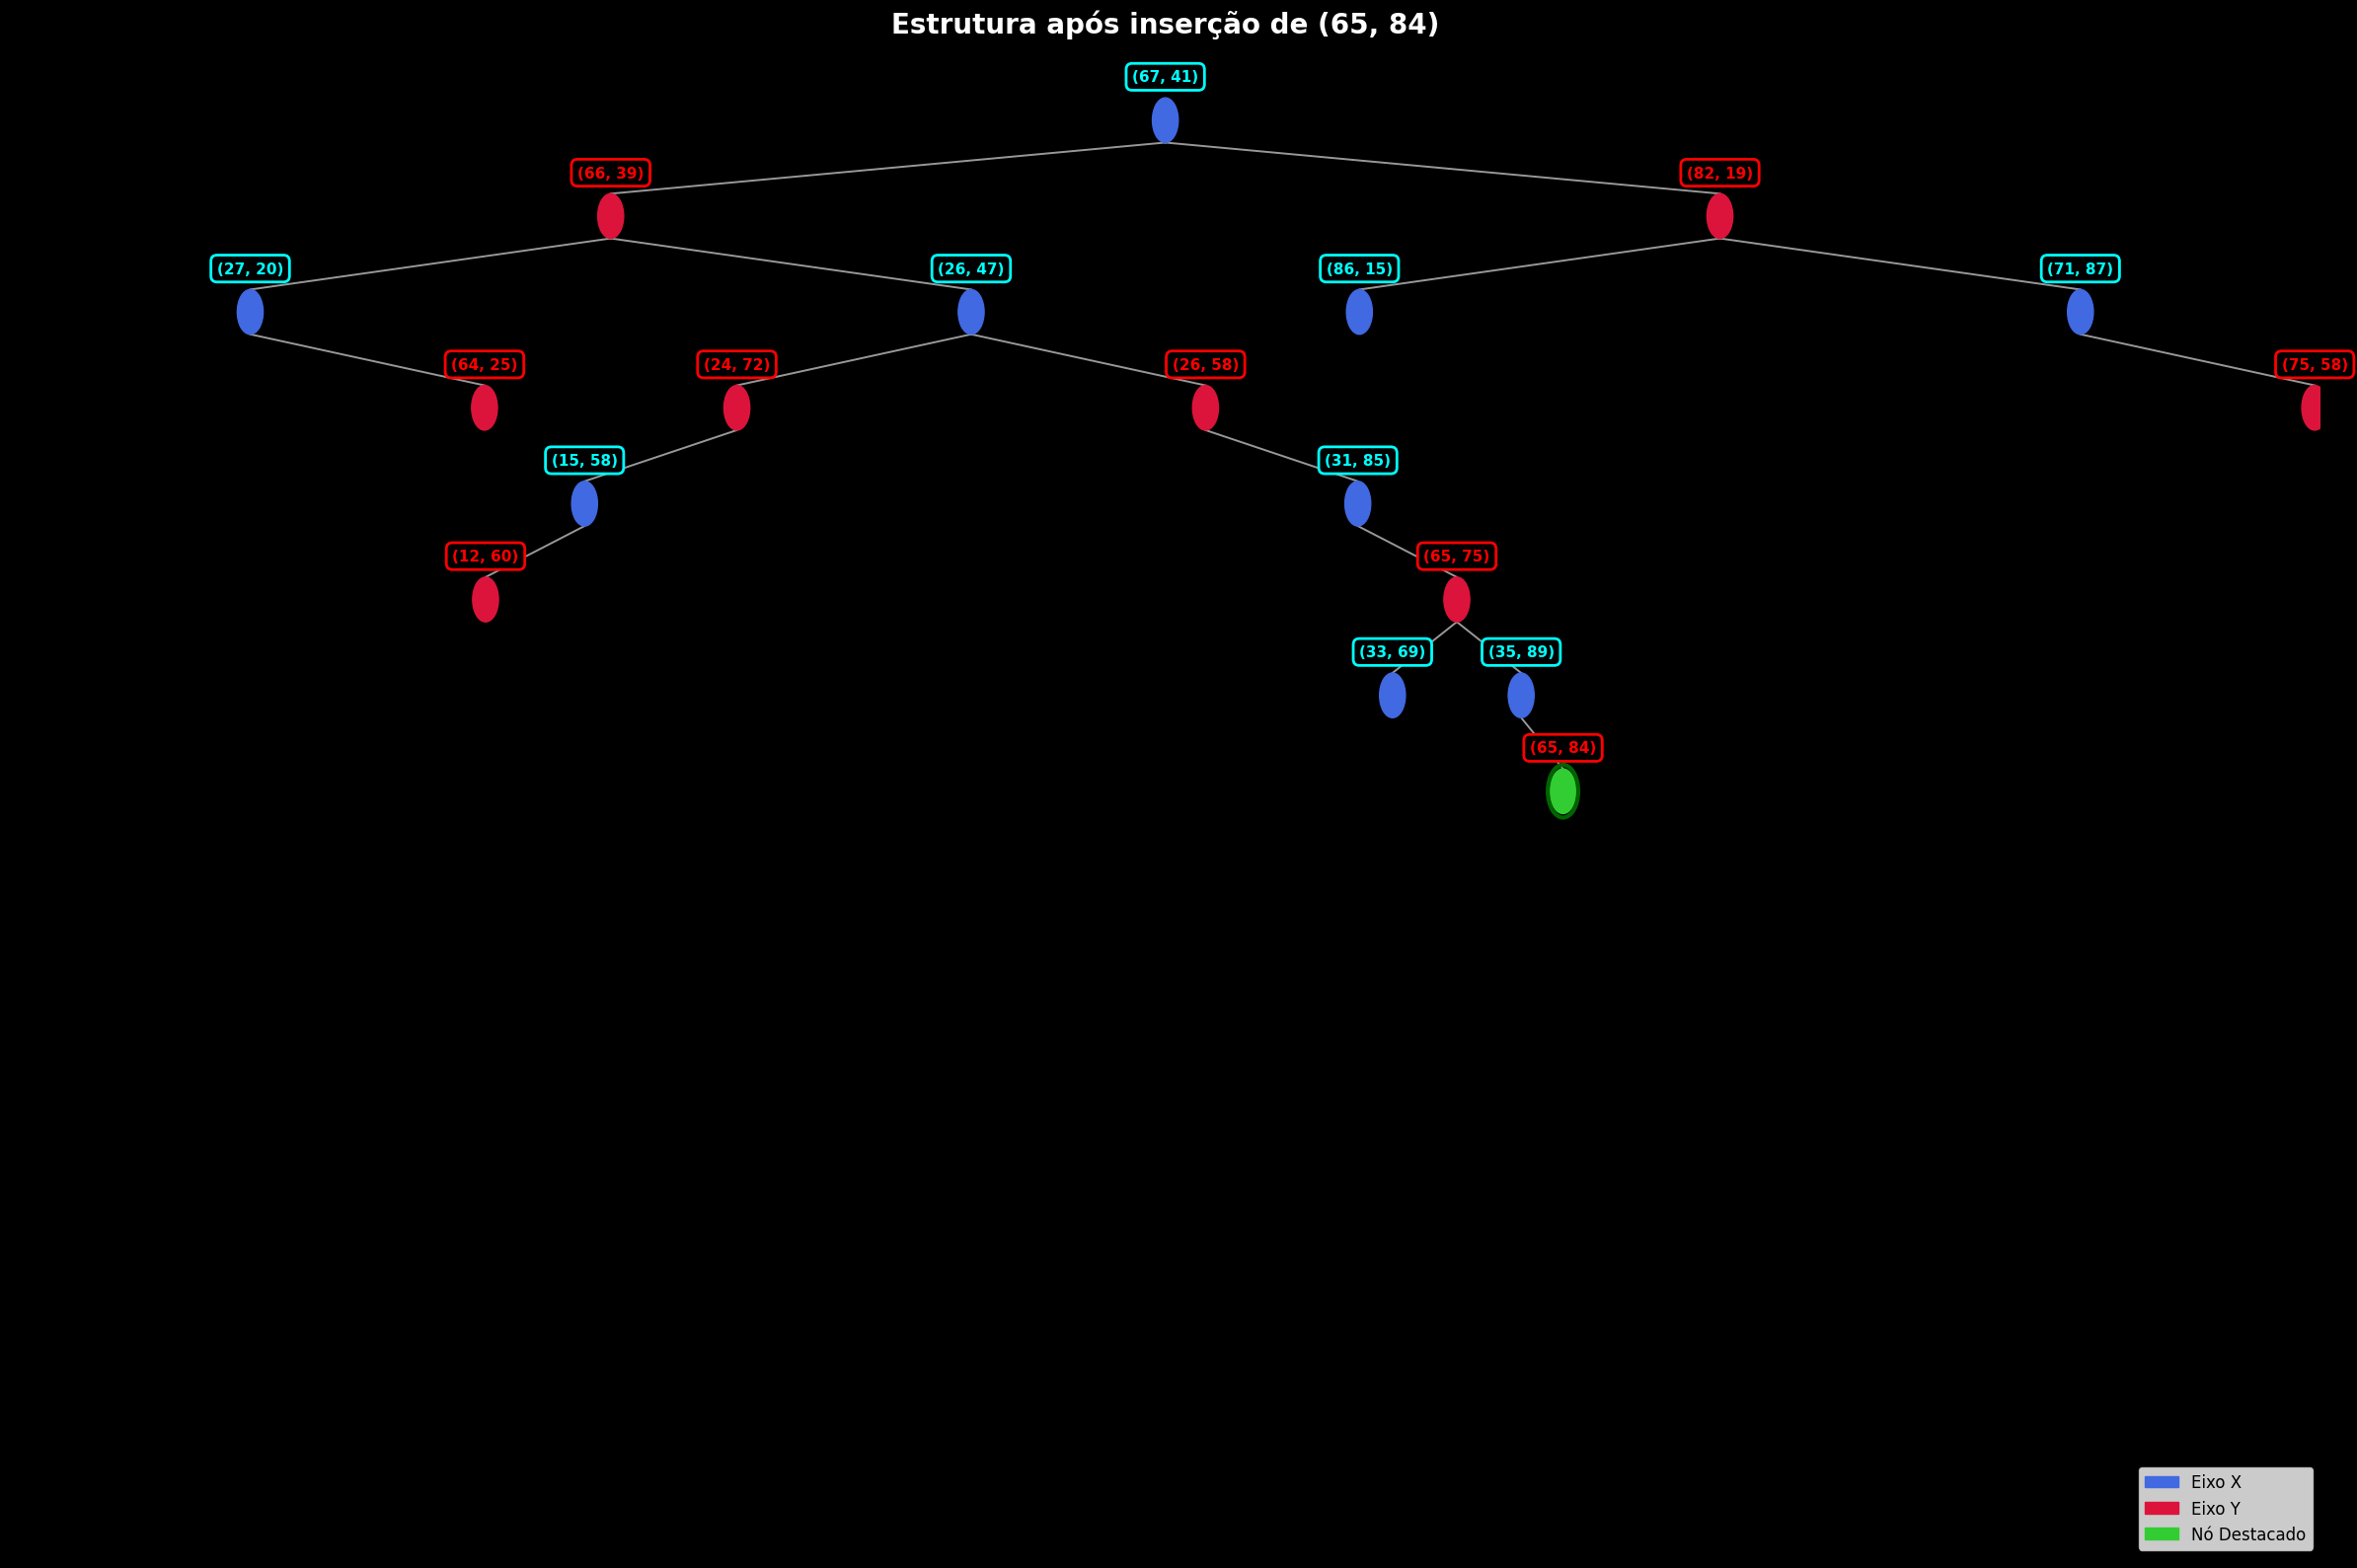

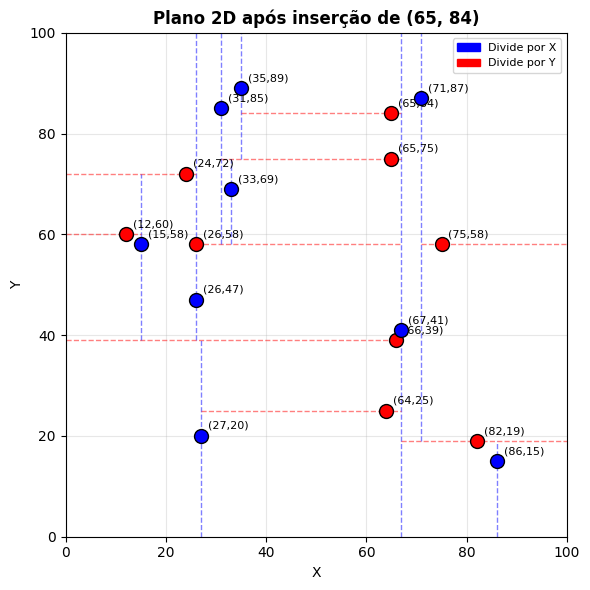


📥 INSERINDO: (13, 33)
  → Comparando 13 com 67 (eixo X), indo para ESQUERDA
  → Comparando 33 com 39 (eixo Y), indo para ESQUERDA
  → Comparando 13 com 27 (eixo X), indo para ESQUERDA
  → Criando nó (13, 33) (divide por Y)


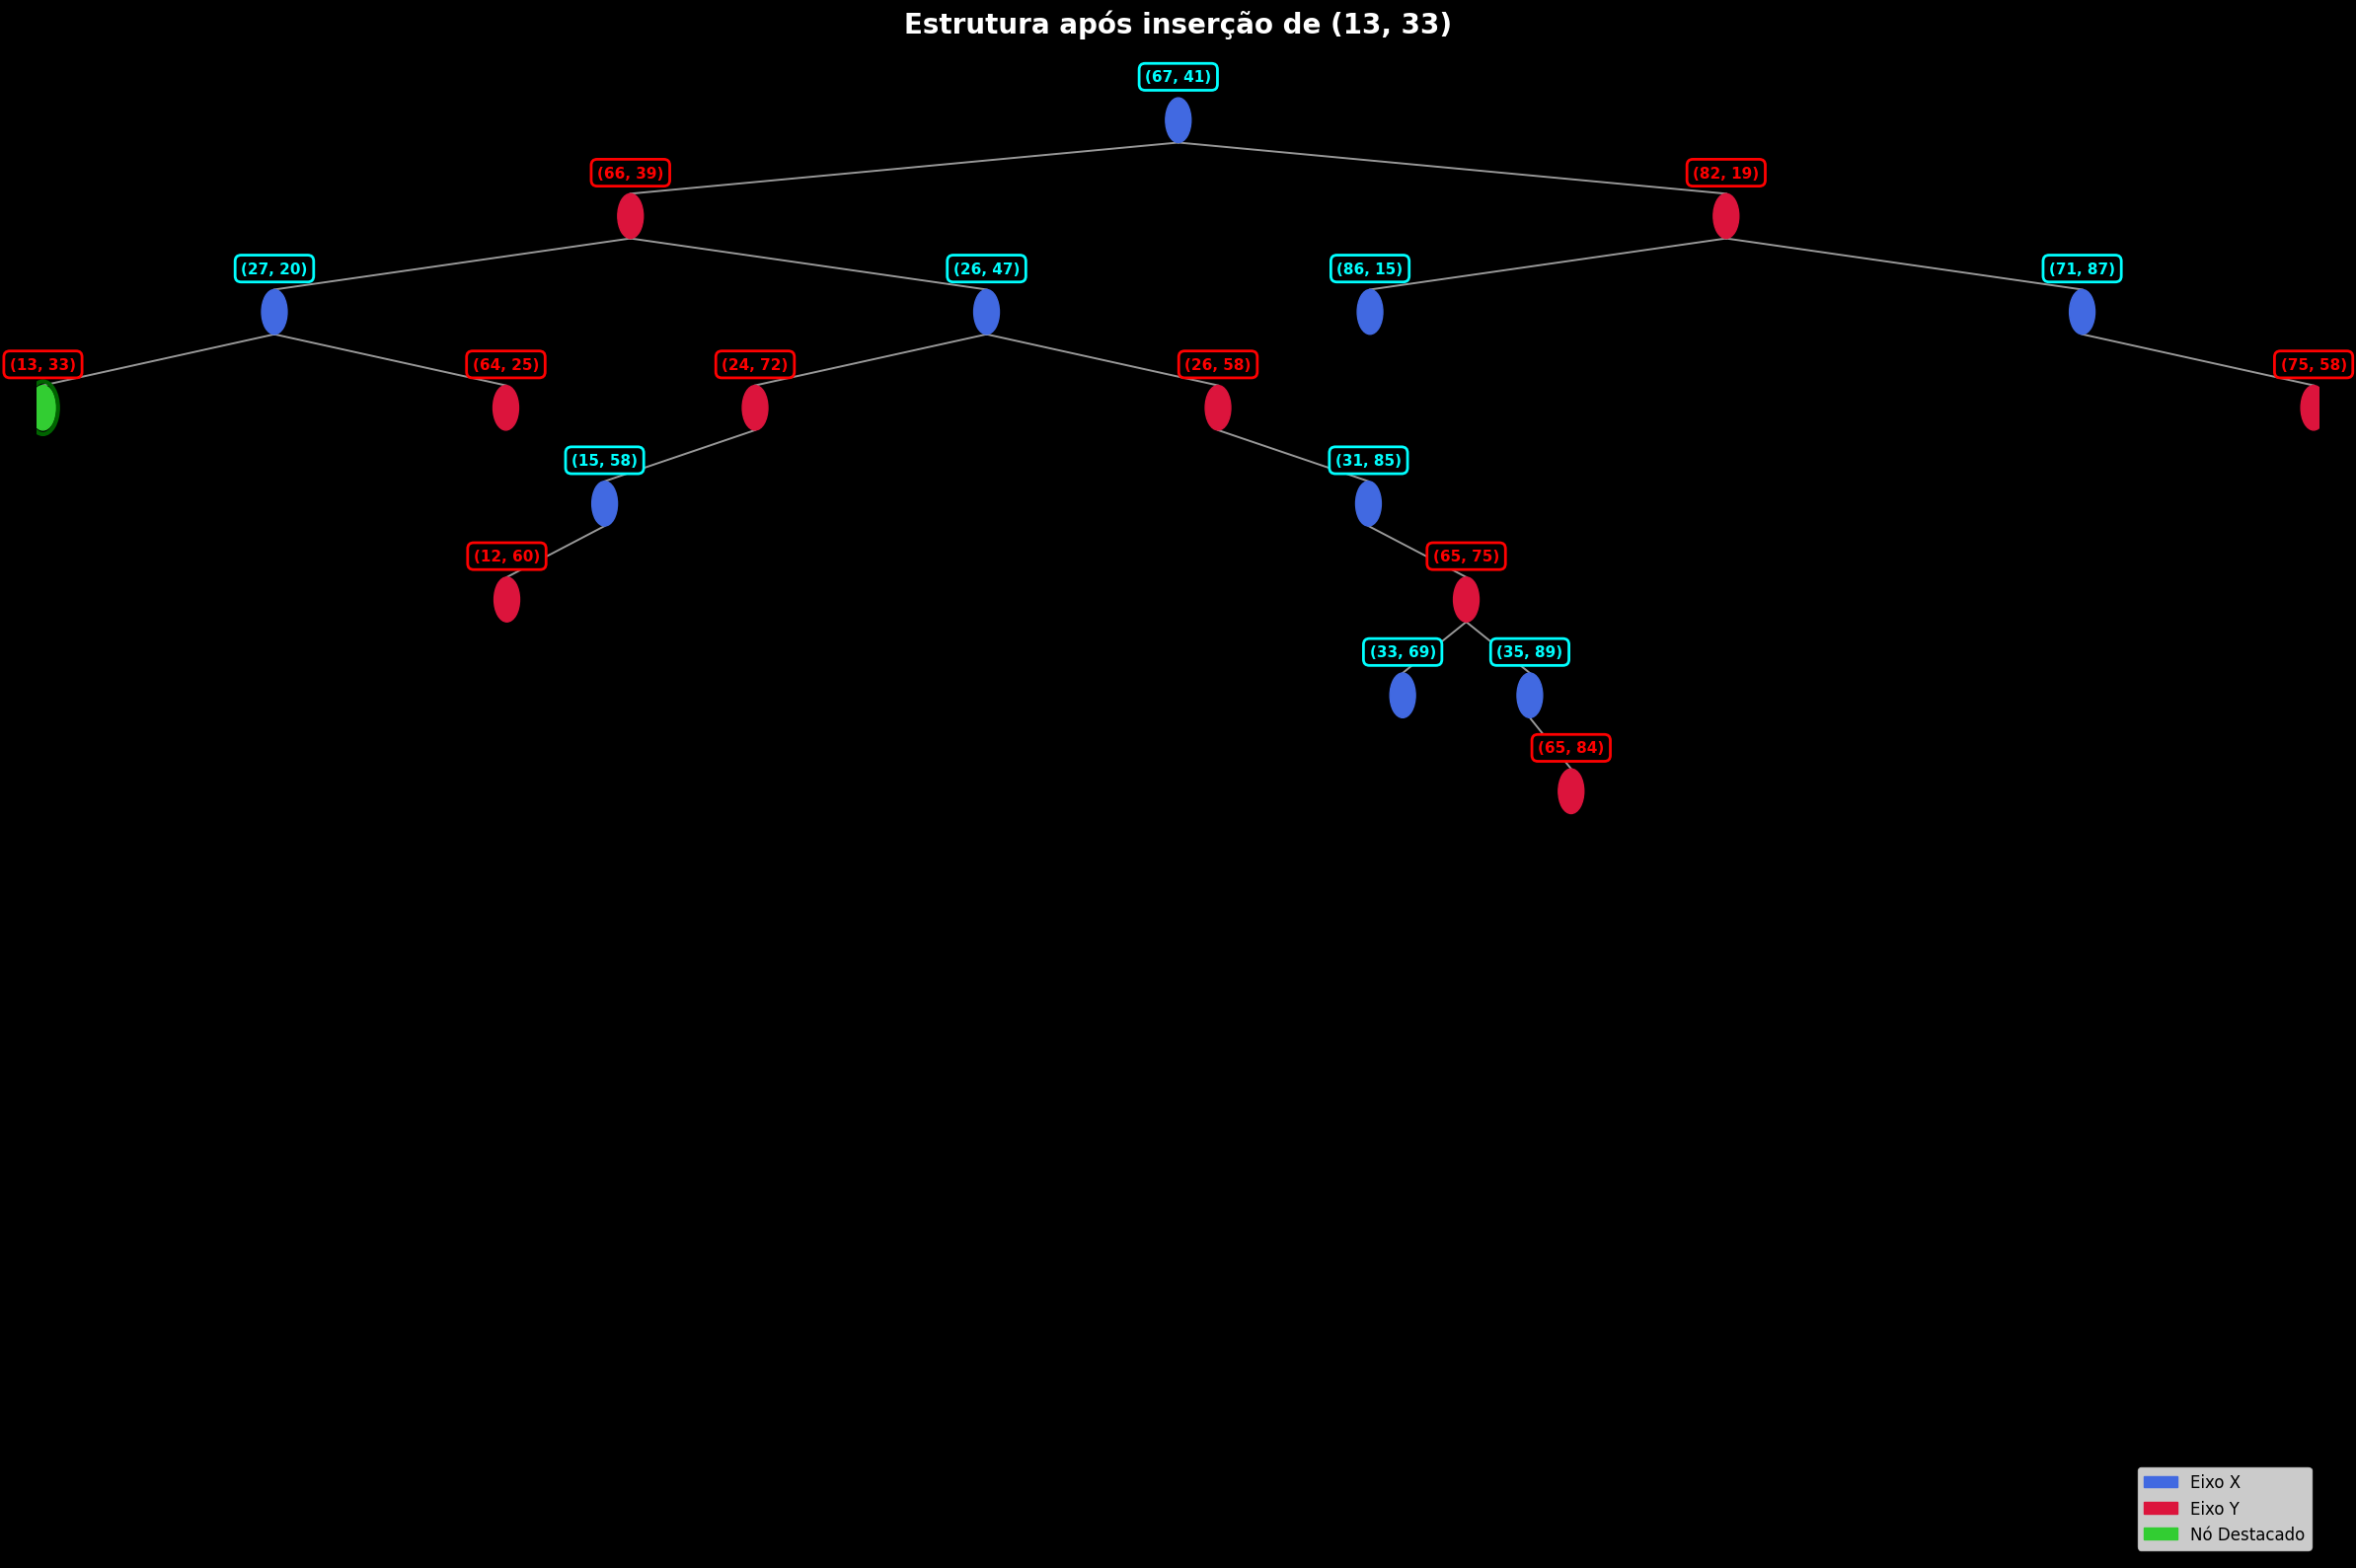

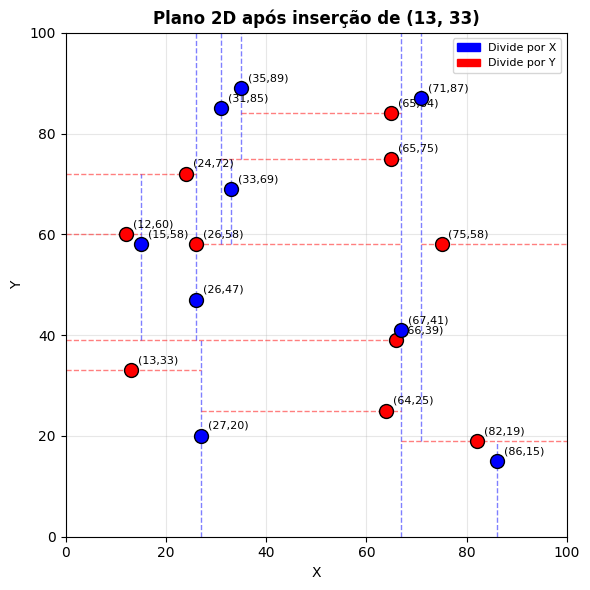


📥 INSERINDO: (42, 50)
  → Comparando 42 com 67 (eixo X), indo para ESQUERDA
  → Comparando 50 com 39 (eixo Y), indo para DIREITA
  → Comparando 42 com 26 (eixo X), indo para DIREITA
  → Comparando 50 com 58 (eixo Y), indo para ESQUERDA
  → Criando nó (42, 50) (divide por X)


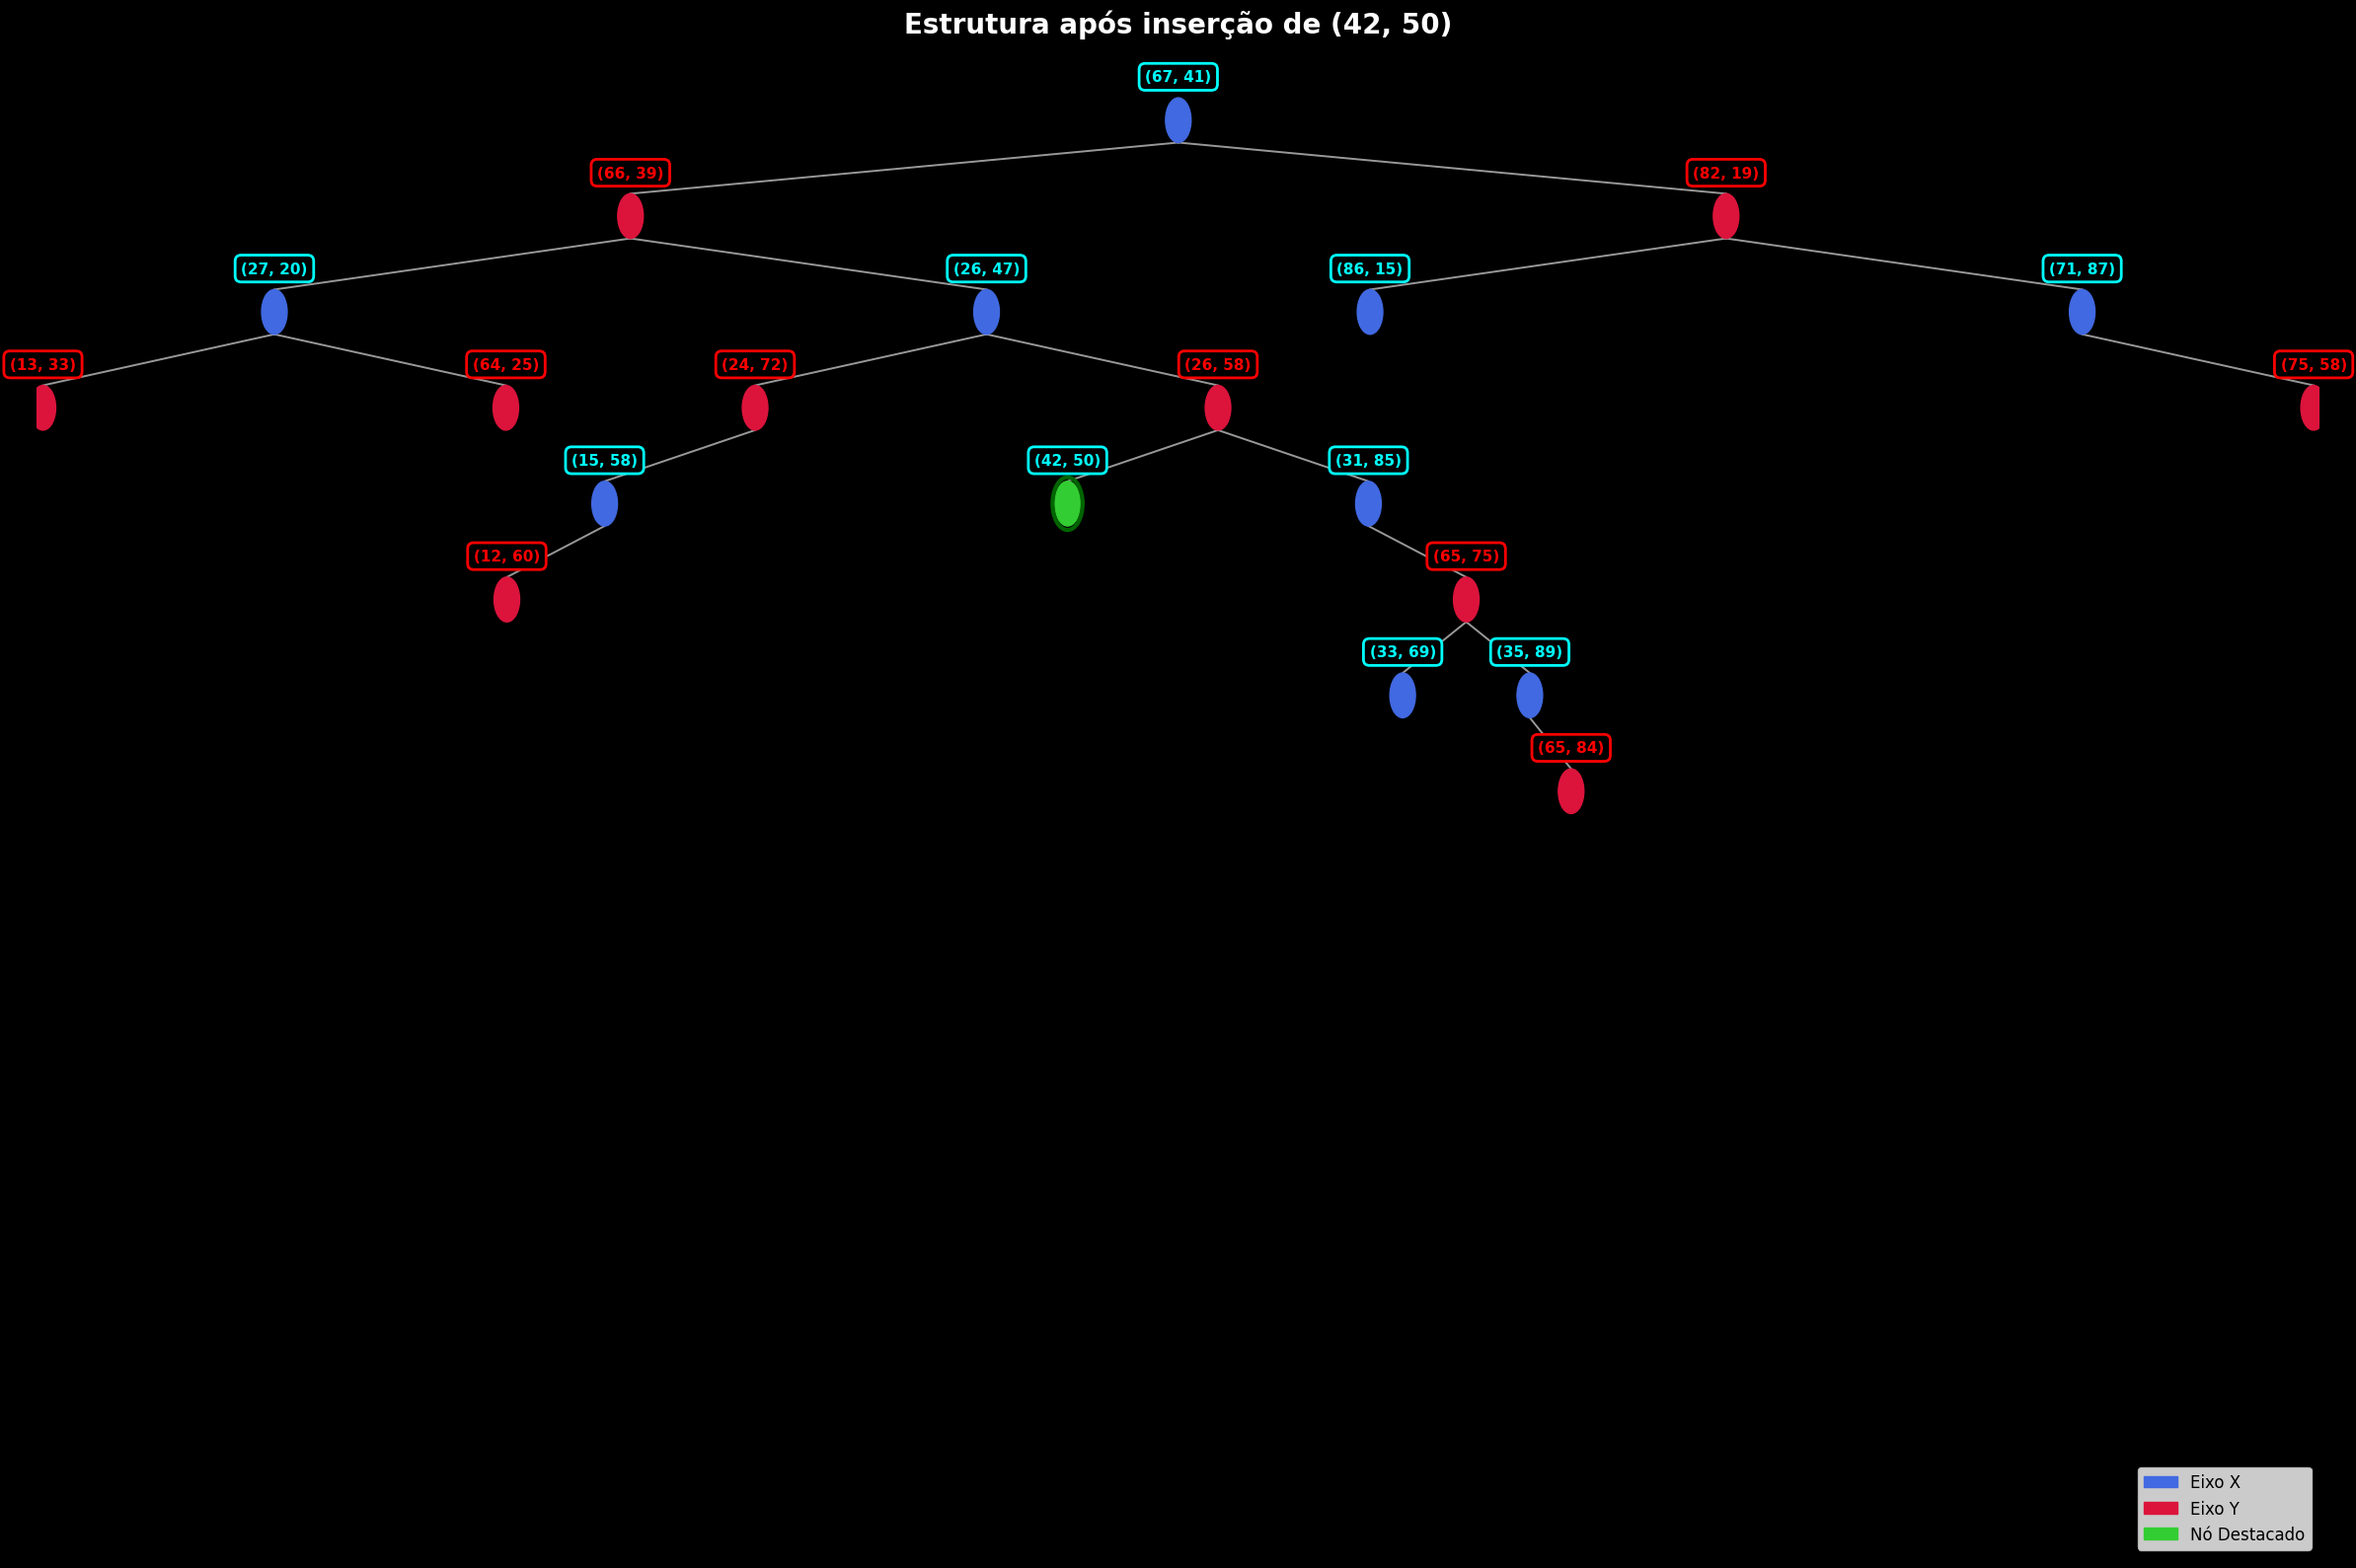

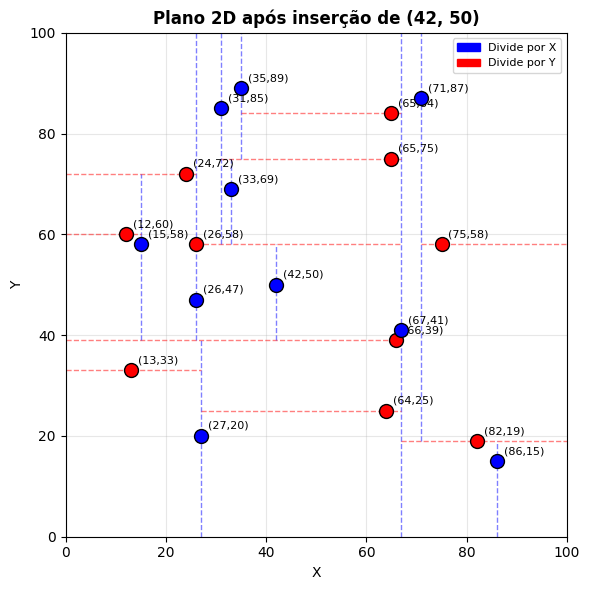


📥 INSERINDO: (56, 57)
  → Comparando 56 com 67 (eixo X), indo para ESQUERDA
  → Comparando 57 com 39 (eixo Y), indo para DIREITA
  → Comparando 56 com 26 (eixo X), indo para DIREITA
  → Comparando 57 com 58 (eixo Y), indo para ESQUERDA
  → Comparando 56 com 42 (eixo X), indo para DIREITA
  → Criando nó (56, 57) (divide por Y)


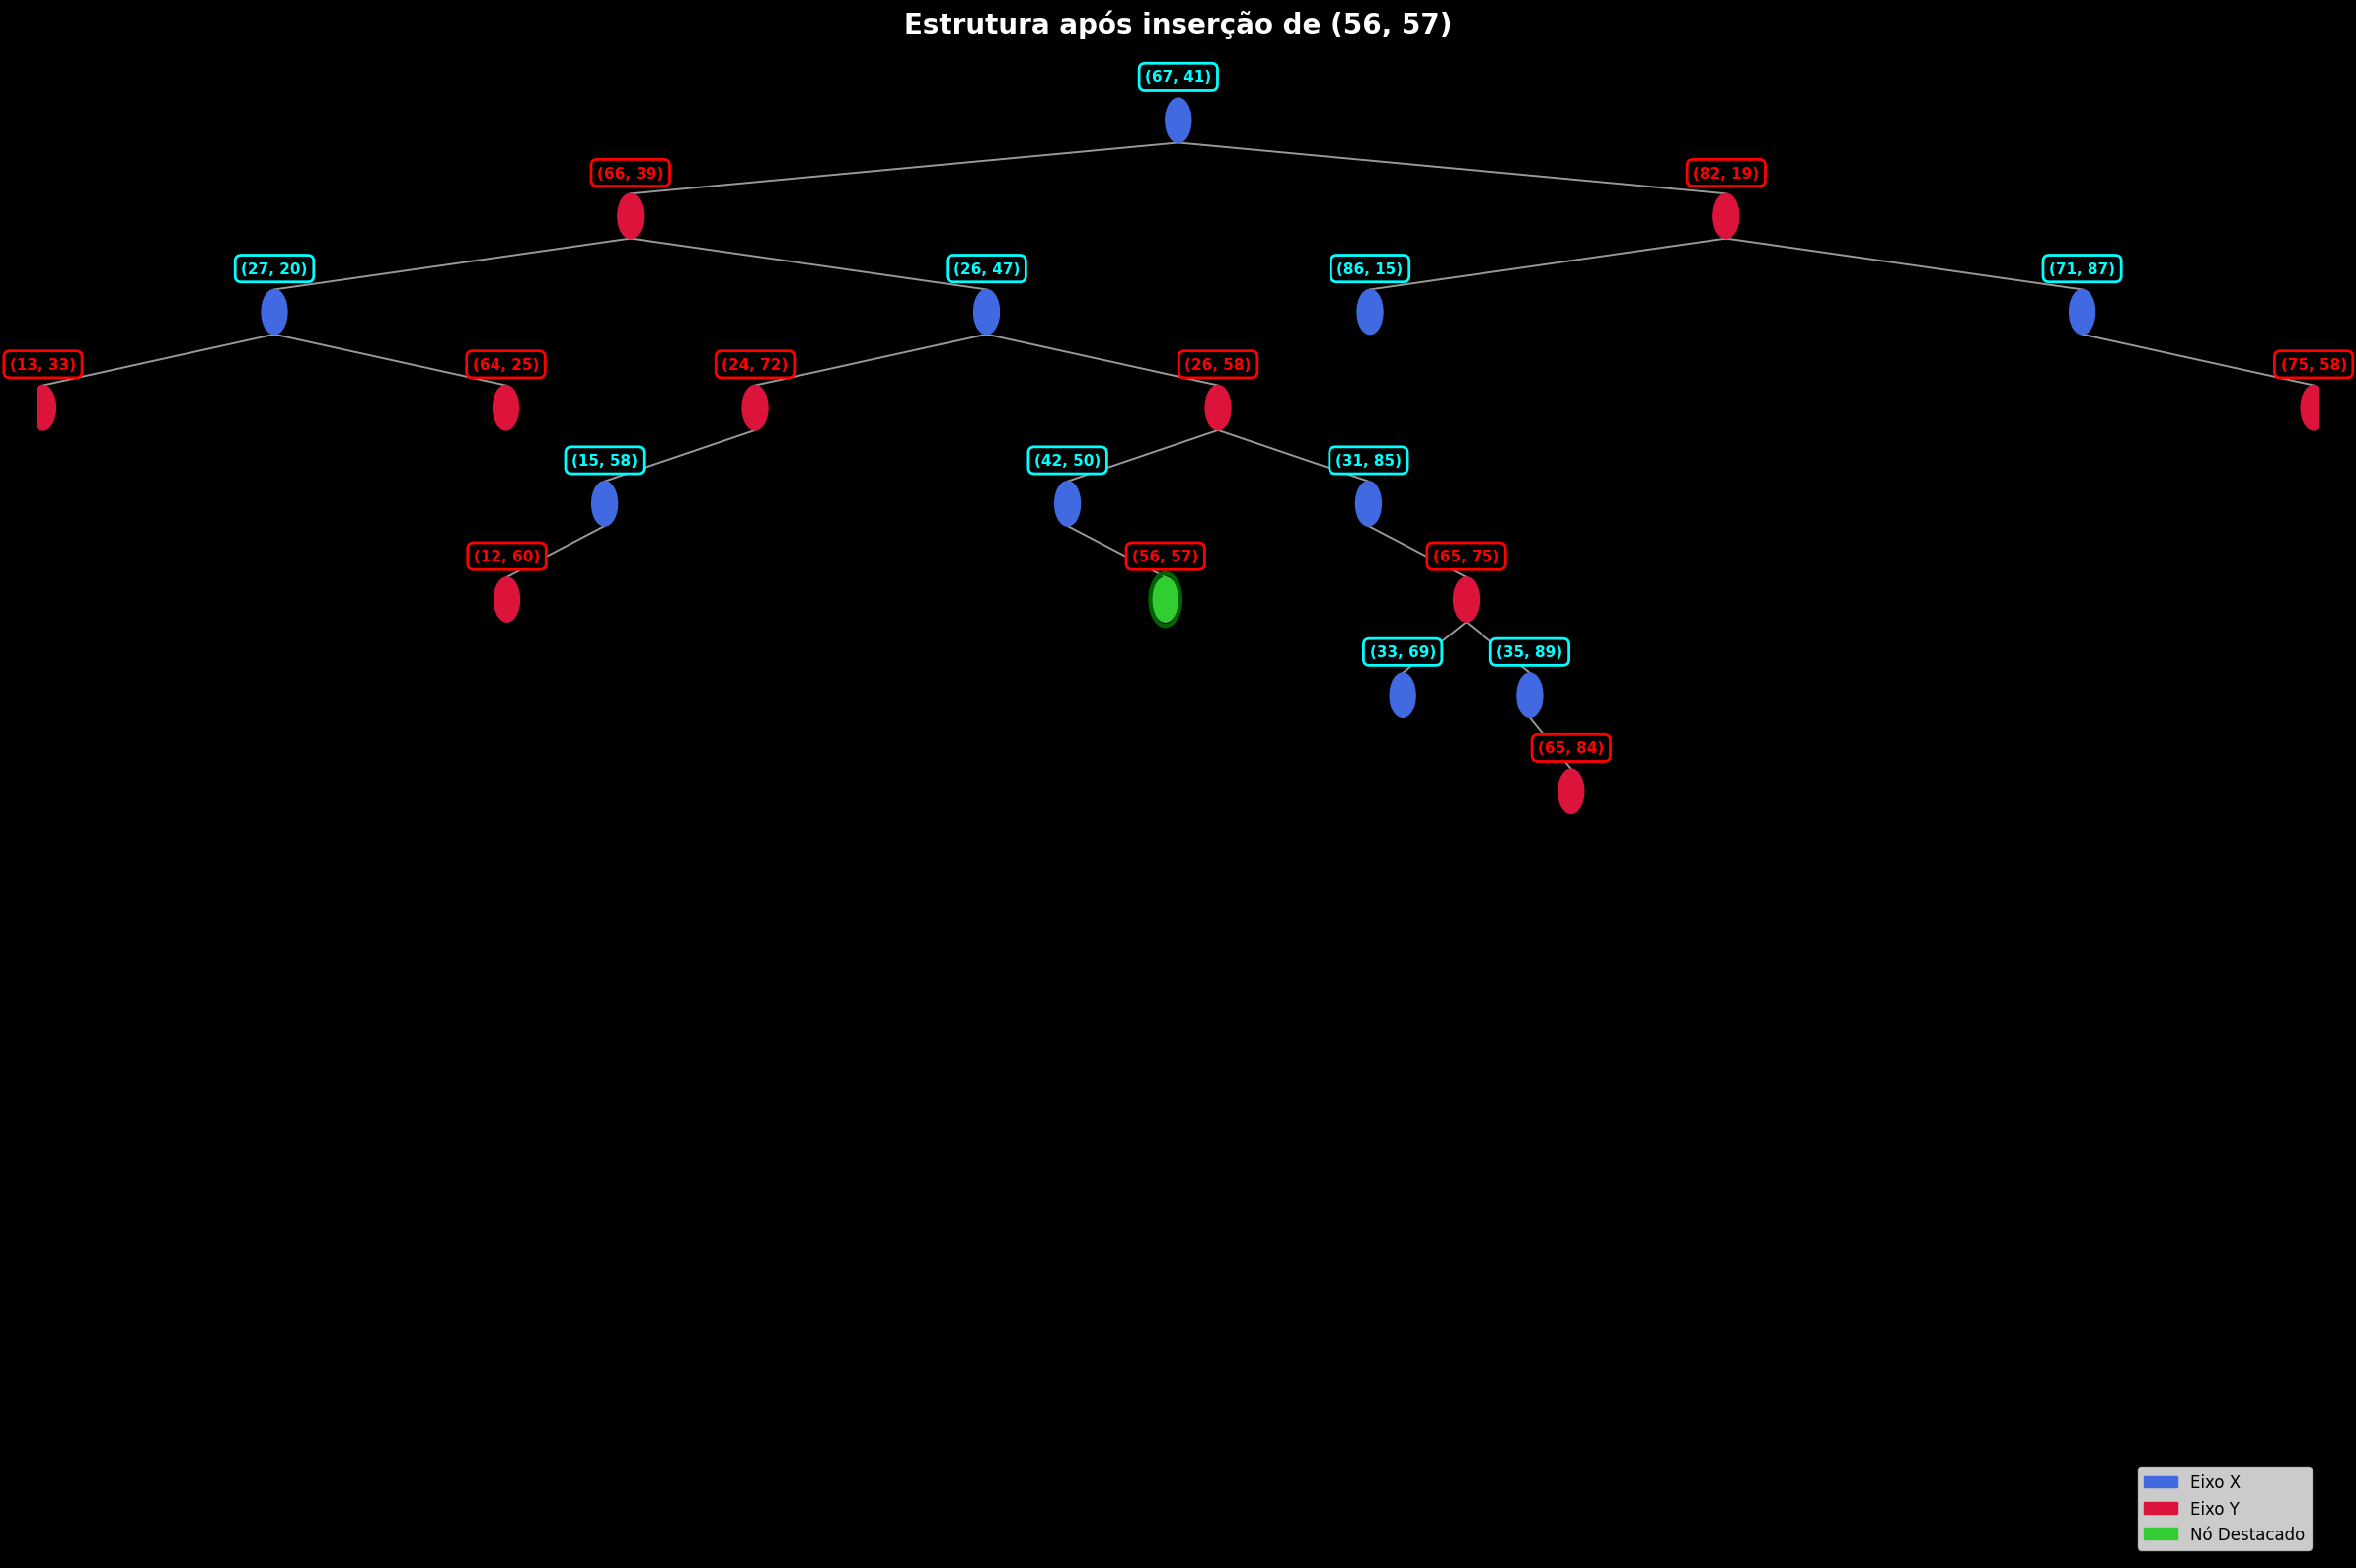

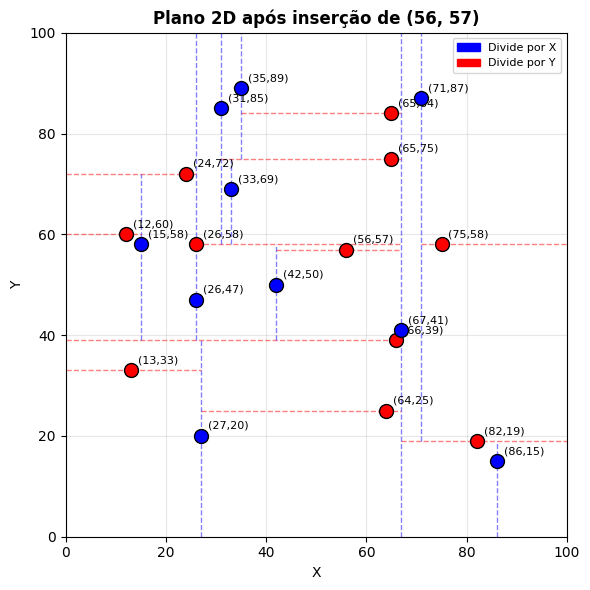

In [26]:
arvore = ArvoreKD(k=2)

pontos = [(random.randint(10, 90), random.randint(10, 90)) for _ in range(21)]

print("="*60)
print("📥 INSERÇÃO")
print("="*60)
print(f"Pontos a inserir: {pontos}\n")

for p in pontos:
    inserir_passo_a_passo(arvore, p)

## Exclusão


🗑️ EXCLUINDO: (53, 89)
  ✓ Ponto (53, 89) encontrado na árvore

  📊 Visualizando ANTES da exclusão:


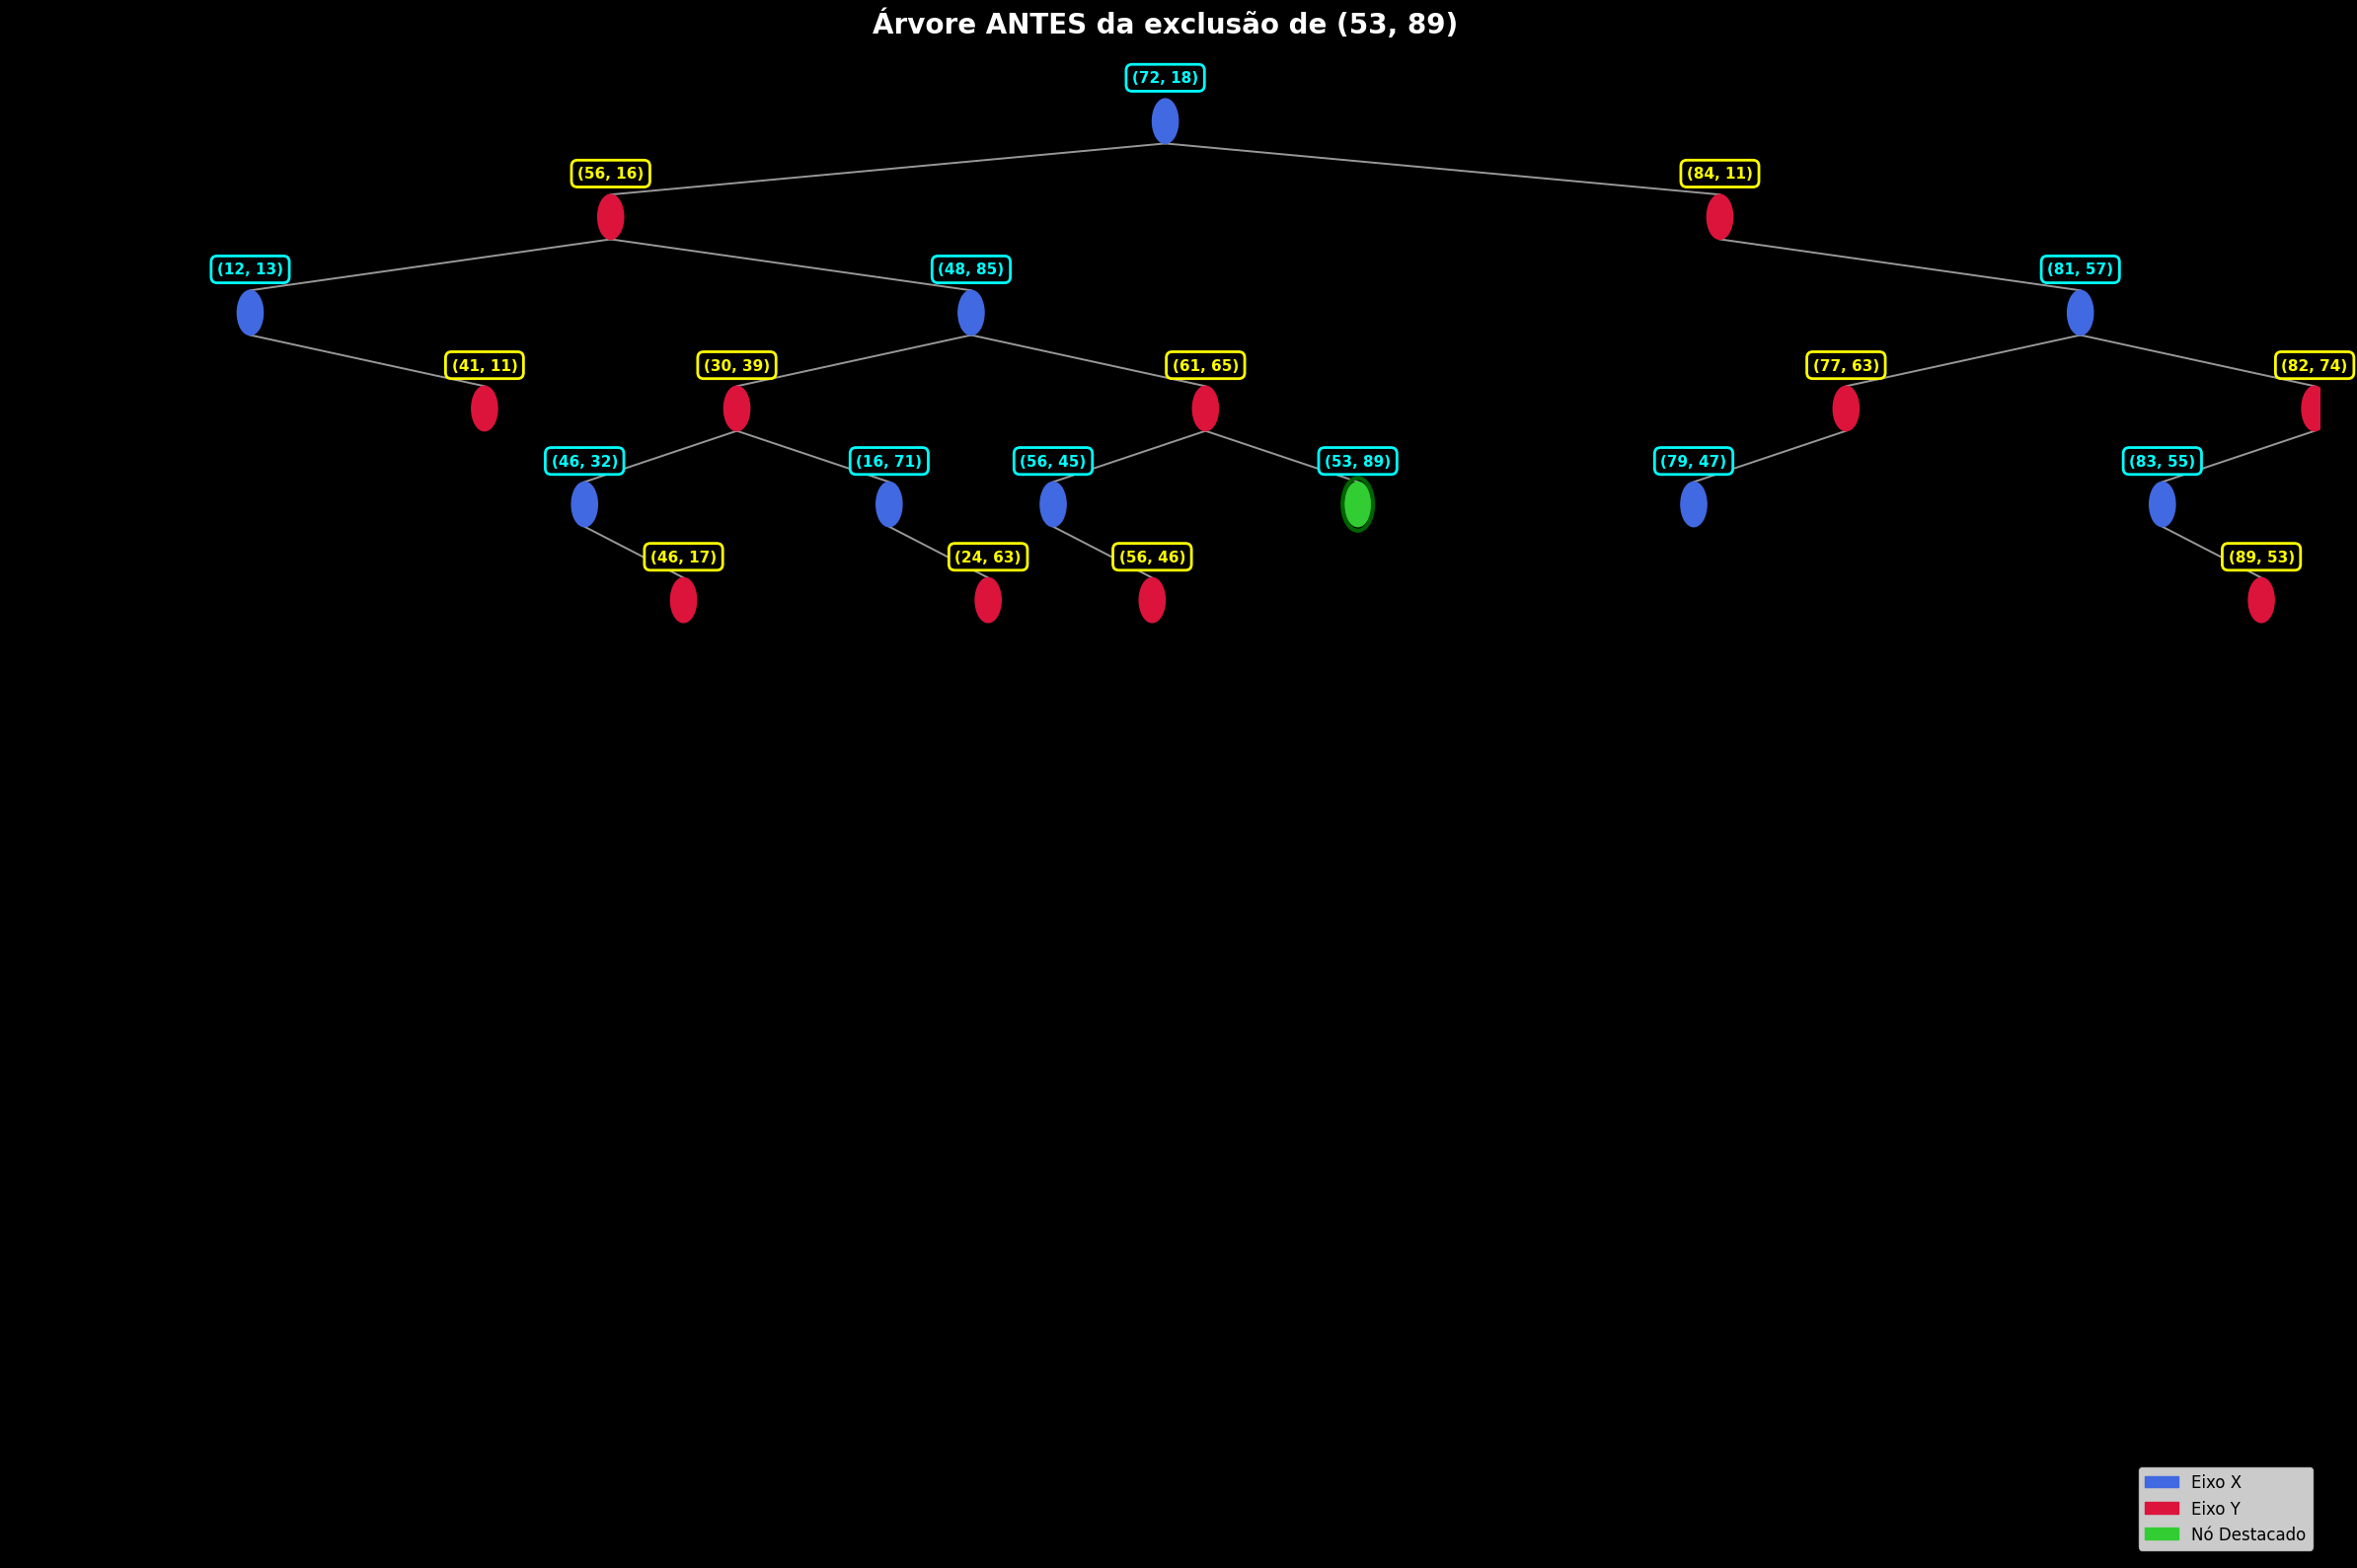

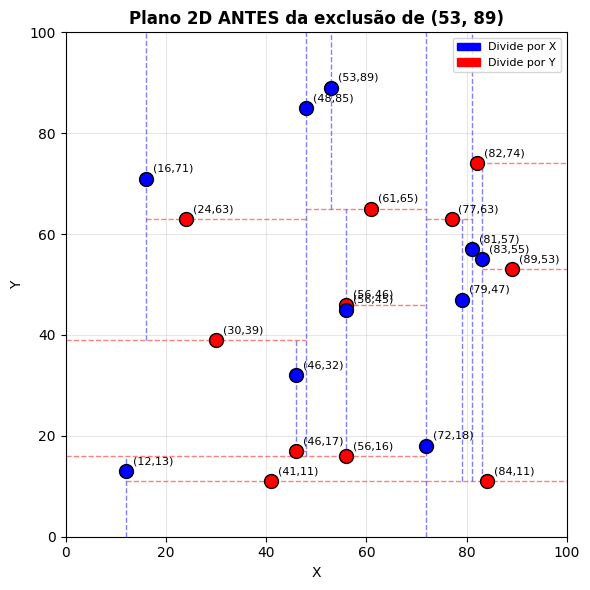


  ✅ Ponto (53, 89) removido com sucesso!

  📊 Visualizando DEPOIS da exclusão:


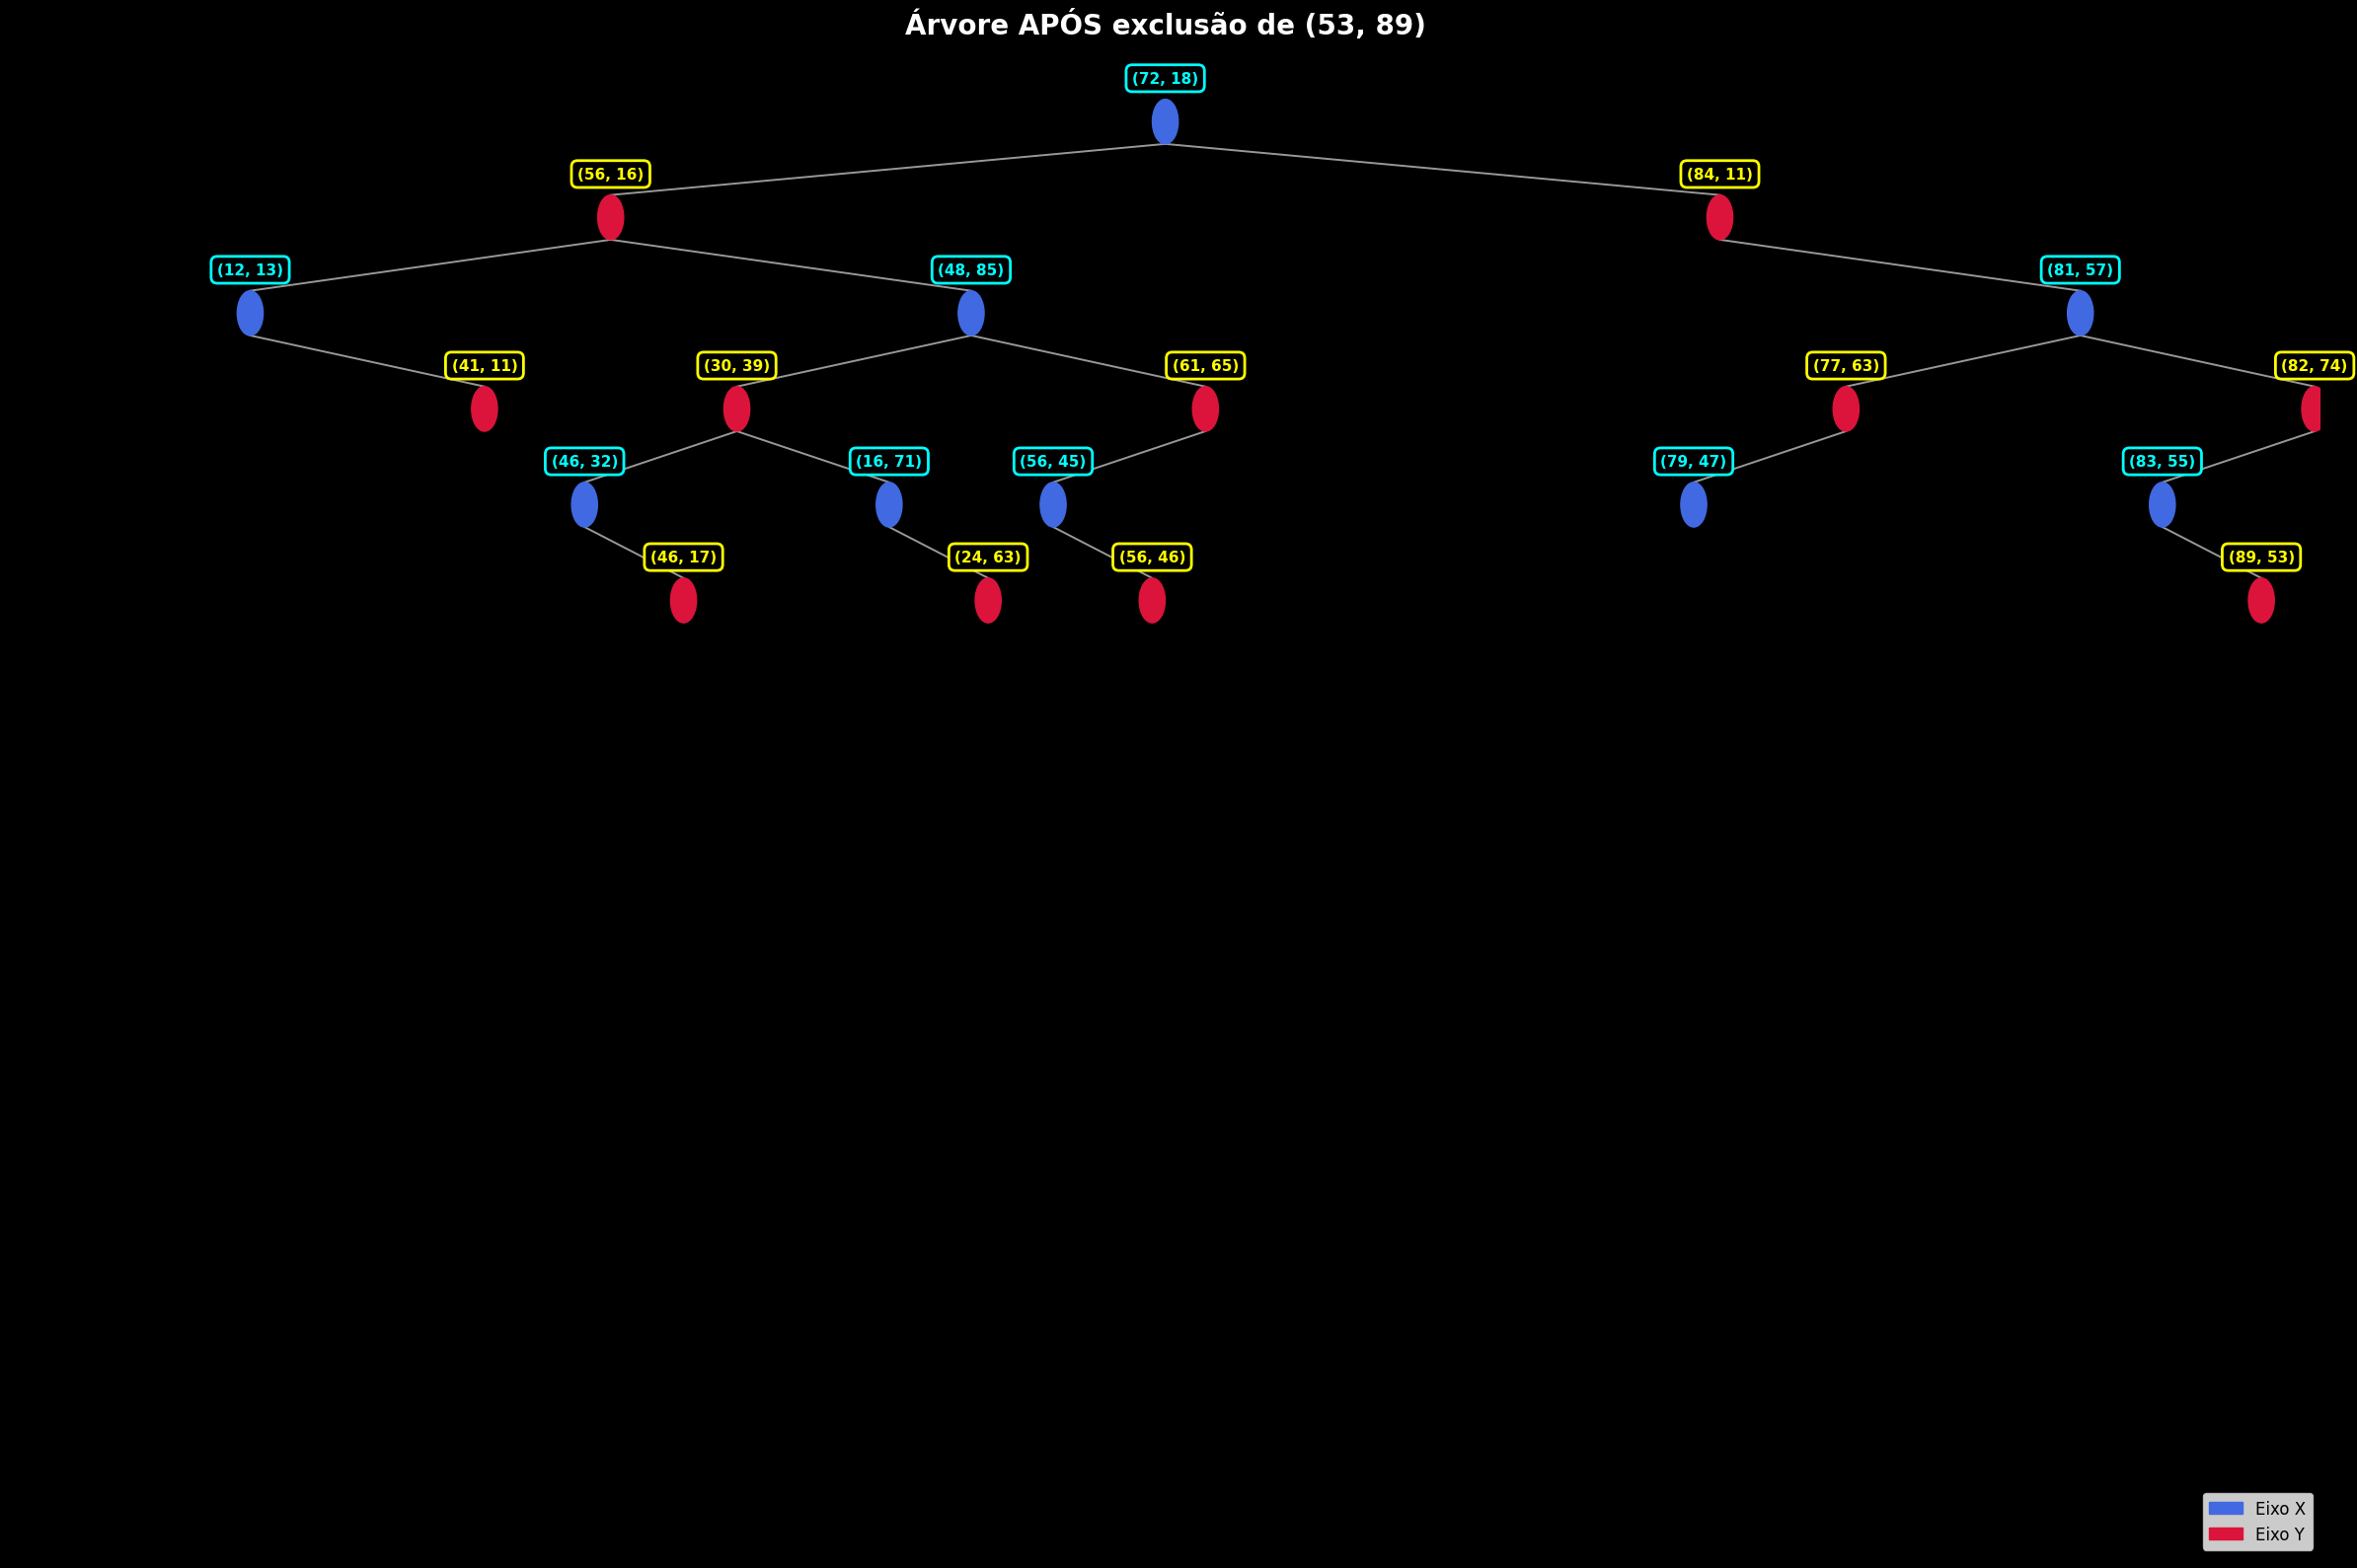

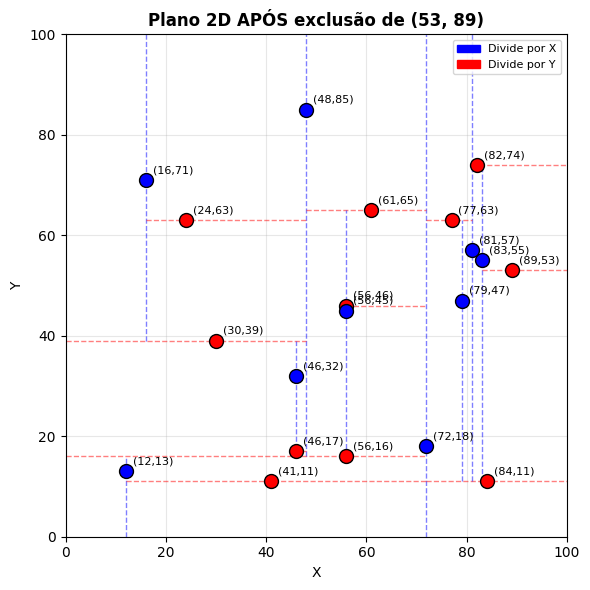

True

In [23]:
ponto_excluir = random.choice(pontos)
excluir_passo_a_passo(arvore, ponto_excluir)

## Busca


🔍 BUSCANDO: (15, 58)

  Passo 1: Visitando (67, 41) (eixo X)
  → Comparando: 15 < 67
  → Indo para: ESQUERDA


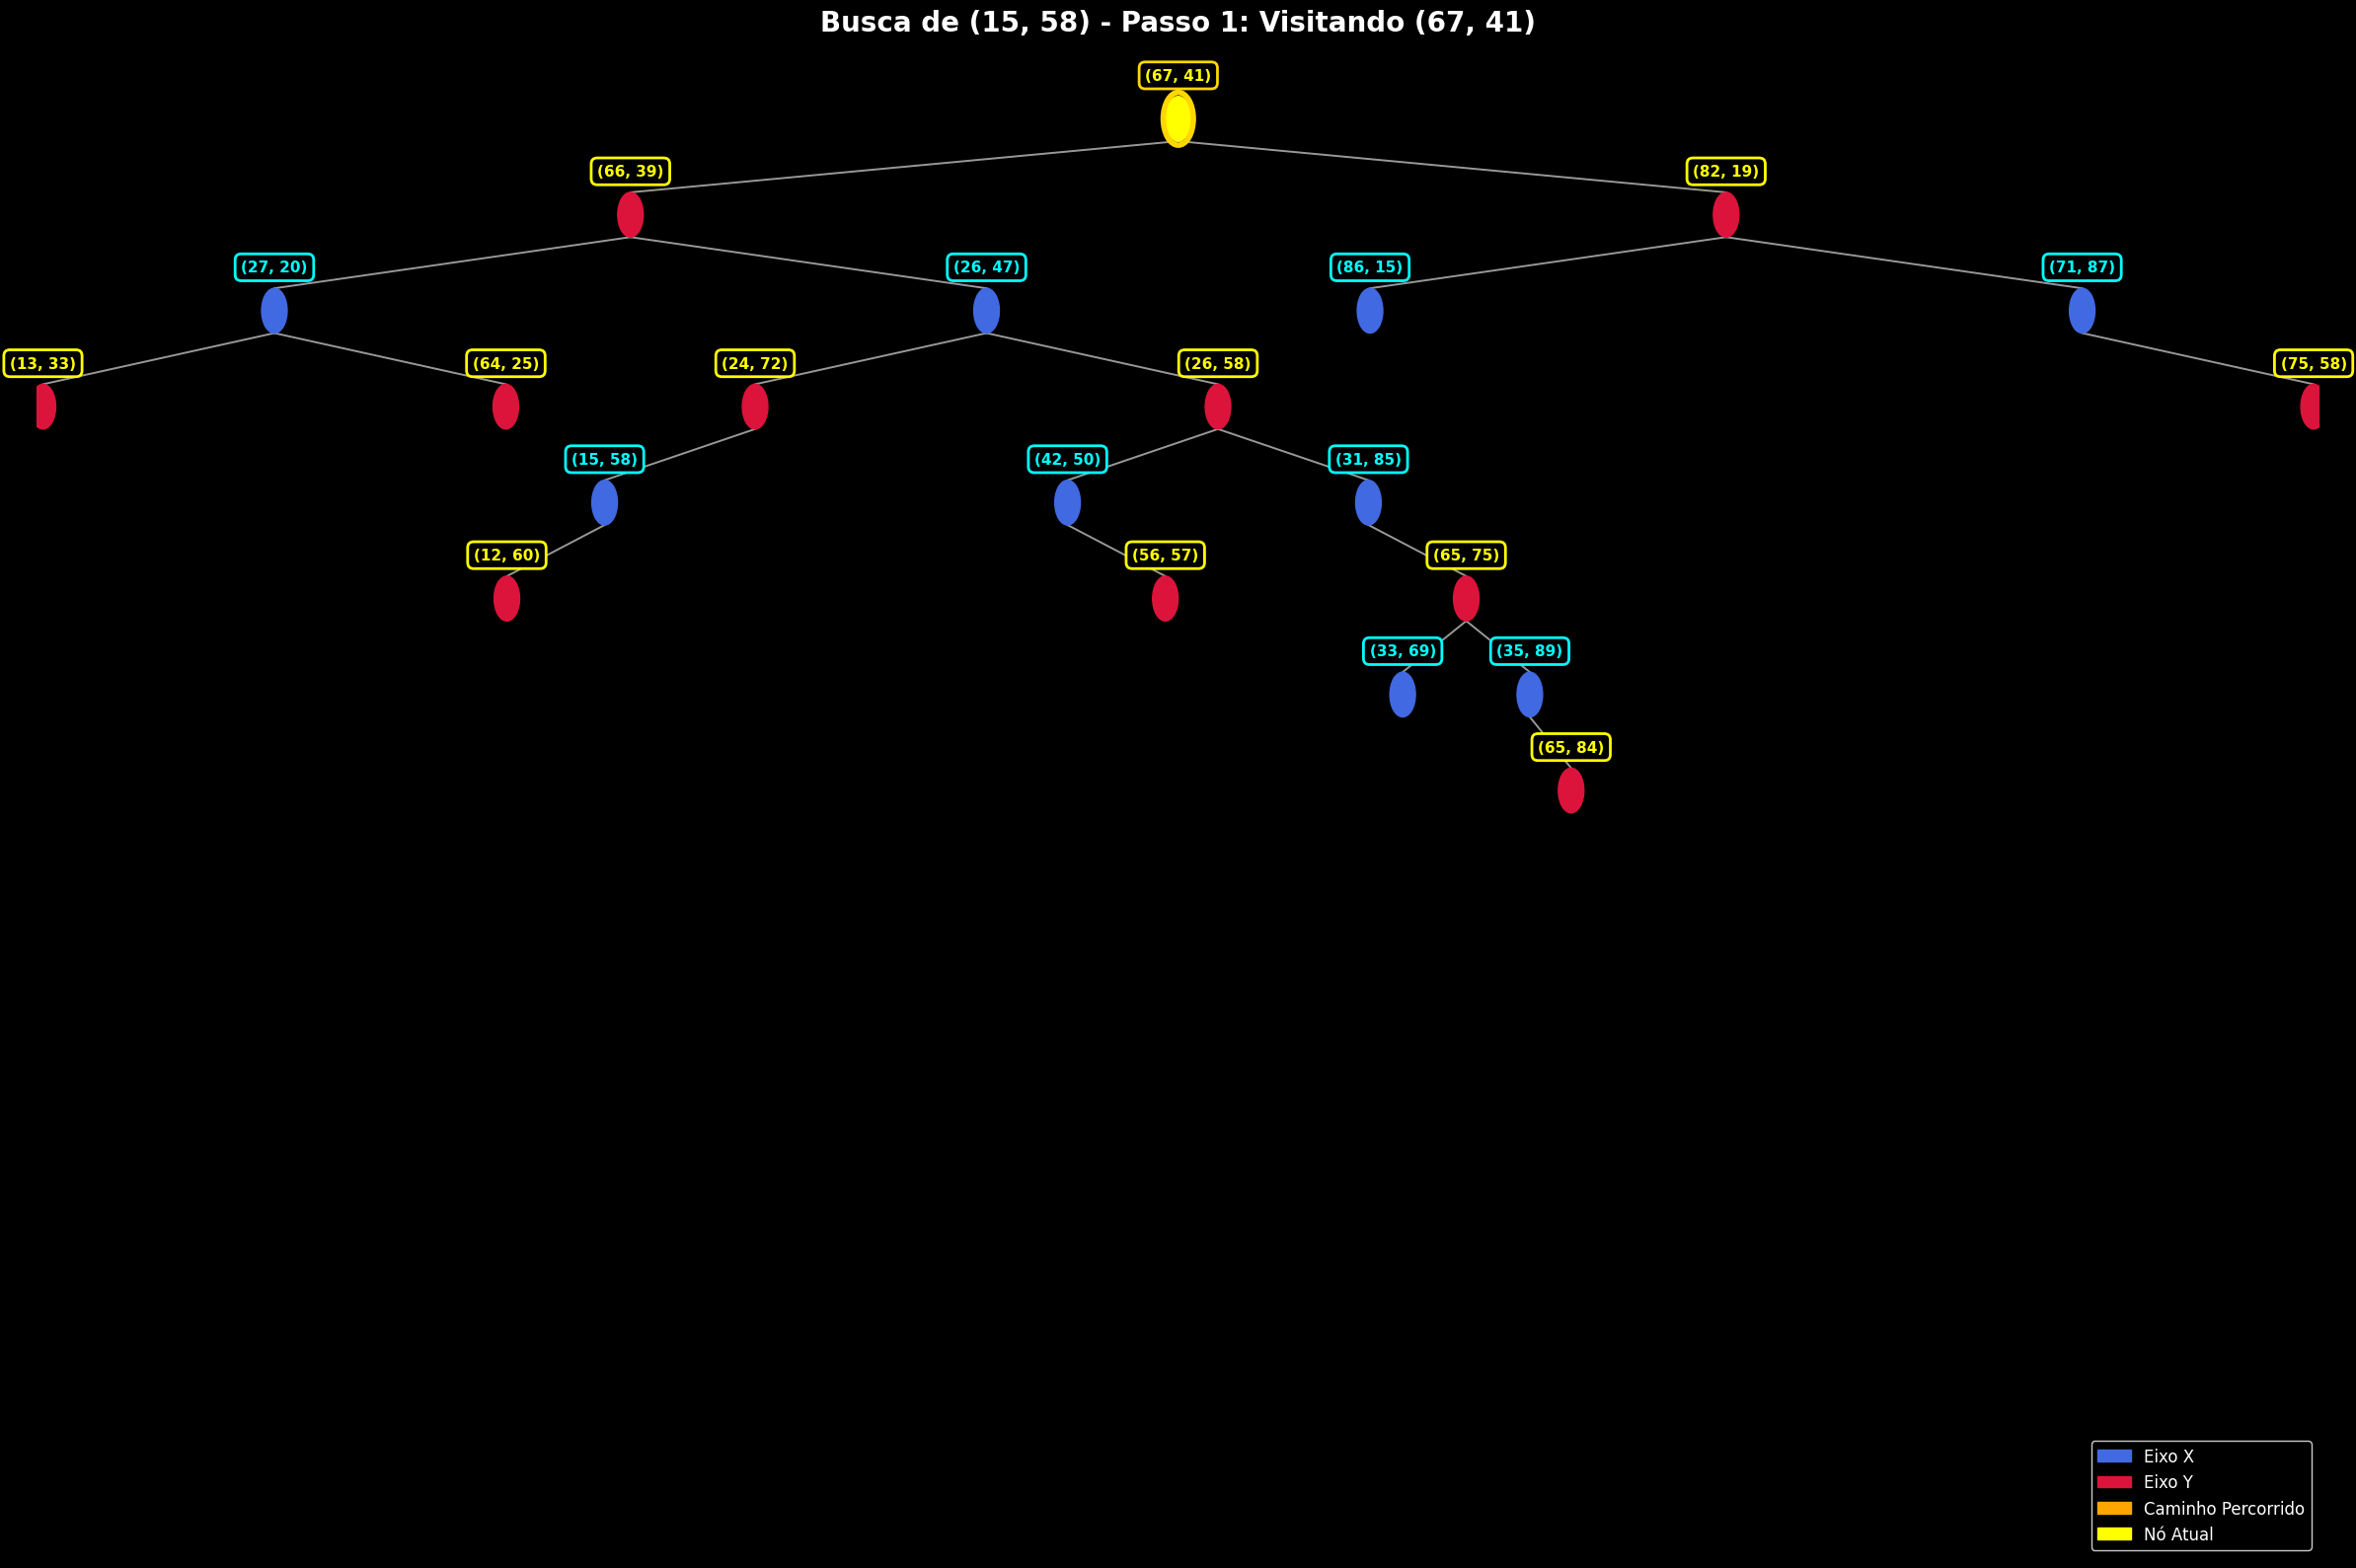


  Passo 2: Visitando (66, 39) (eixo Y)
  → Comparando: 58 > 39
  → Indo para: DIREITA


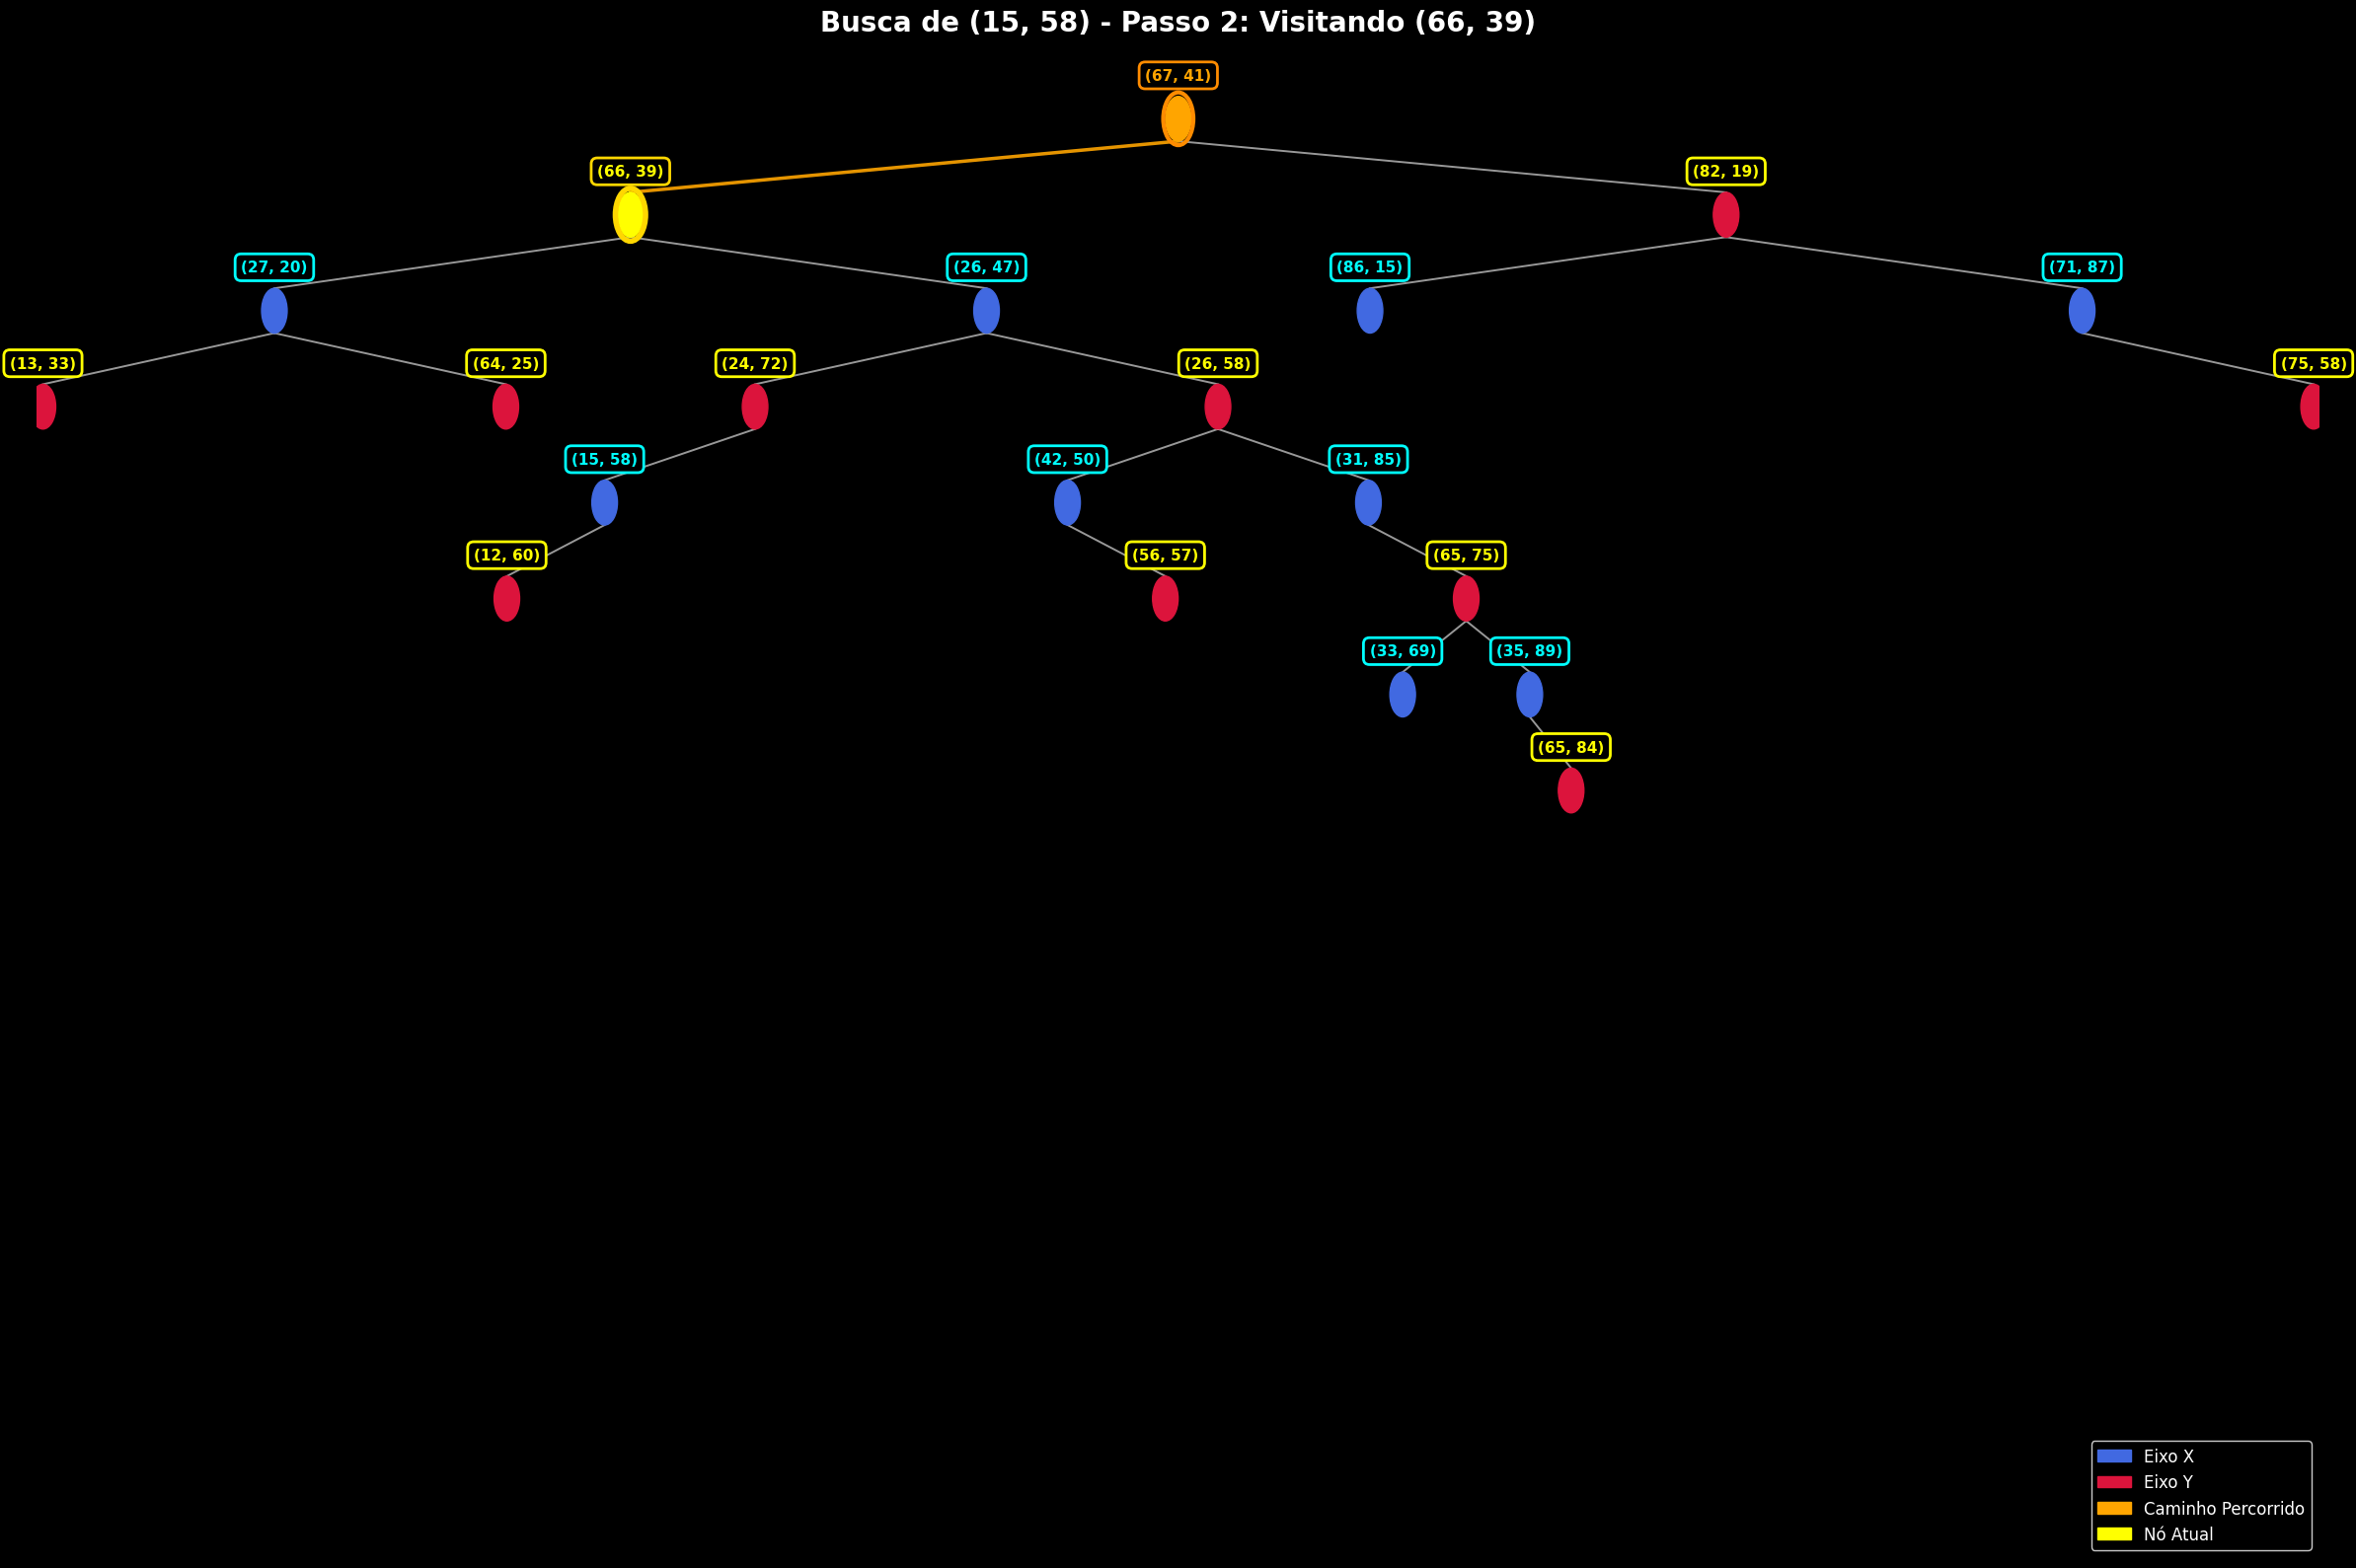


  Passo 3: Visitando (26, 47) (eixo X)
  → Comparando: 15 < 26
  → Indo para: ESQUERDA


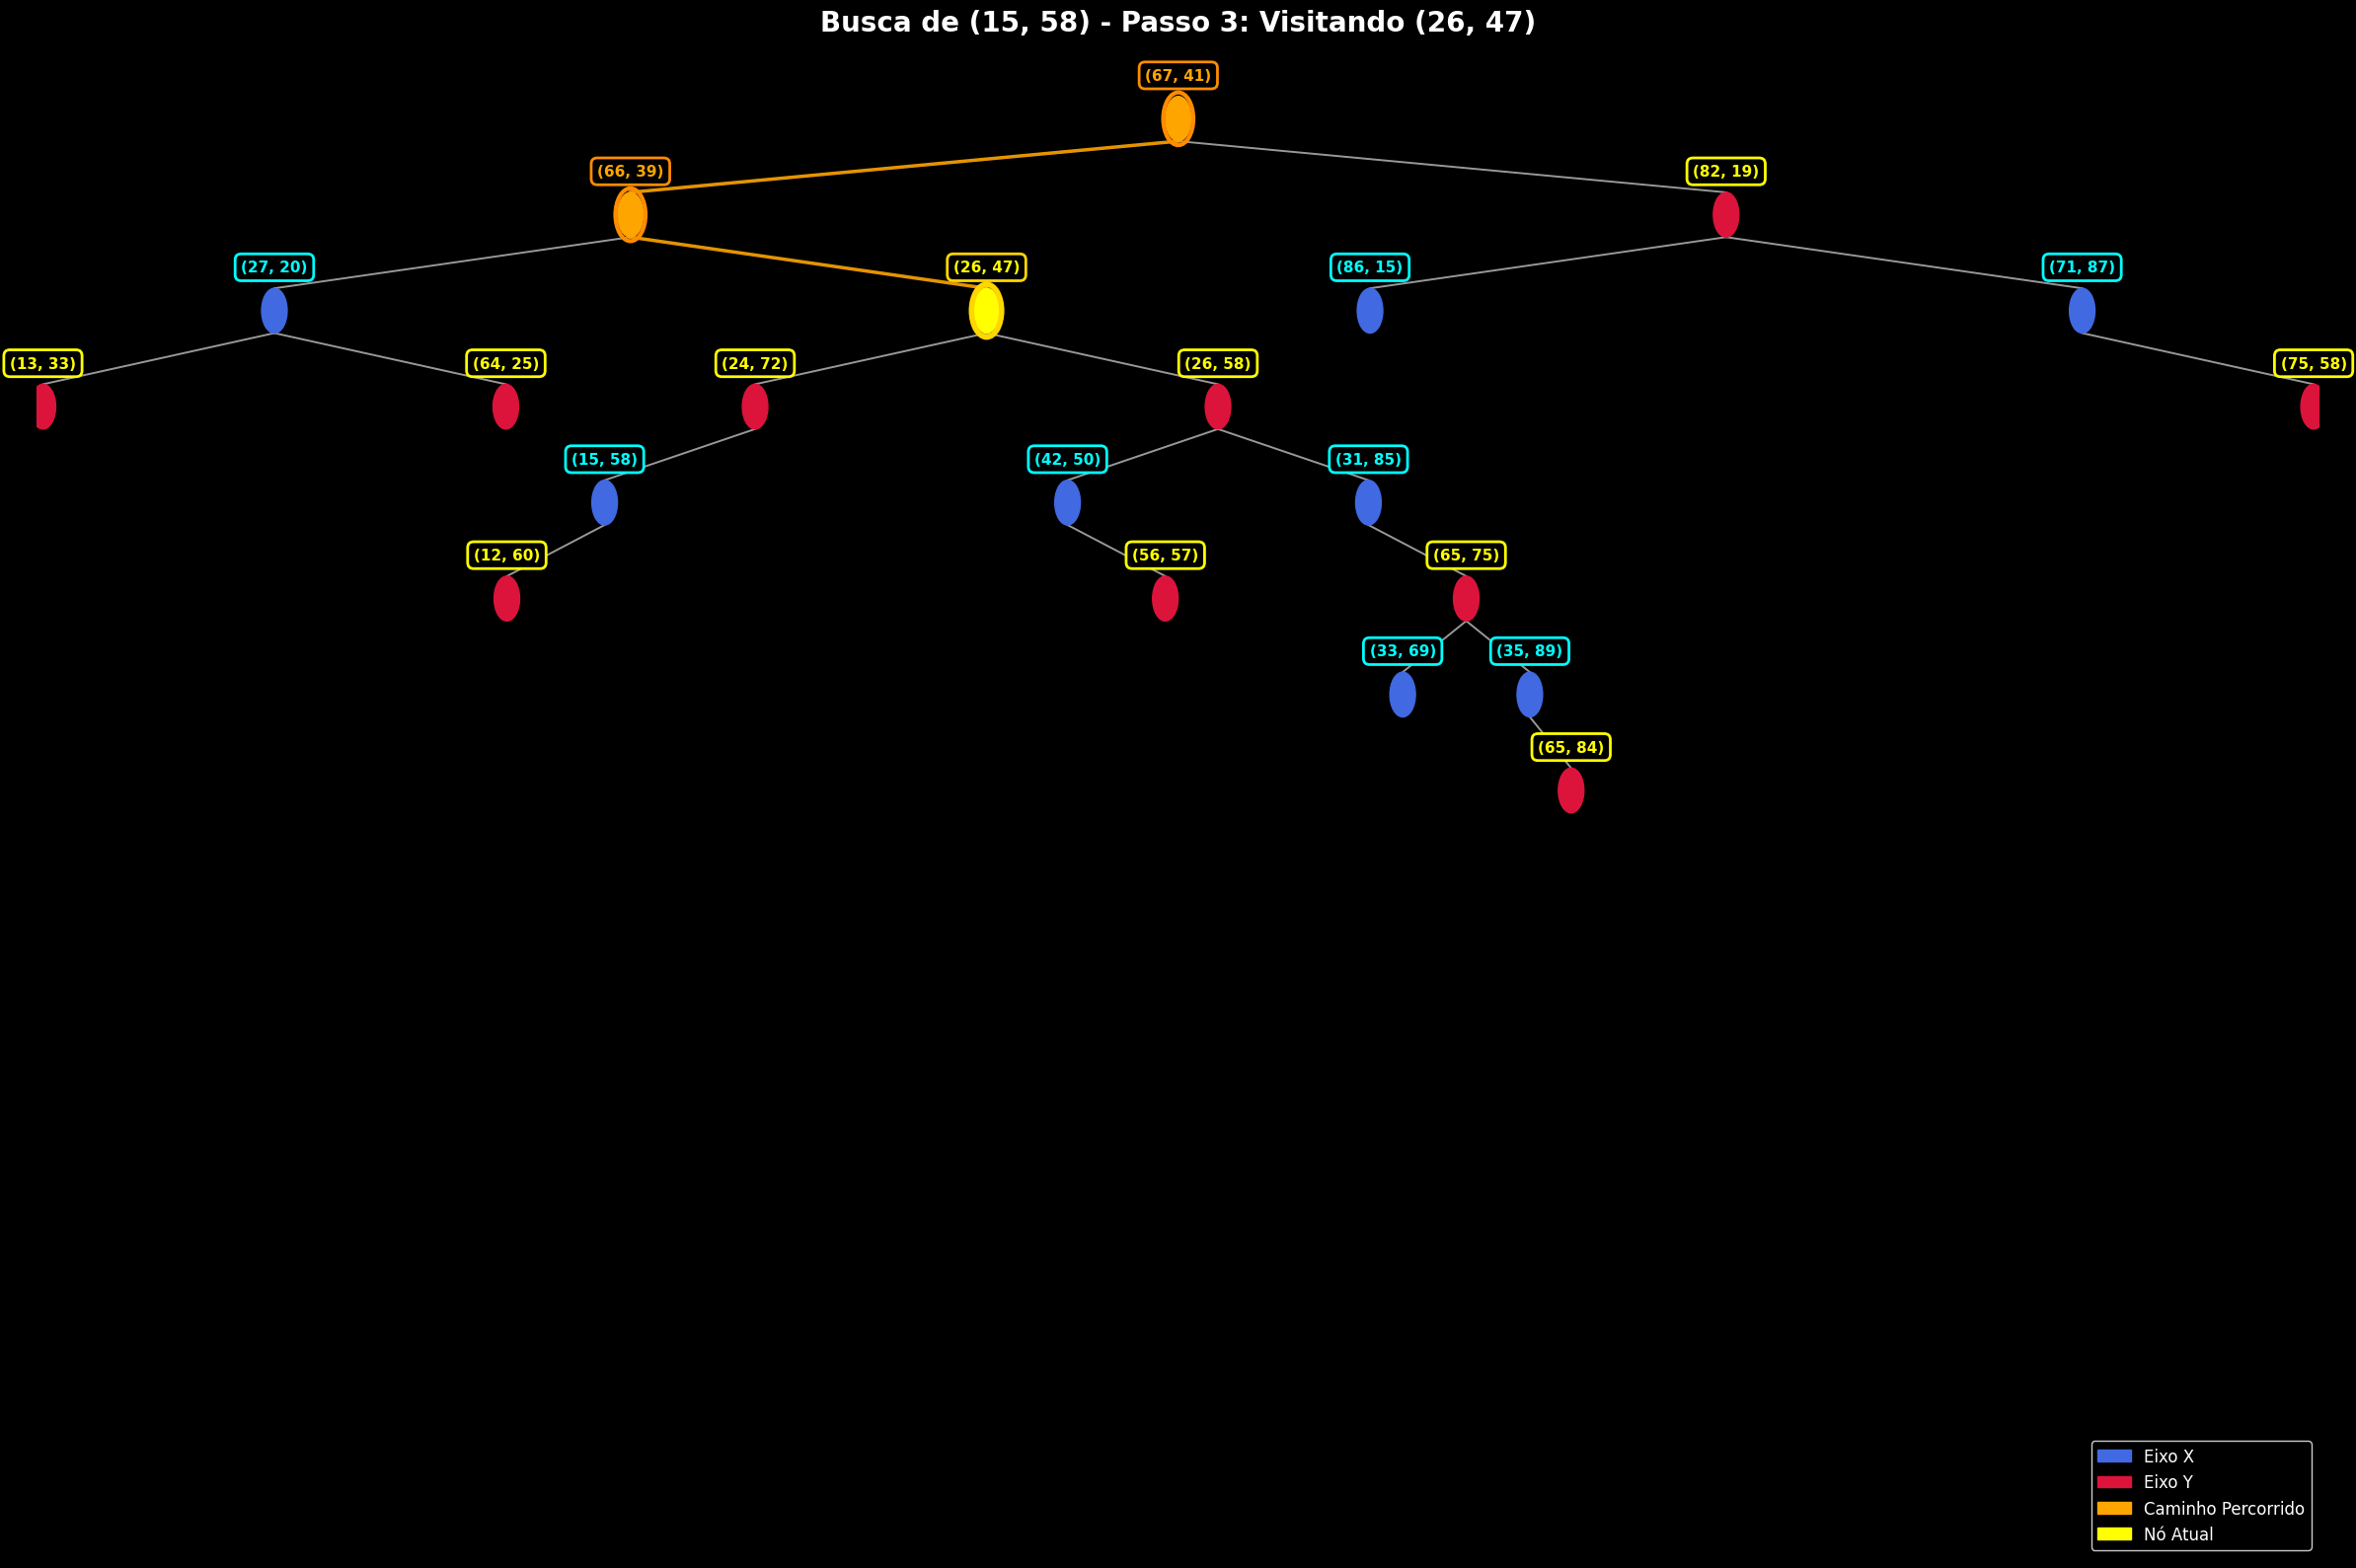


  Passo 4: Visitando (24, 72) (eixo Y)
  → Comparando: 58 < 72
  → Indo para: ESQUERDA


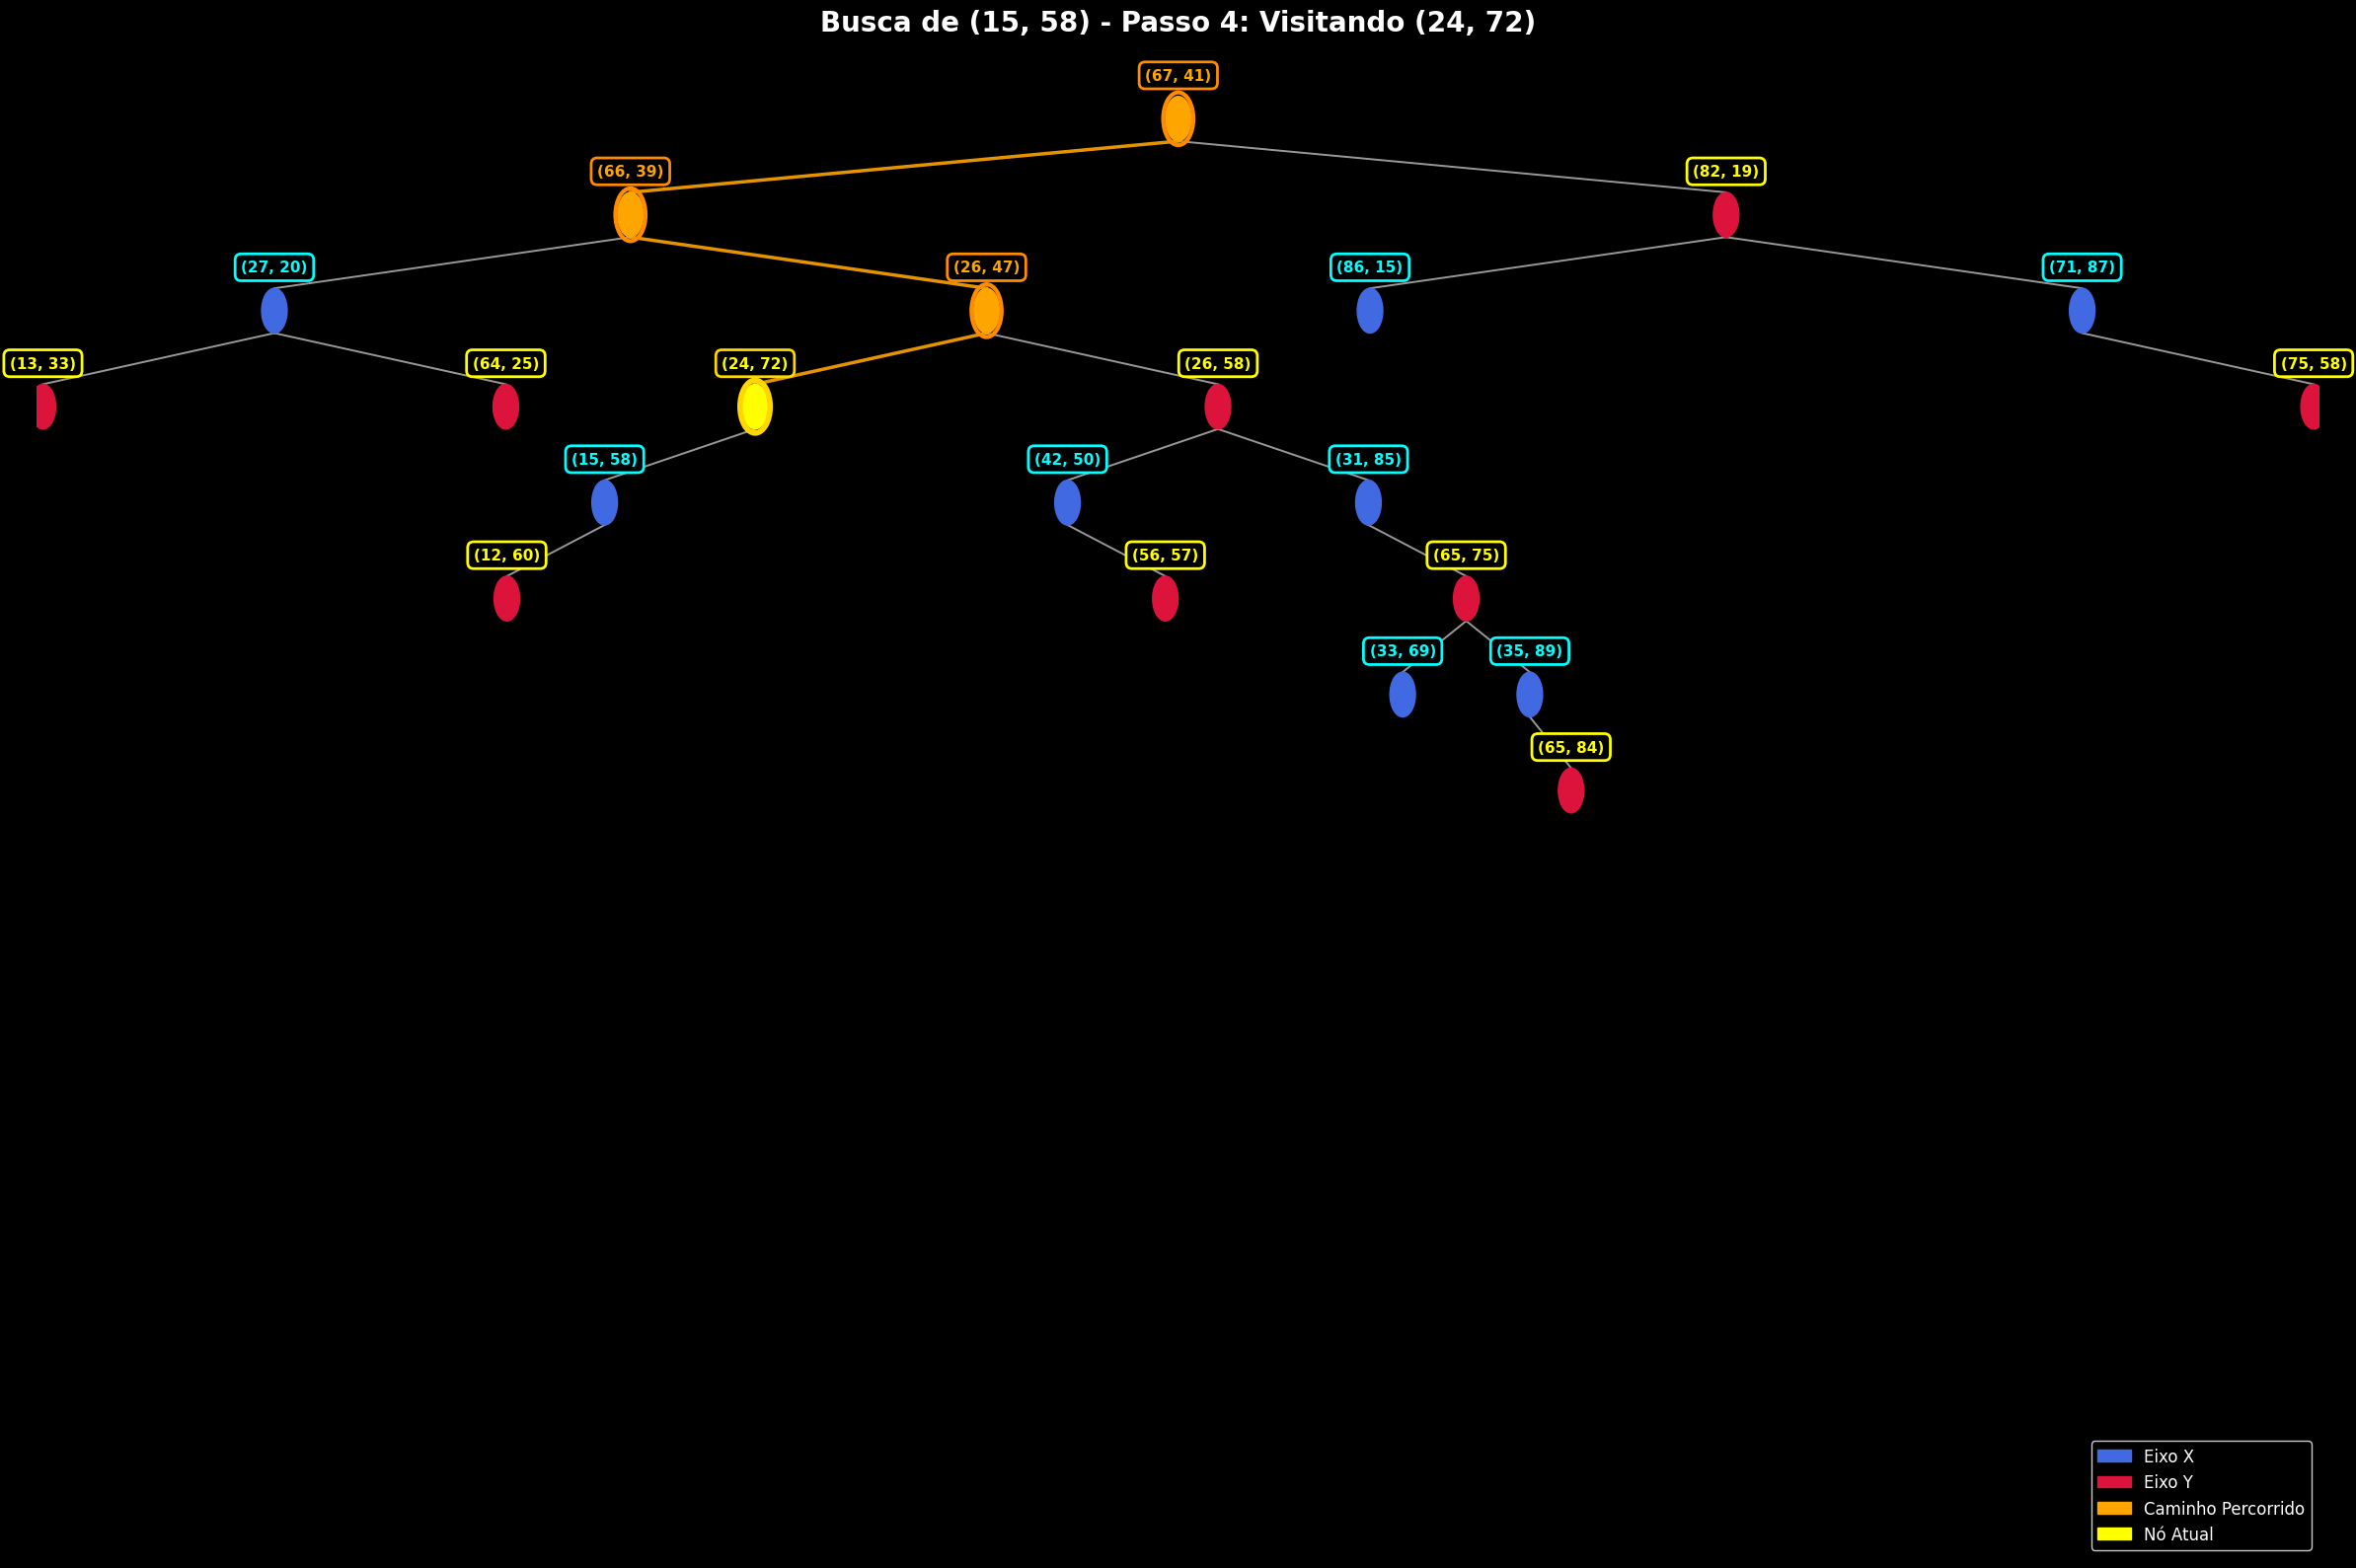


  Passo 5: Visitando (15, 58) - ENCONTRADO! ✅


C:\Users\PC\AppData\Local\Temp\ipykernel_15848\3271775852.py:338: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


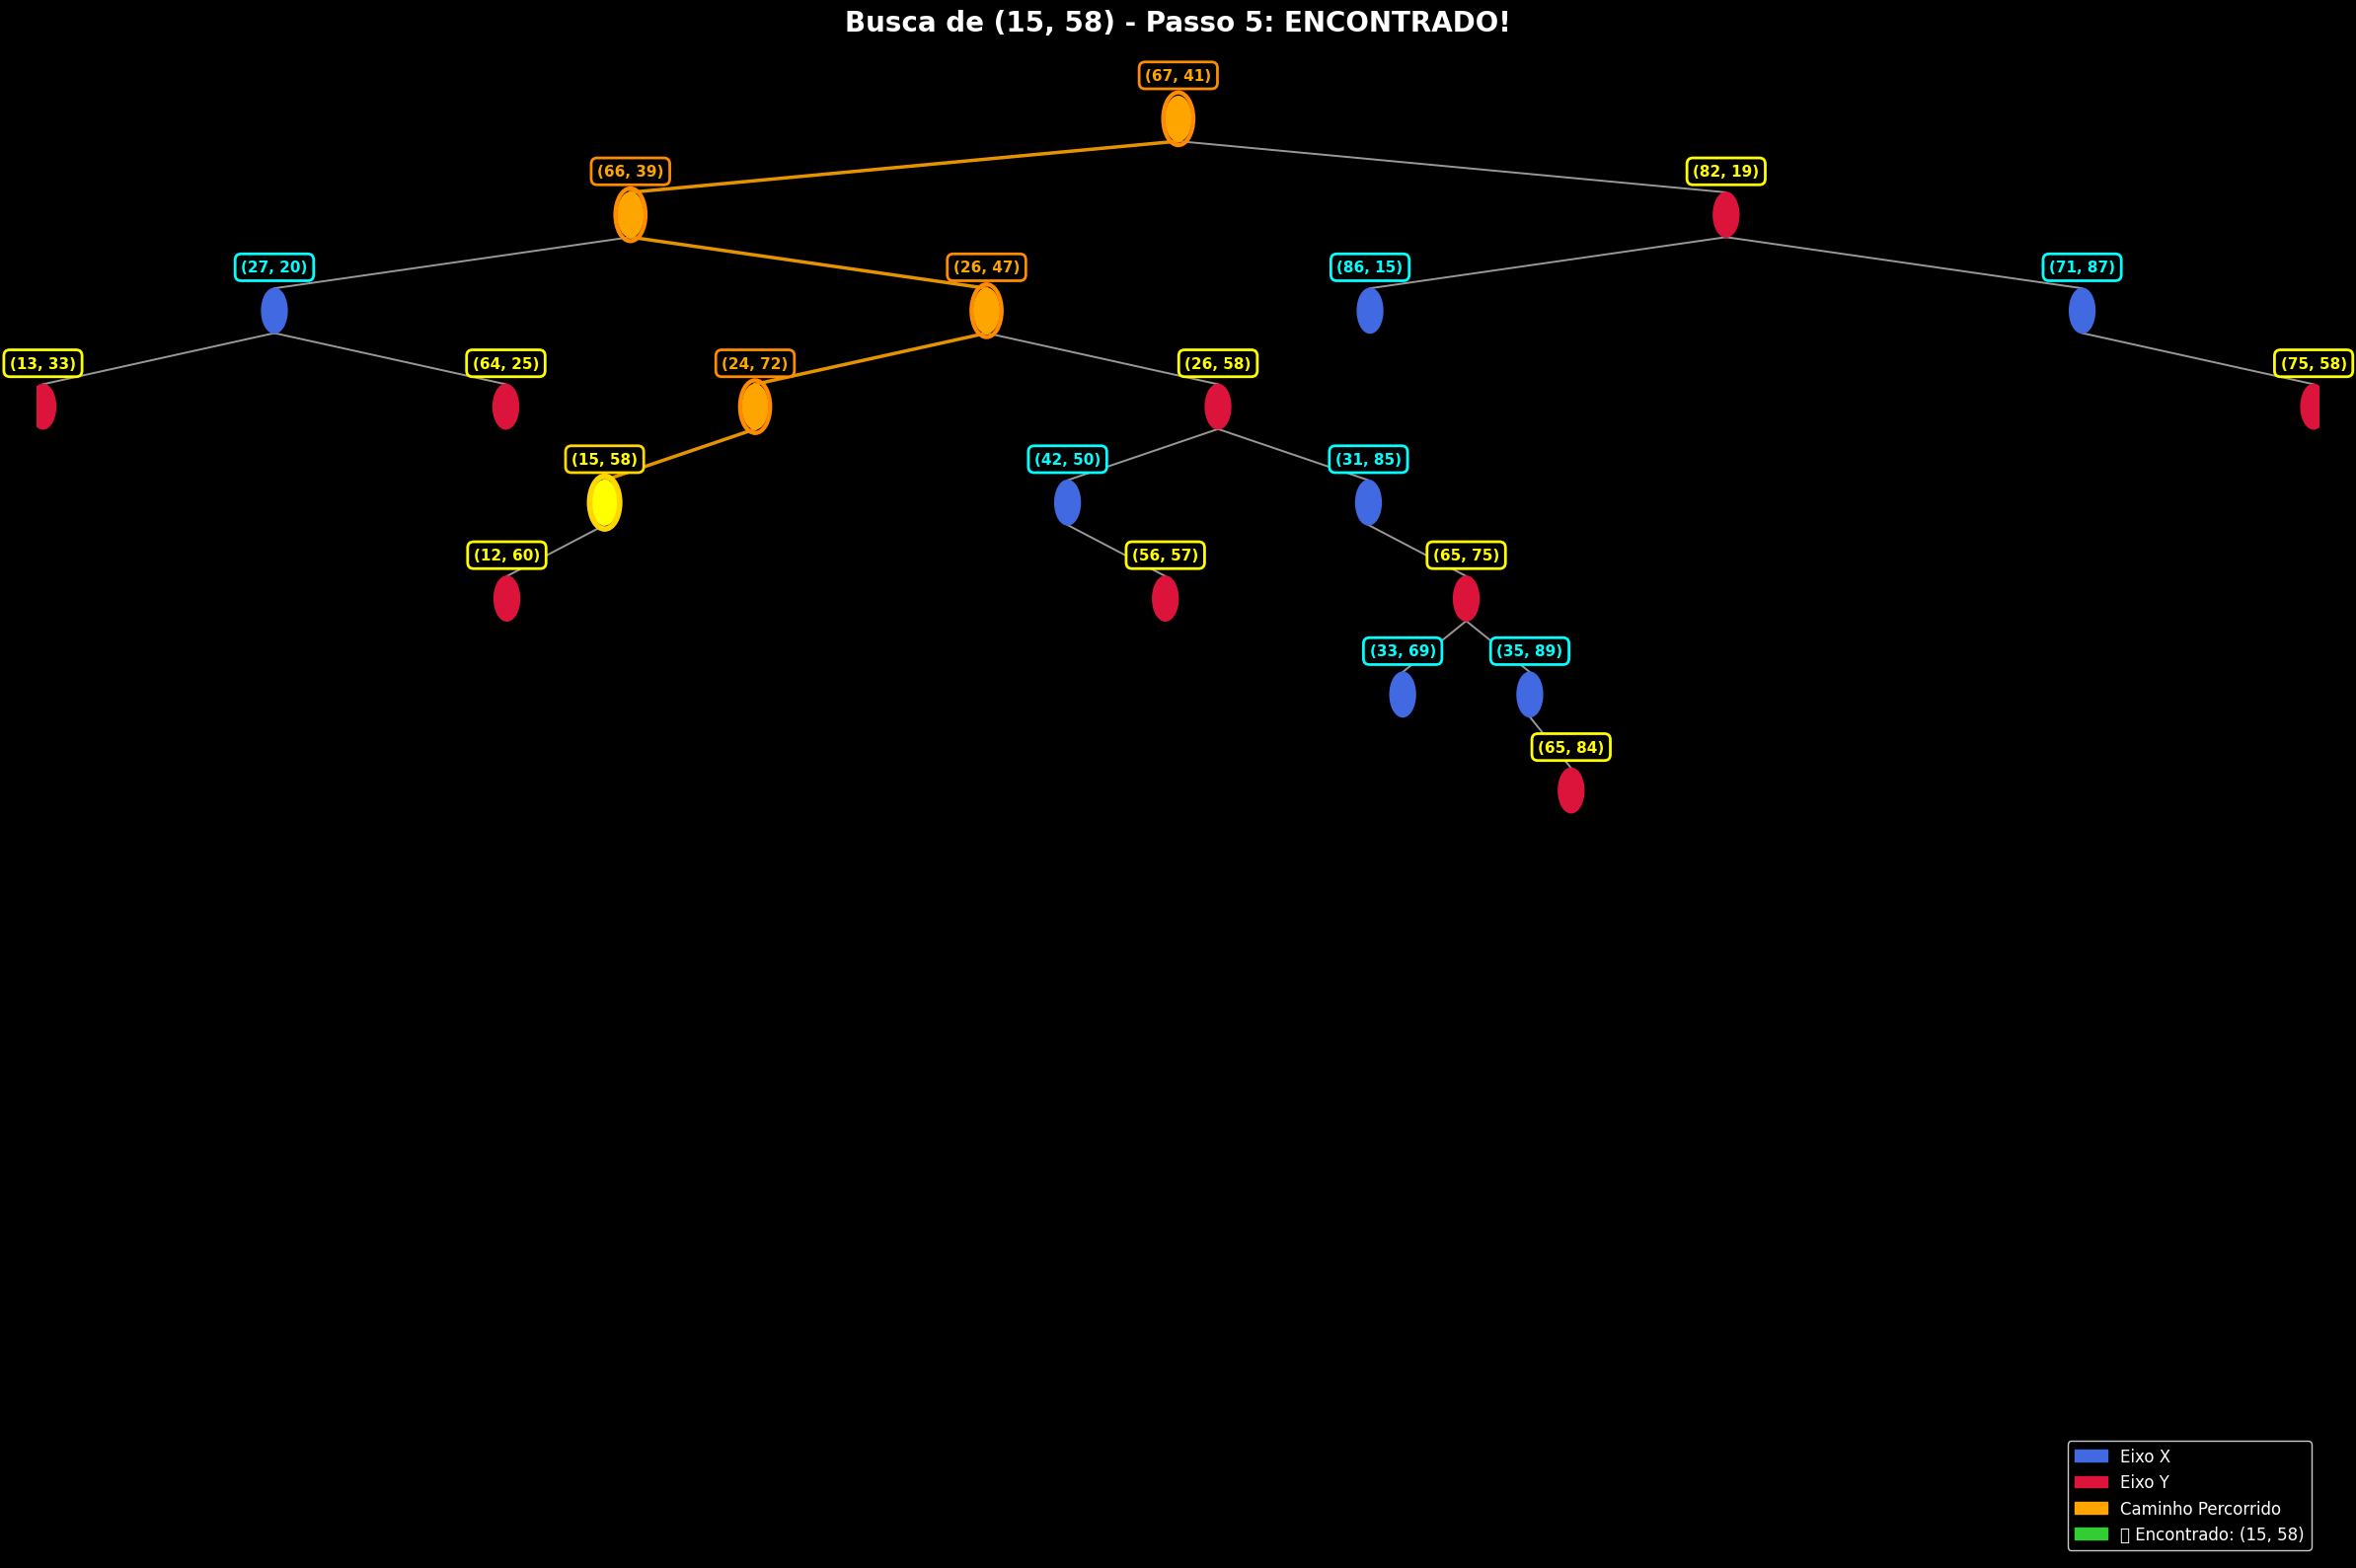


📍 VISUALIZAÇÃO NO PLANO 2D - PASSO A PASSO

  Passo 1 (Plano 2D): Visitando (67, 41)
  → Divisão por eixo X
  → Indo para: ESQUERDA


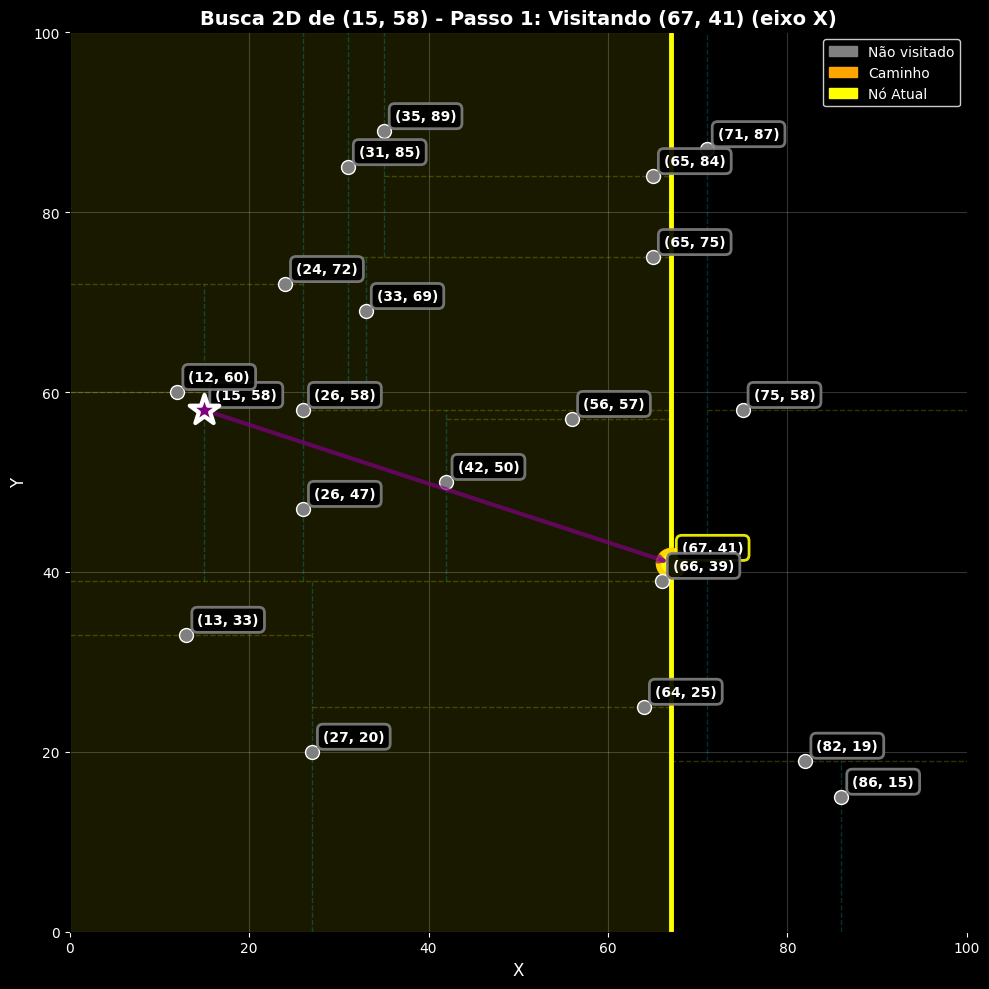


  Passo 2 (Plano 2D): Visitando (66, 39)
  → Divisão por eixo Y
  → Indo para: DIREITA


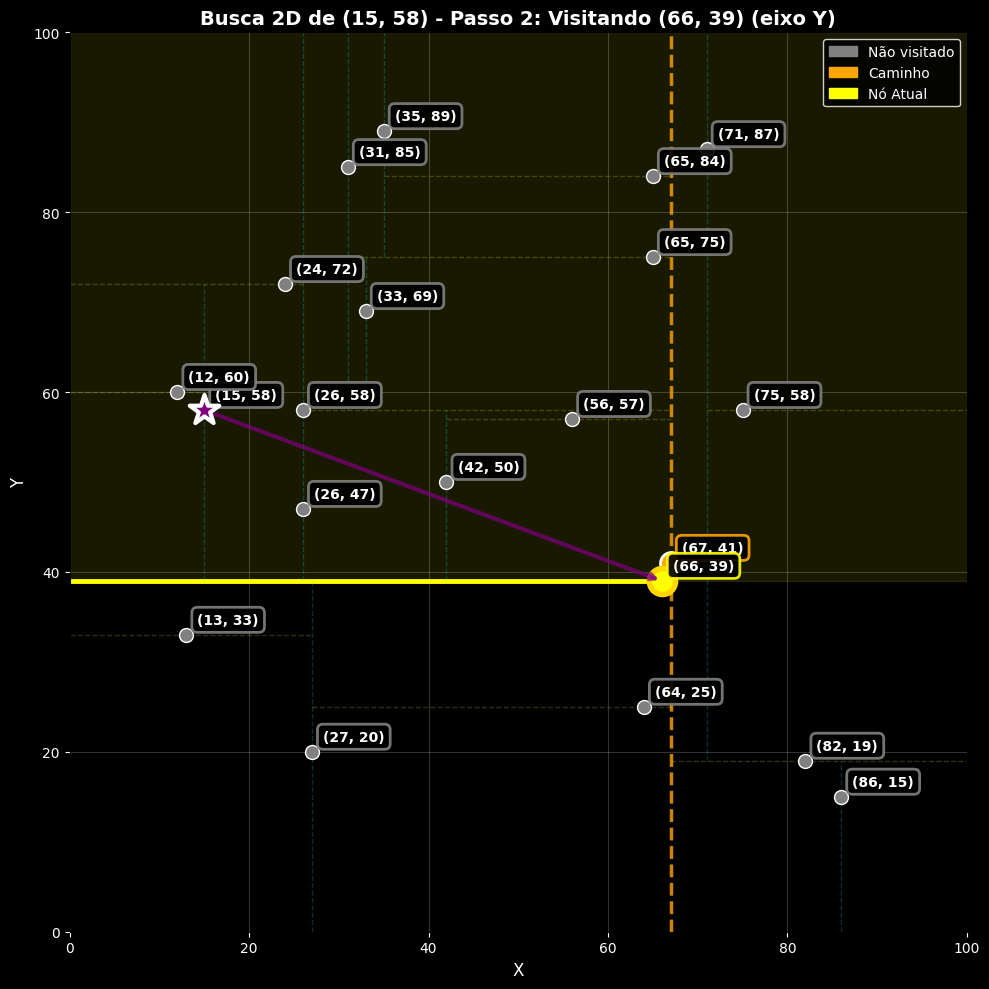


  Passo 3 (Plano 2D): Visitando (26, 47)
  → Divisão por eixo X
  → Indo para: ESQUERDA


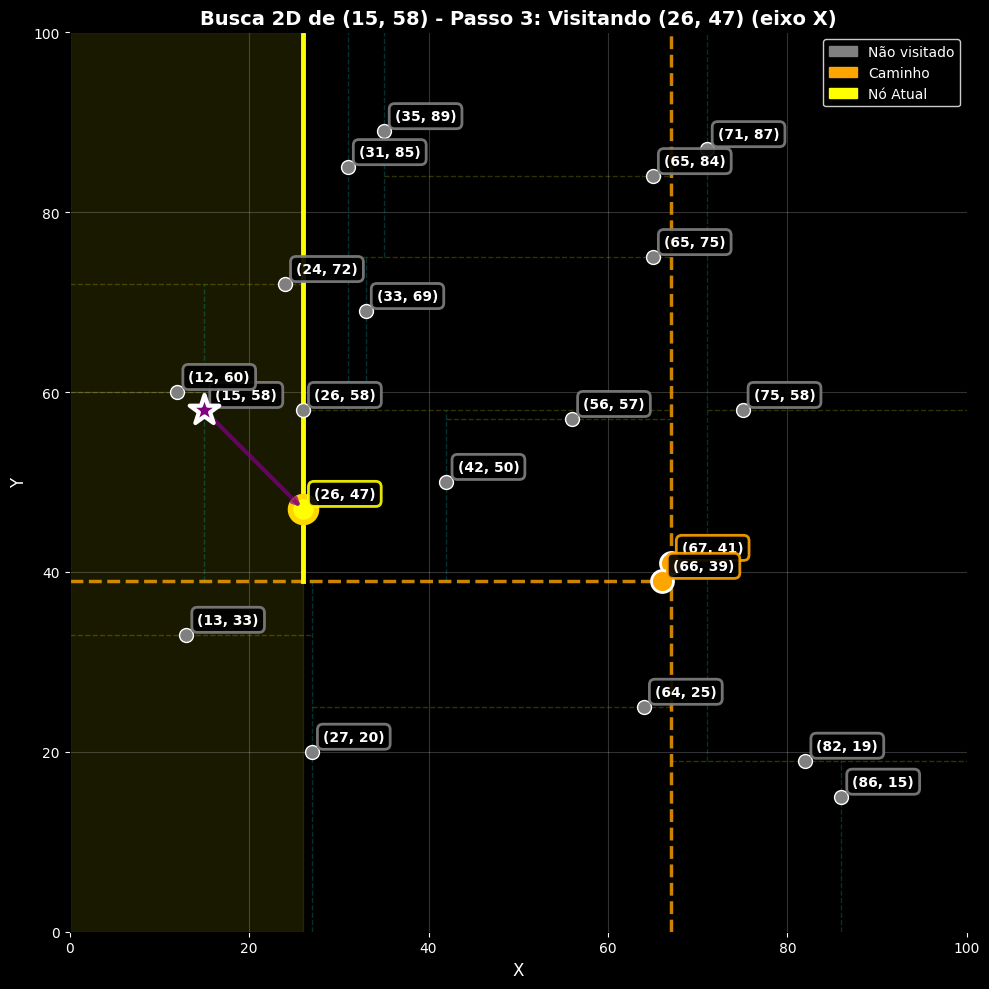


  Passo 4 (Plano 2D): Visitando (24, 72)
  → Divisão por eixo Y
  → Indo para: ESQUERDA


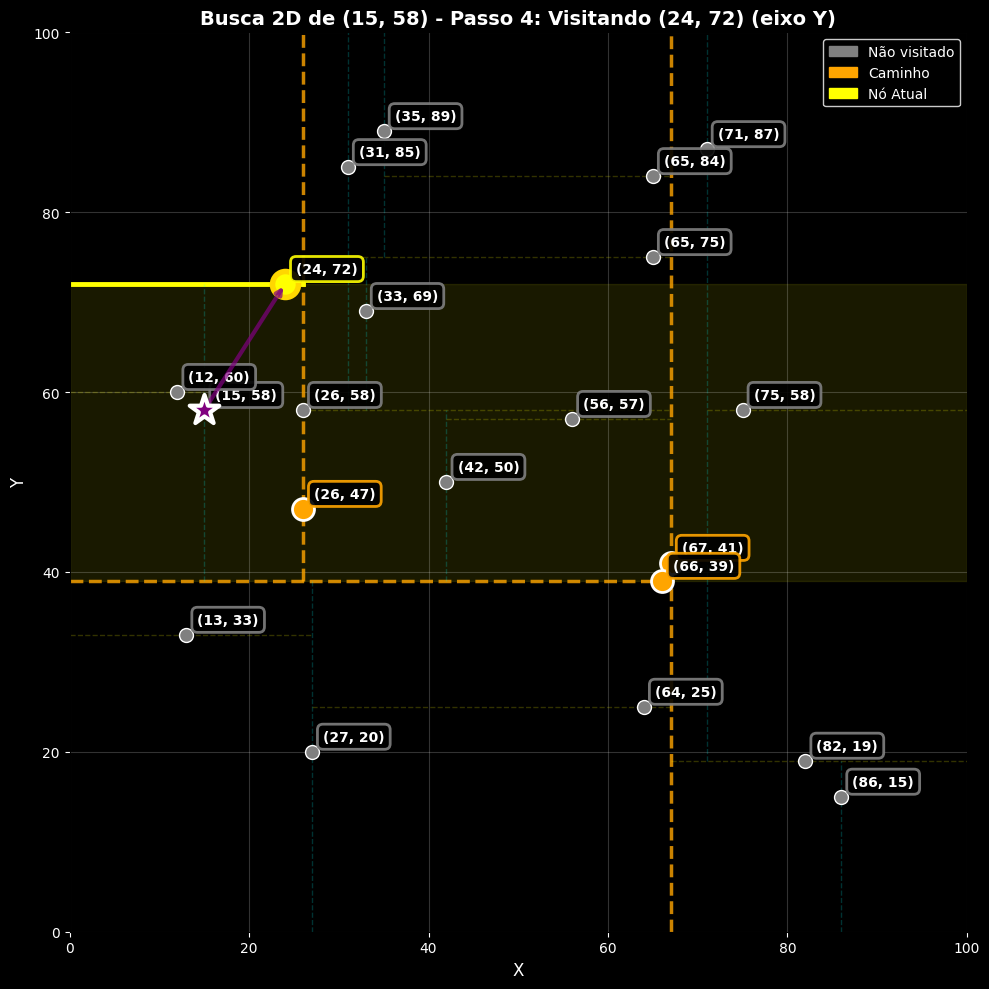


  Passo 5 (Plano 2D): ENCONTRADO em (15, 58)! ✅


C:\Users\PC\AppData\Local\Temp\ipykernel_15848\3271775852.py:204: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


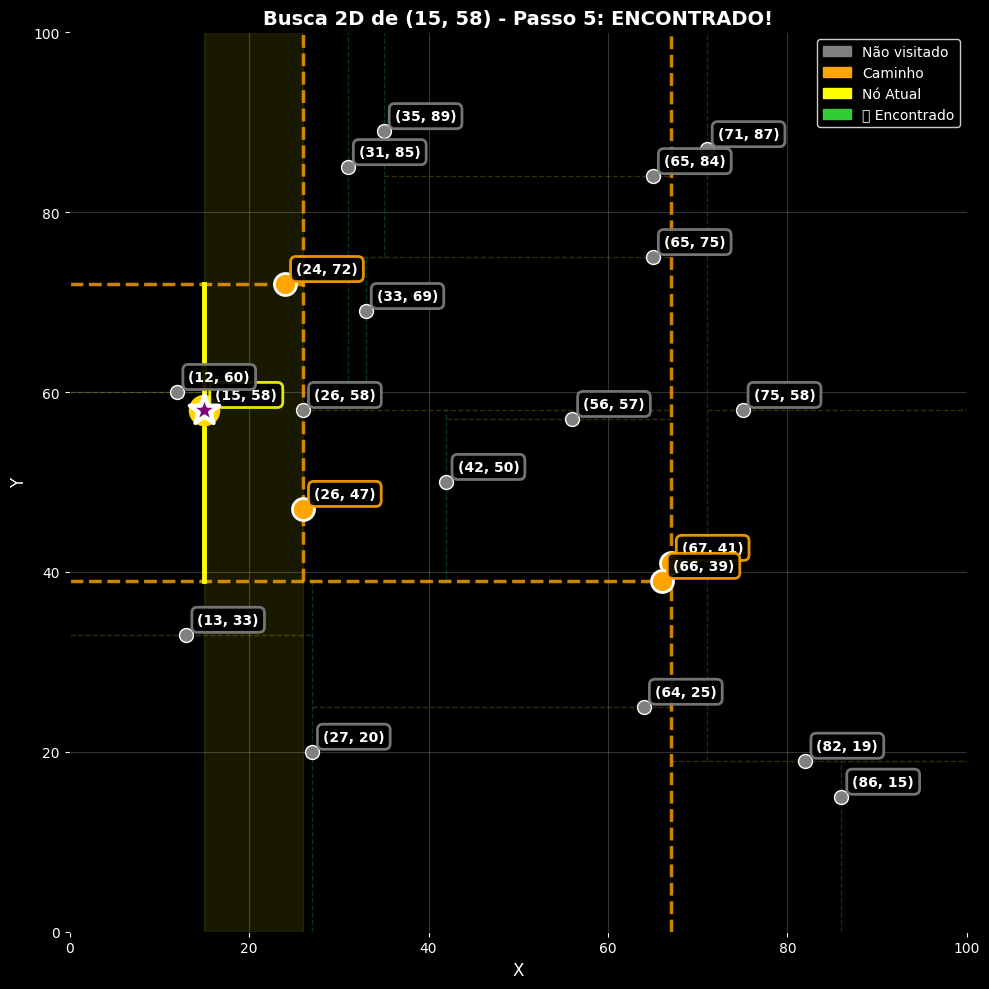

In [32]:
ponto_buscar = random.choice(pontos)
buscar_passo_a_passo(arvore, ponto_buscar)